In [ ]:
# mount drive with files

from google.colab import drive
drive.mount('/content/drive')


!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.3 MB/s eta 0:00:00


In [ ]:
# import libraries

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nibabel as nib

from monai.losses import DiceCELoss, GeneralizedDiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AddChanneld,
    LoadImaged,
    ScaleIntensityd,
    ToTensord,

)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR, UNet, AttentionUnet

from monai.data import (
    DataLoader,
    SmartCacheDataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

import torch
# print_config()


# switch off warning messages
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# set dimensions of the input images (128x128x128) and number of classes (number of labels + background)
img_dim=128
lab_num=1
class_num=lab_num+1


degree_min = -1
degree_max = 1

roi_type="face_"

roi_type="face_"

split_JSON = "face-training-1-lab-v1.json"
split_JSON_run = "face-training-1-lab-v1.json"



root_dir='/content/drive/MyDrive/face-seg-project-2023/new-training-062023/'
data_dir = '/content/drive/MyDrive/face-seg-project-2023/new-training-062023/'

print(root_dir)
os.chdir(root_dir)



/content/drive/MyDrive/face-seg-project-2023/new-training-062023/


In [ ]:
# define data loaders and augmentation for training and validation

train_transforms = Compose(

        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),
        ToTensord(keys=["image", "label"]),
    ]
)



In [ ]:
# load the files based on the lists in .json

datasets = data_dir + split_JSON

datalist = load_decathlon_datalist(datasets, True, "training")

train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=200,
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=True
)

val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(
    data=val_files,
    transform=val_transforms,
    cache_num=80,
    cache_rate=1.0,
    num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)


Loading dataset: 100%|██████████| 12/12 [00:04<00:00,  2.92it/s]


One Training Example:


0 303-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


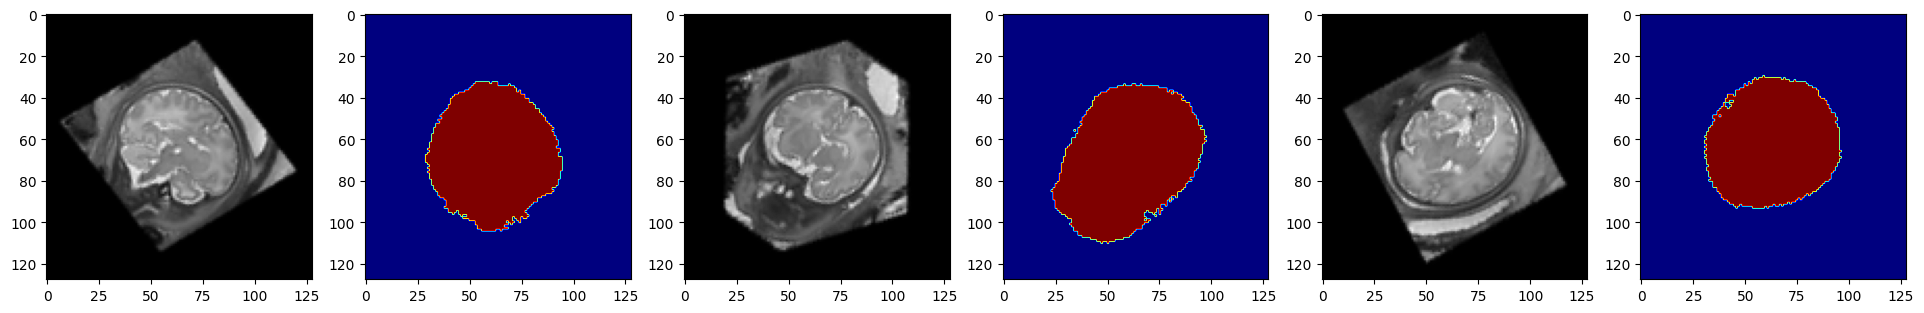

1 403-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


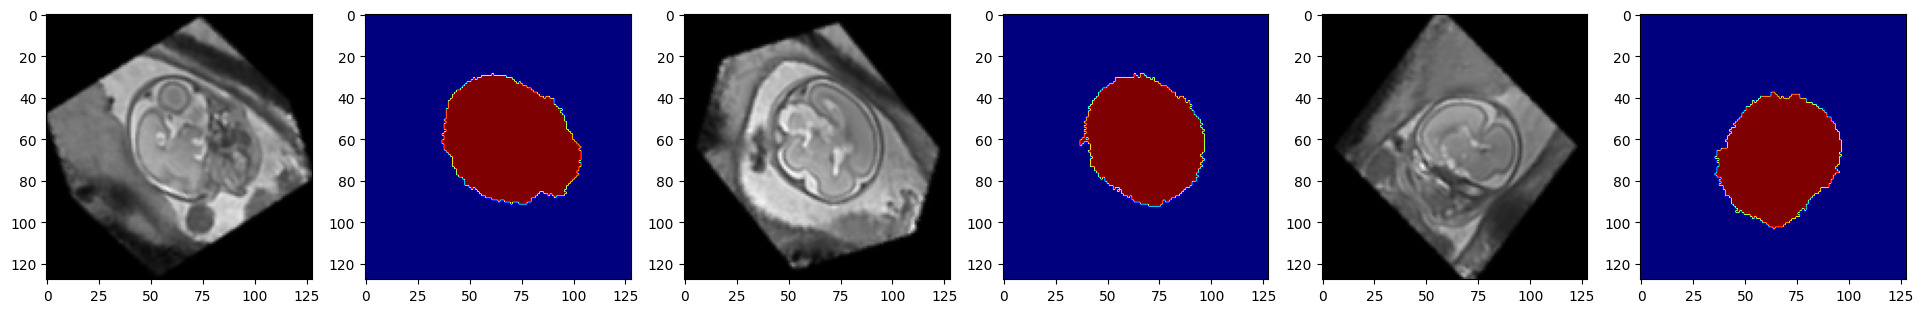

2 328-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


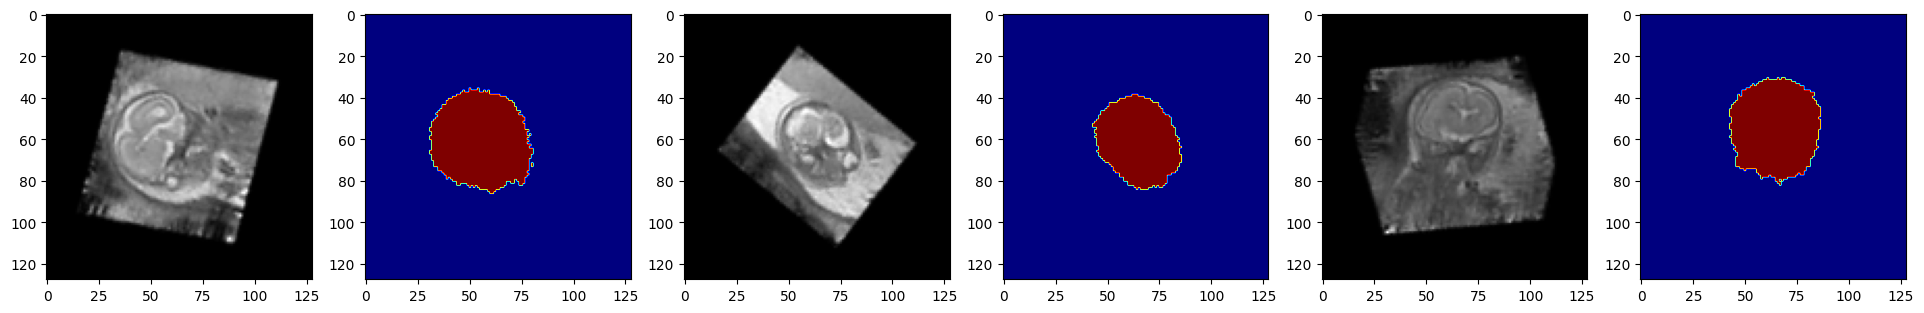

3 408-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


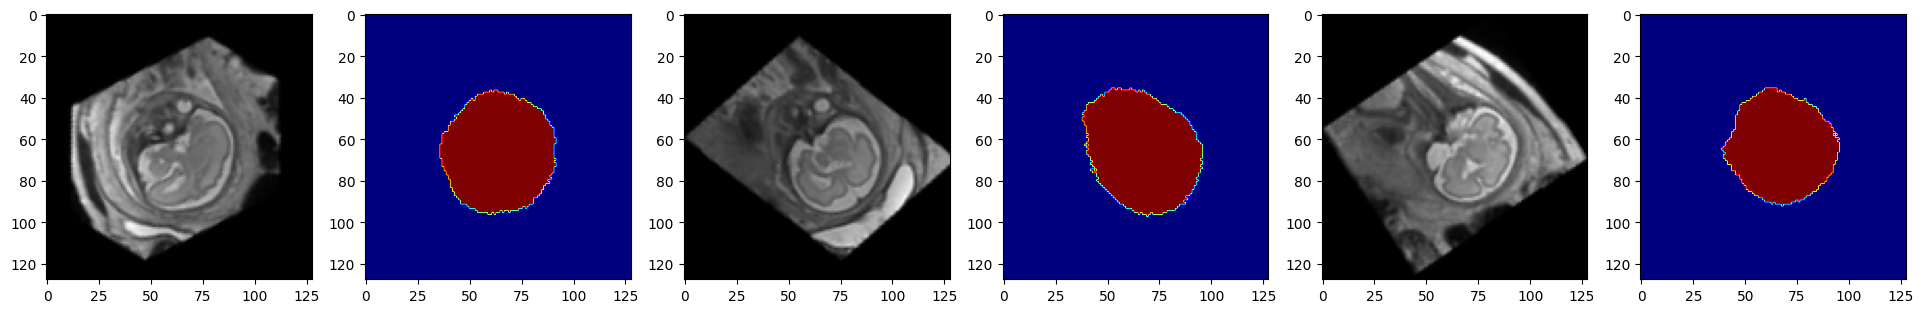

4 235-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


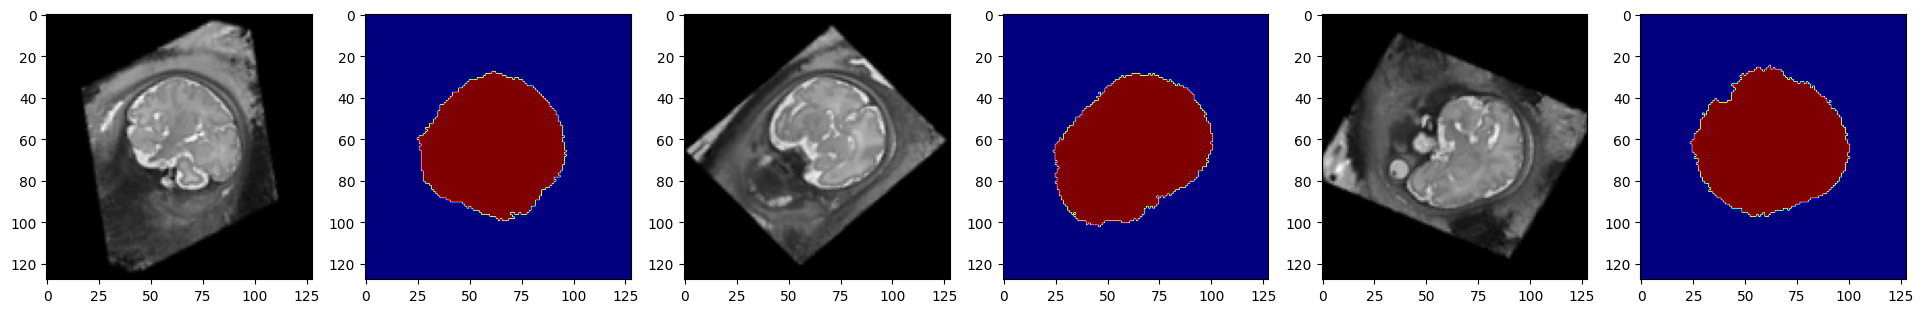

5 294-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


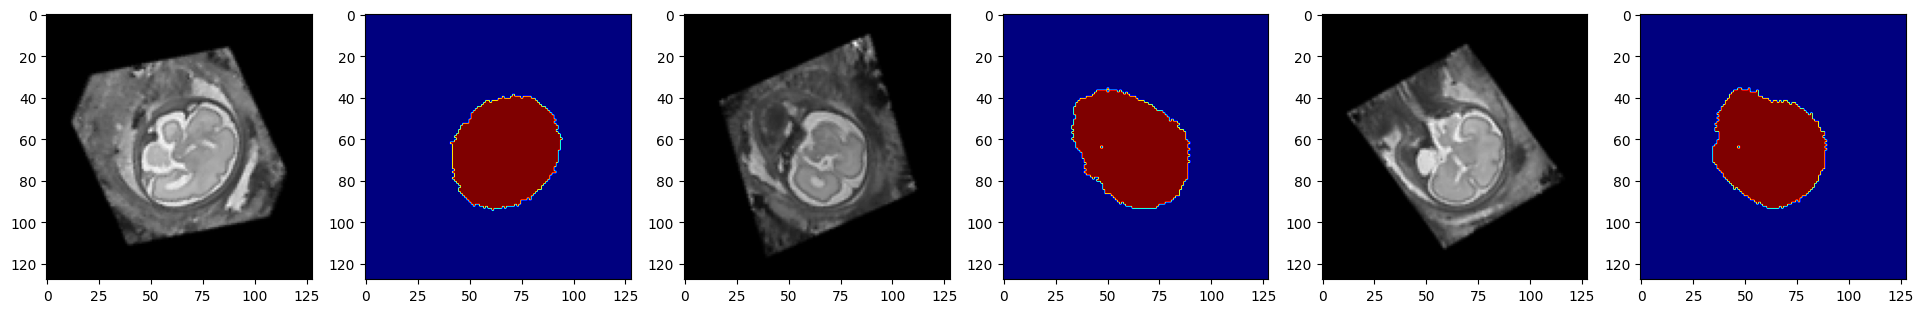

6 296-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


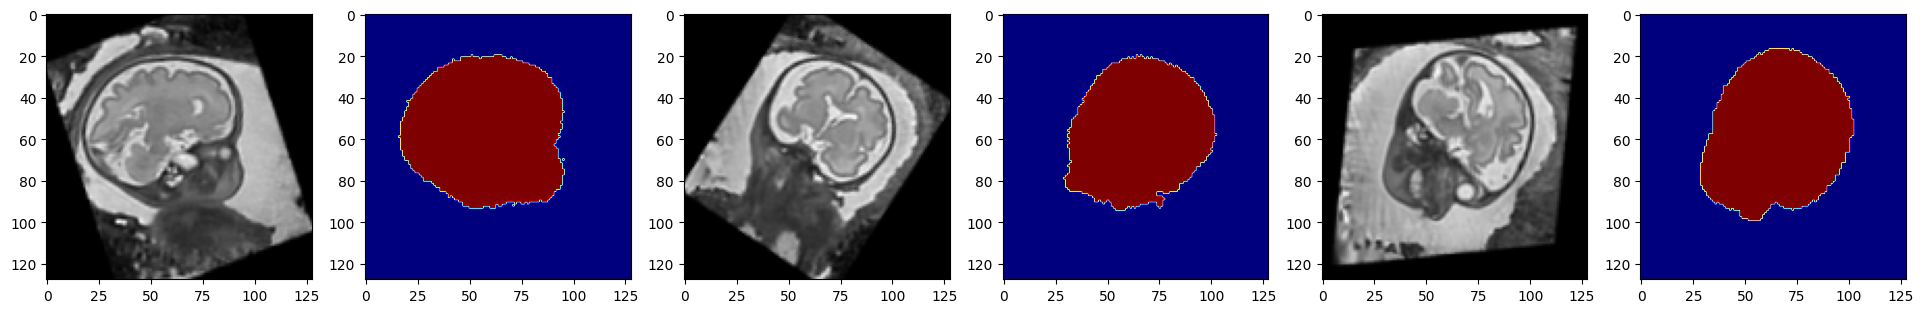

7 312-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


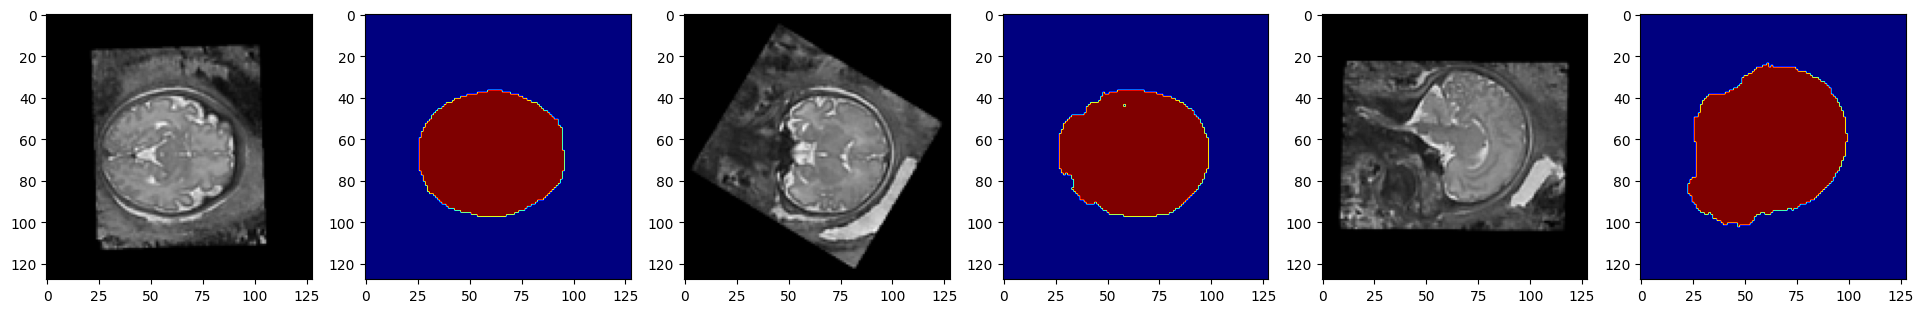

8 340-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


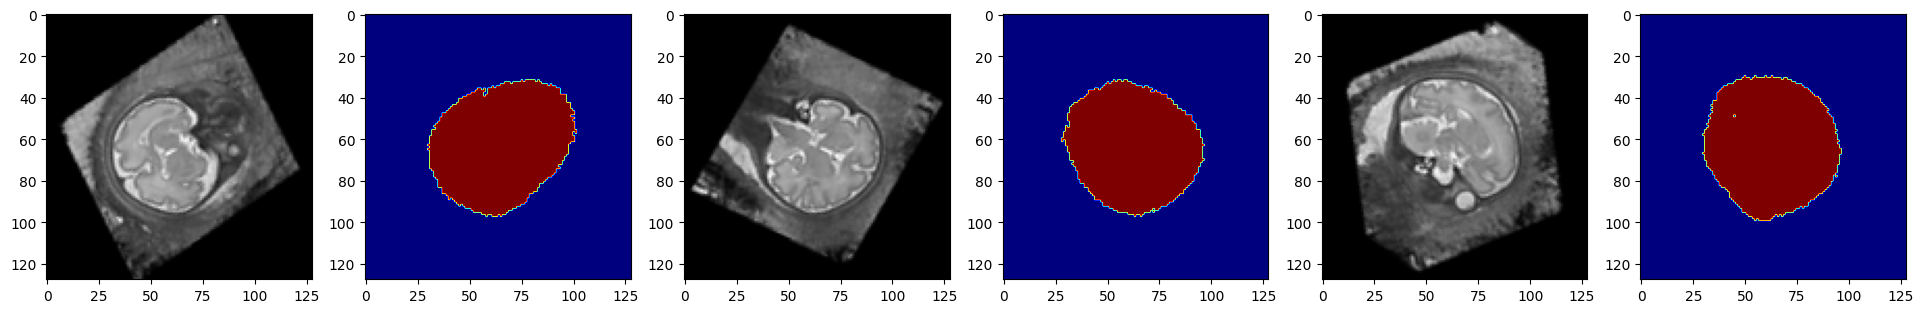

9 371-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


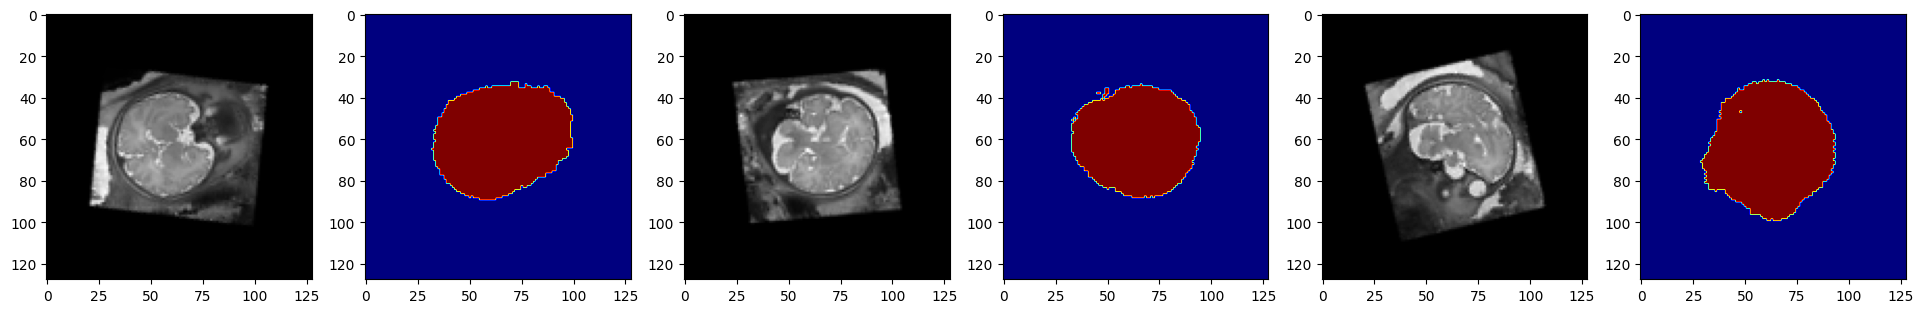

10 394-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


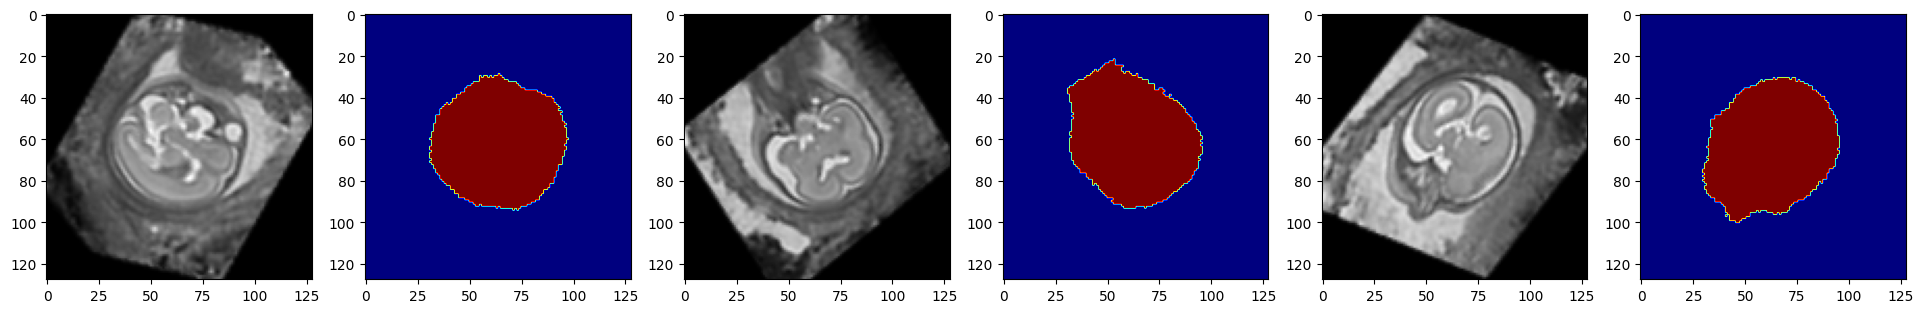

11 396-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


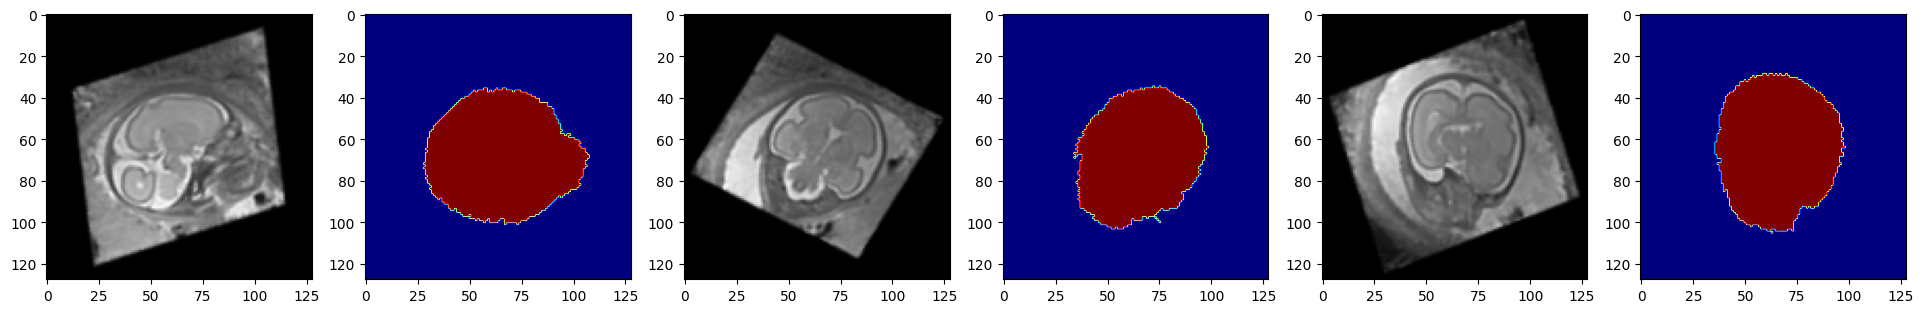

12 404-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


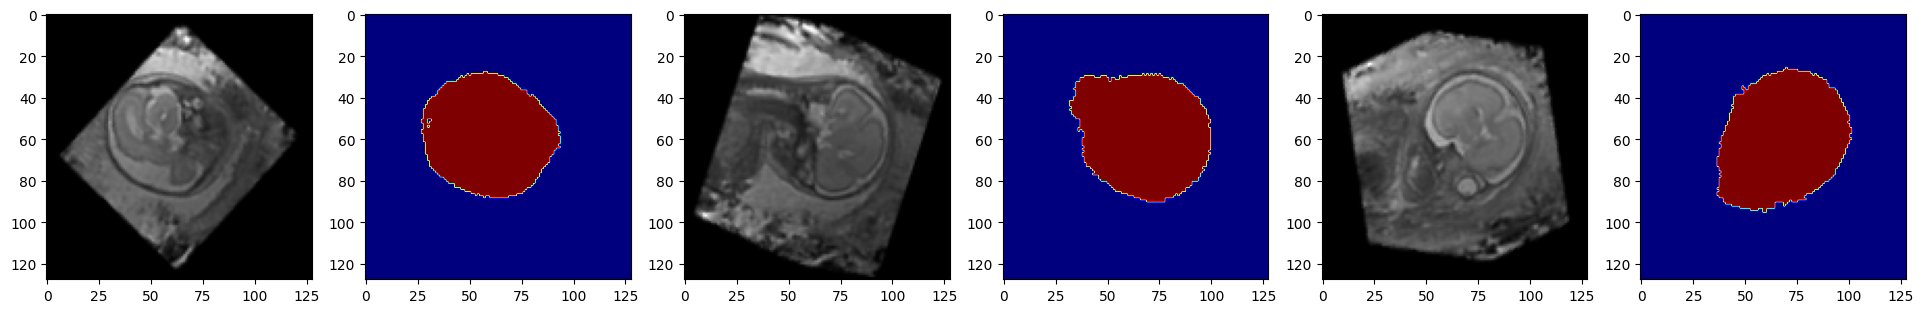

13 415-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


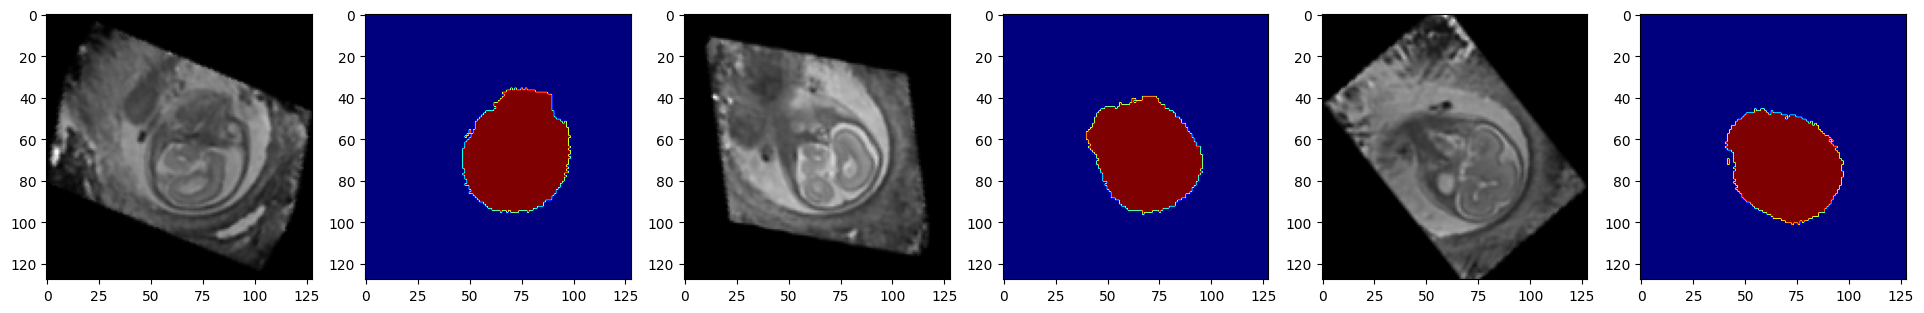

14 420-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


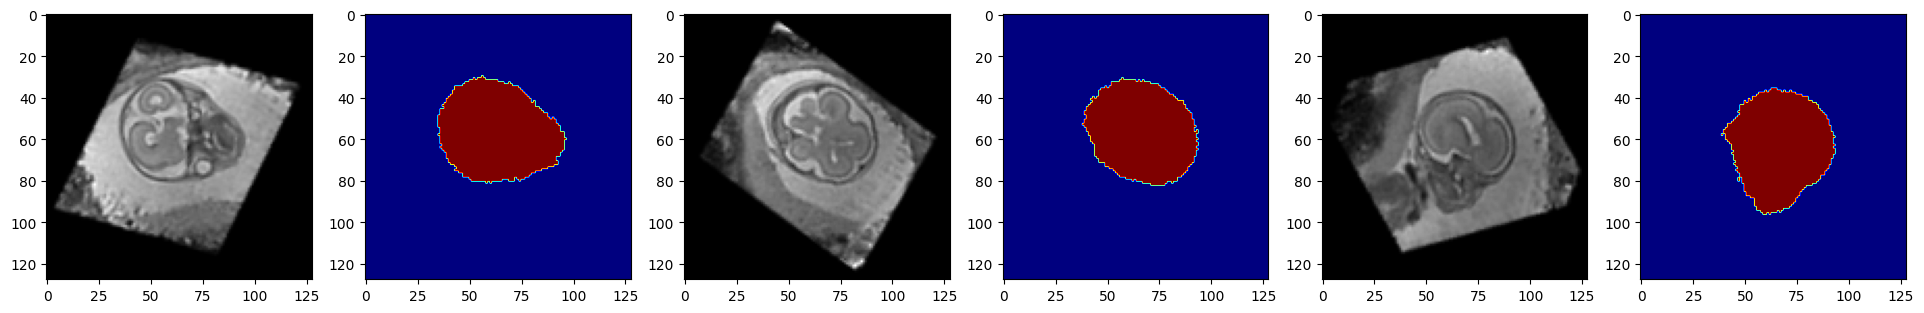

15 421-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


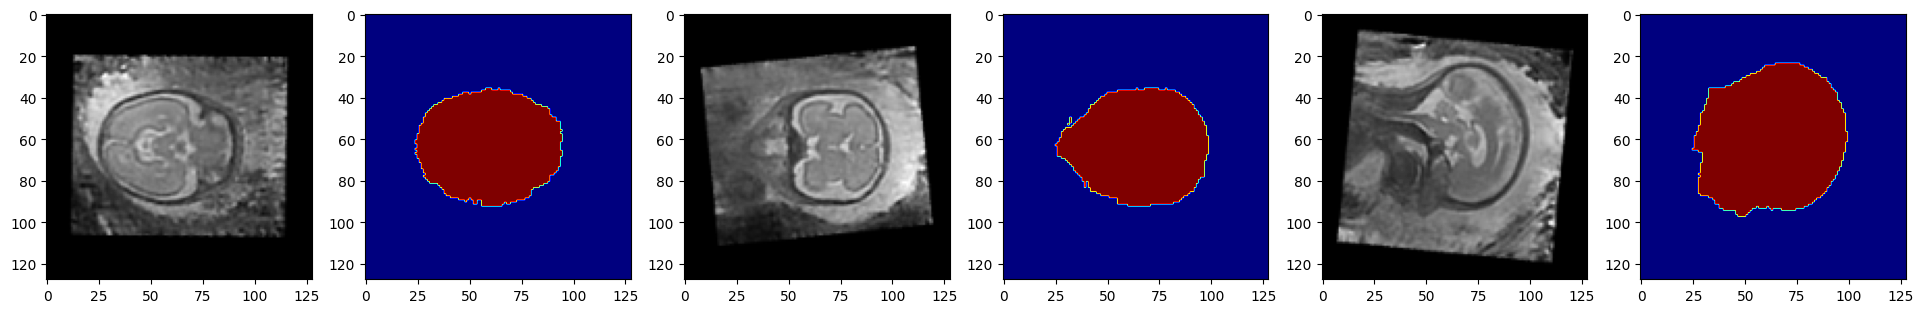

16 425-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


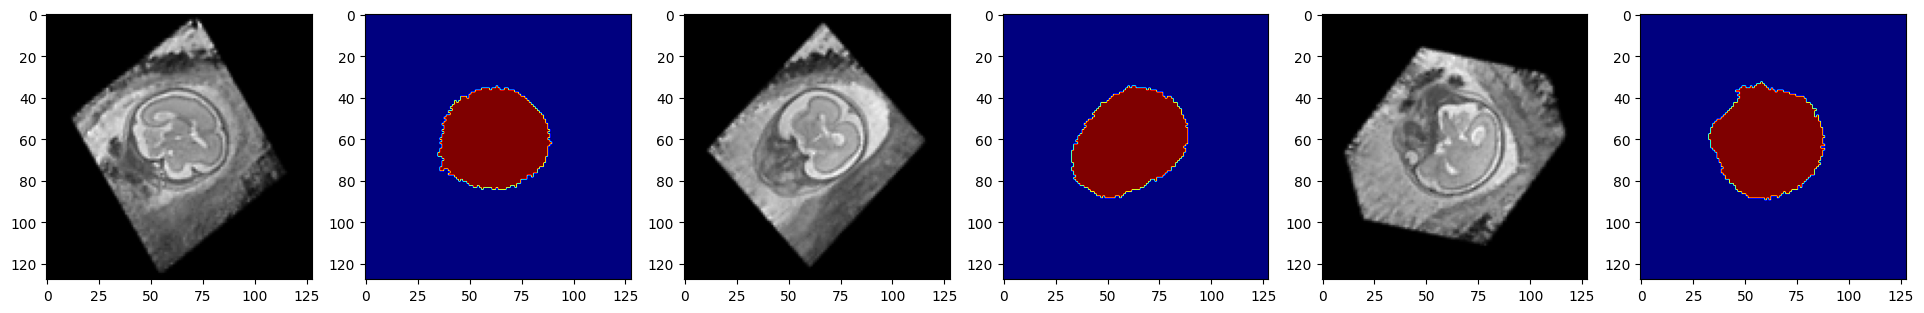

17 429-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


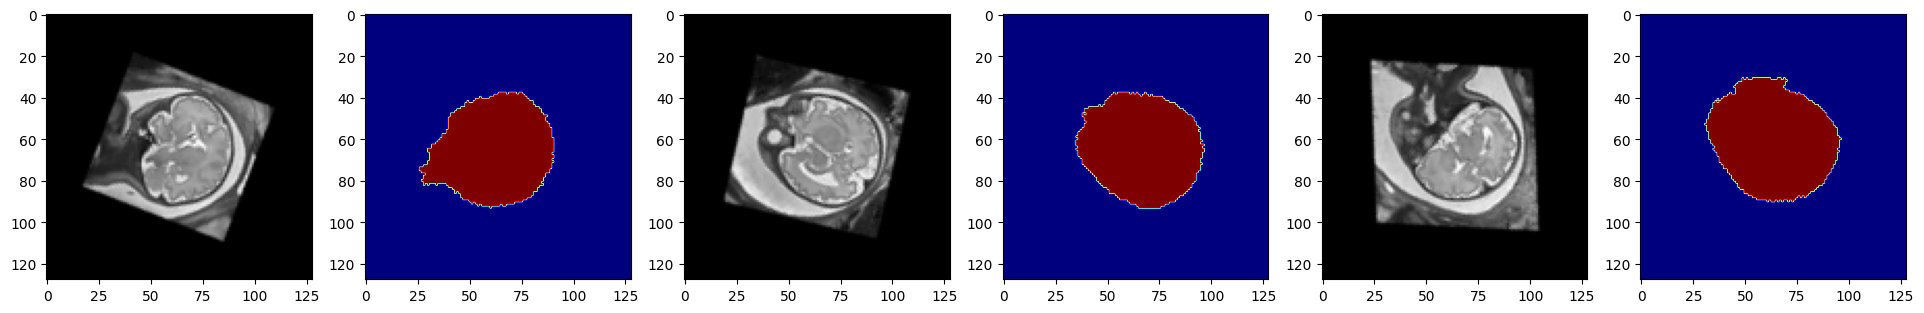

18 440-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


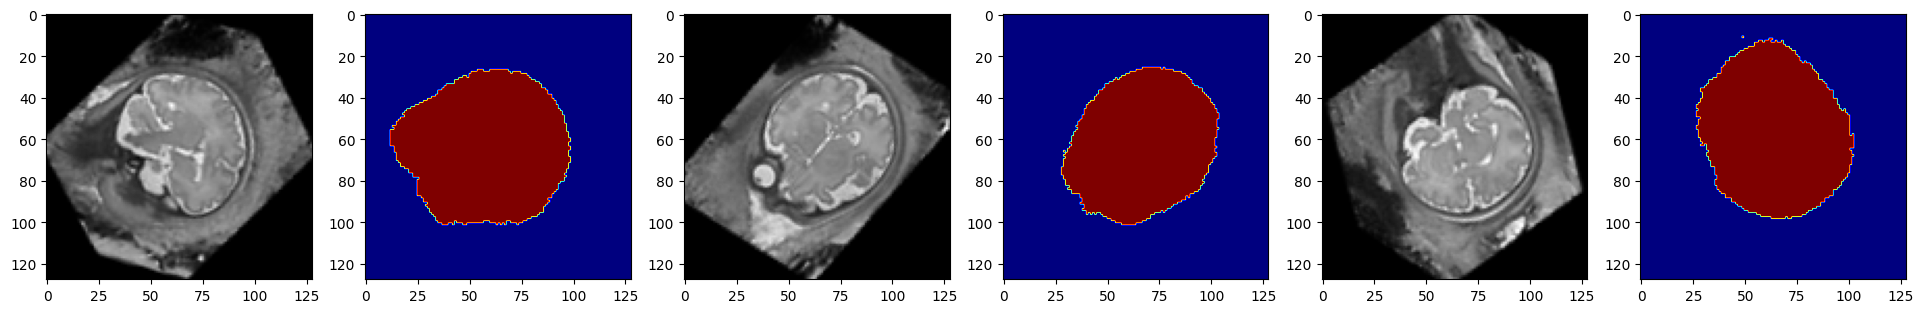

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-d11ff6594b60>", line 12, in <cell line: 6>
    case_in=train_ds[case_num]
  File "/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py", line 112, in __getitem__
    return self._transform(index)
  File "/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py", line 928, in _transform
    data = self.transform(data, start=first_random)
  File "/usr/local/lib/python3.10/dist-packages/monai/transforms/compose.py", line 322, in __call__
    result = execute_compose(
  File "/usr/local/lib/python3.10/dist-packages/monai/transforms/compose.py", line 111, in execute_compose
    data = apply_transform(
  File "/usr/local/lib/python3.10/dist-packages/monai/transforms/transform.py", line 141, in apply_transform
    return _apply_transform(transform, data, unpack_i

TypeError: ignored

In [ ]:
s=round(img_dim/2)

print("One Training Example:")
print("\n")

for x in range(len(datalist)):

  case_num = x
  img_name = datalist[case_num]["label"]
  label_name = datalist[case_num]["label"]
  case_name = os.path.split(train_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  case_in=train_ds[case_num]
  img = case_in["image"]
  label = case_in["label"]
  img_shape = img.shape
  label_shape = label.shape

  print(x, case_name, img_shape, label_shape)
  plt.figure("image", (24, 4))
  plt.subplot(1, 6, 1)
  plt.imshow(img[0, :, :, s], cmap="gray")
  plt.subplot(1, 6, 2)
  plt.imshow(label[0, :, :, s], cmap="jet")
  plt.subplot(1, 6, 3)
  plt.imshow(img[0, :, s, :], cmap="gray")
  plt.subplot(1, 6, 4)
  plt.imshow(label[0, :, s, :], cmap="jet")
  plt.subplot(1, 6, 5)
  plt.imshow(img[0, s, :, :], cmap="gray")
  plt.subplot(1, 6, 6)
  plt.imshow(label[0, s, :, :], cmap="jet")
  plt.show()


Validation:


0 261-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


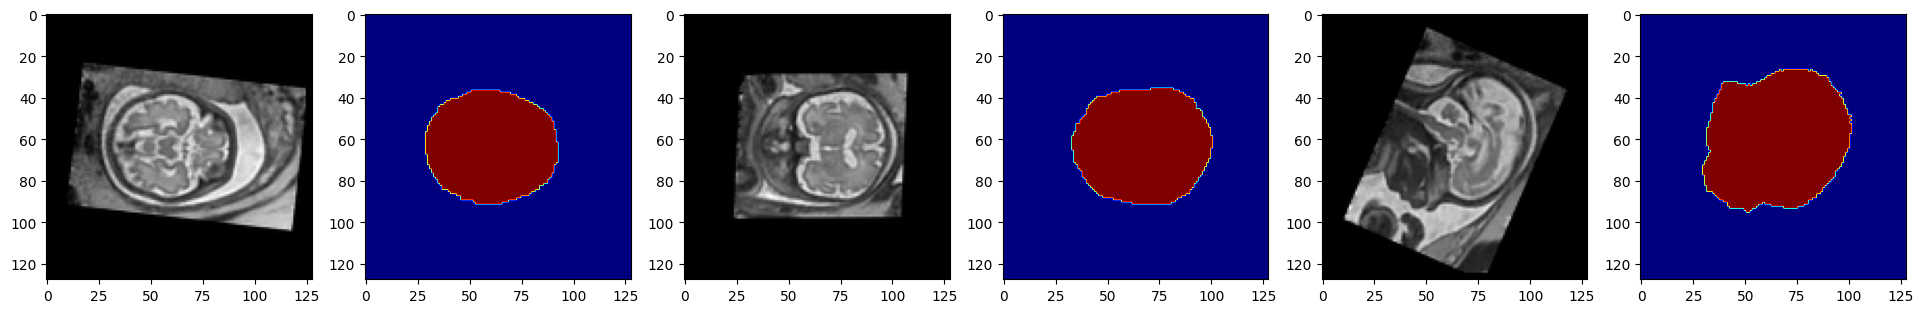

1 335-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


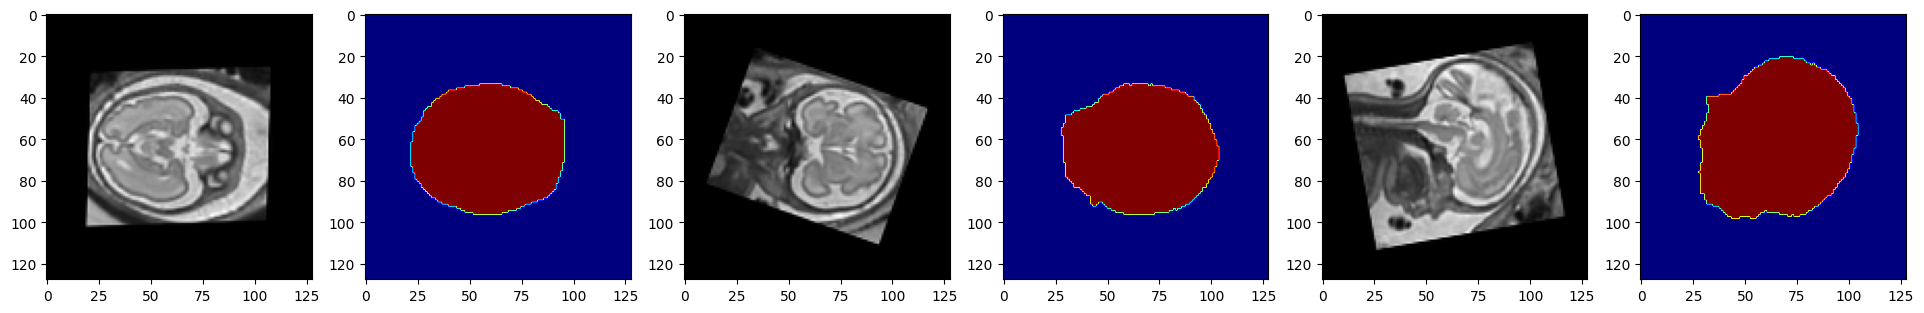

2 426-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


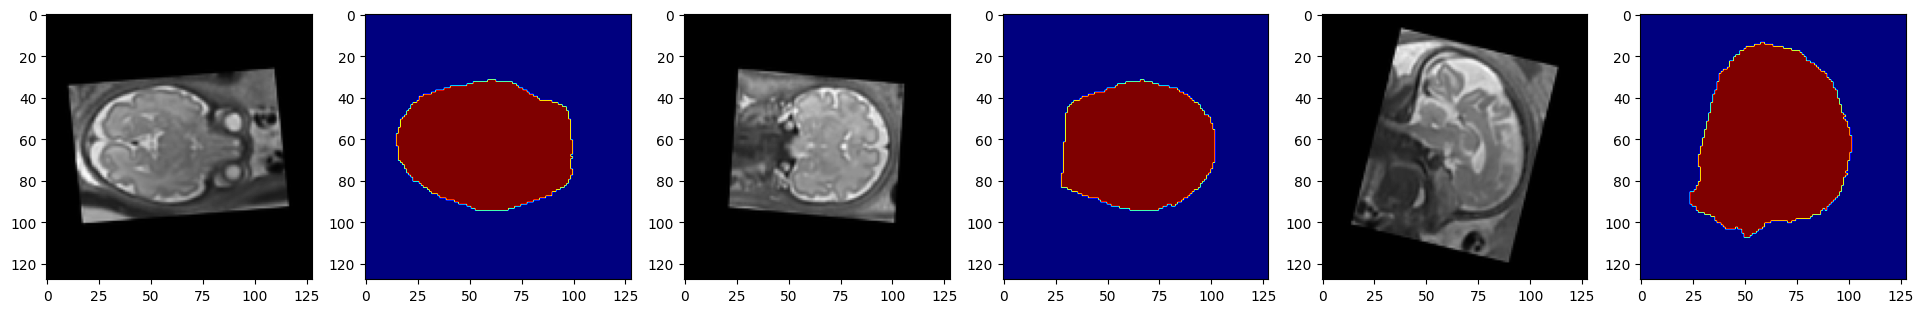

3 342-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


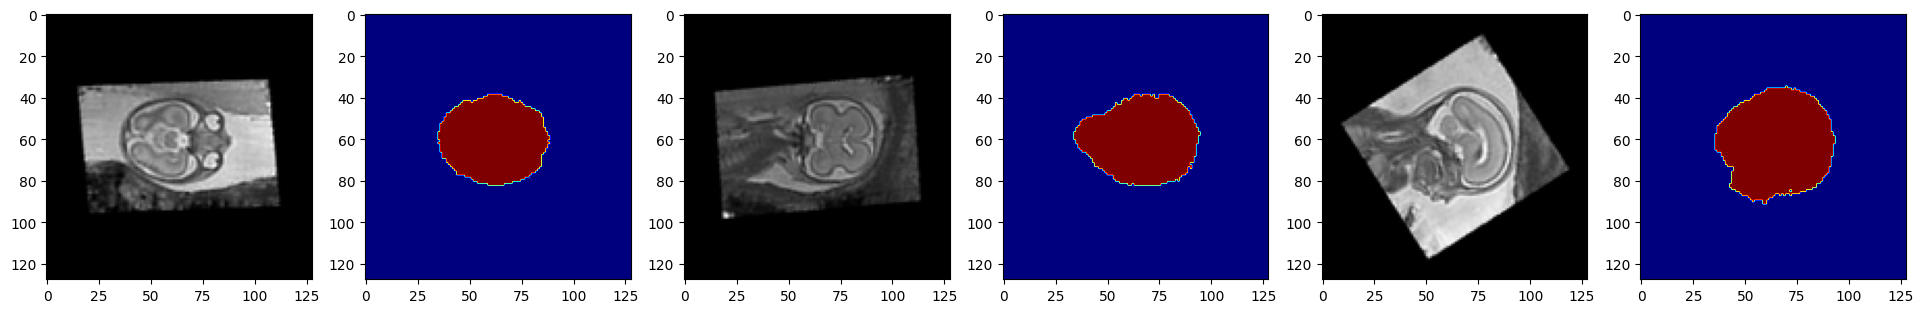

4 435-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


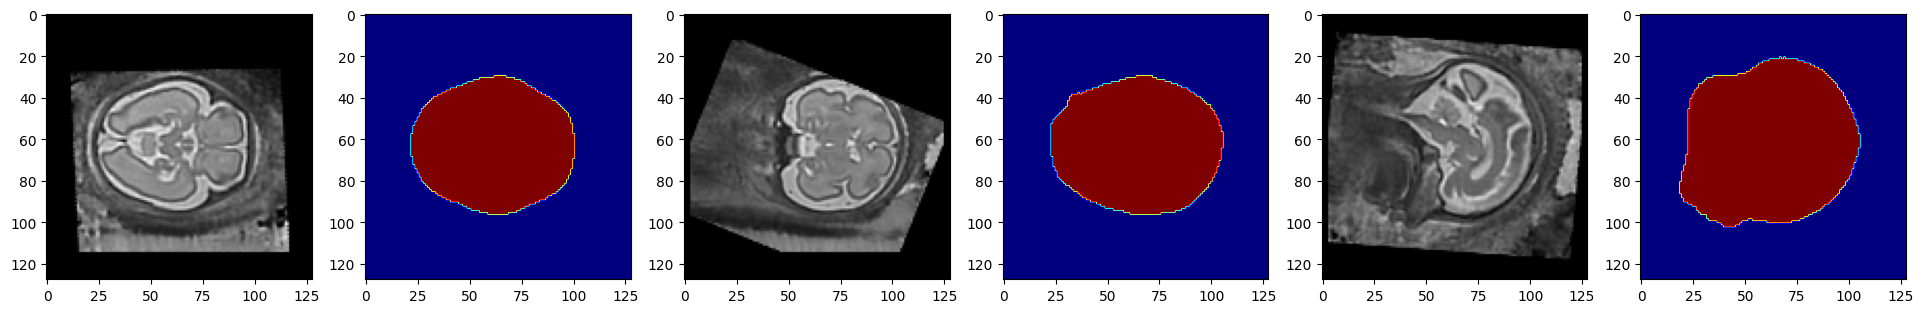

5 hist-136-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


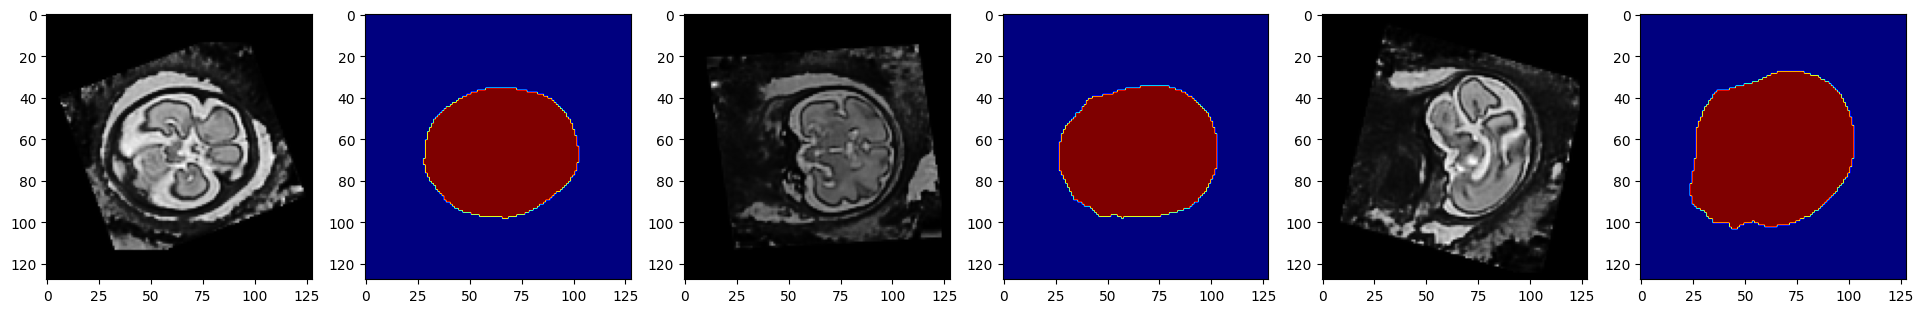

6 hist-214-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


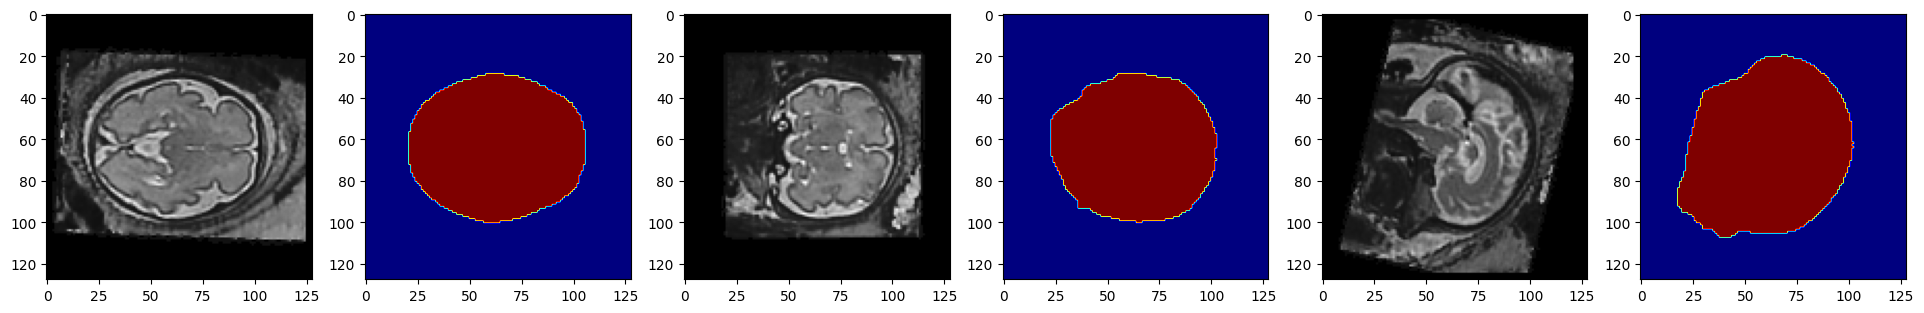

7 hist-236-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


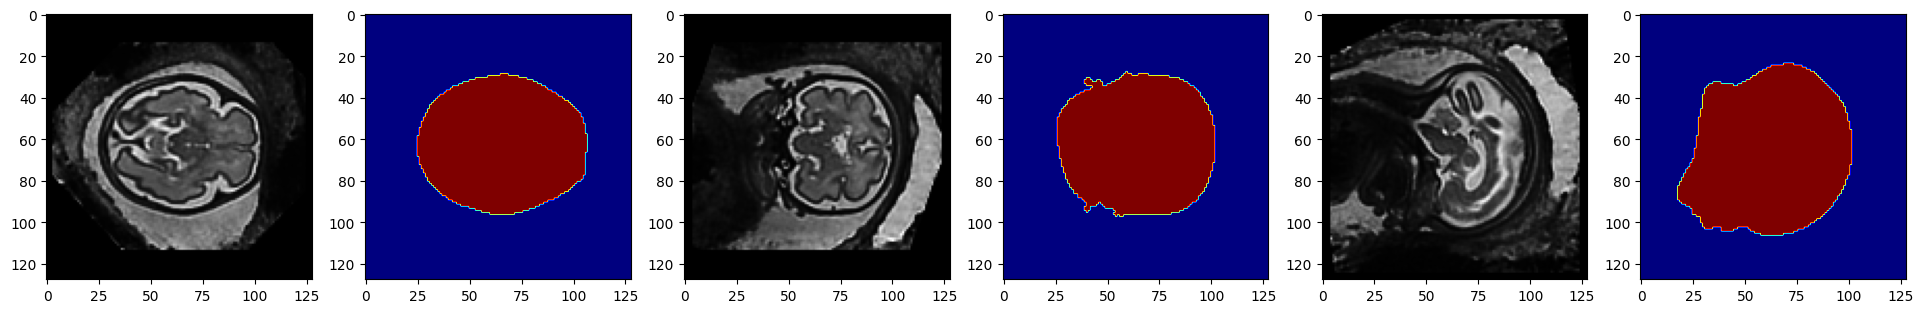

8 hist-253-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


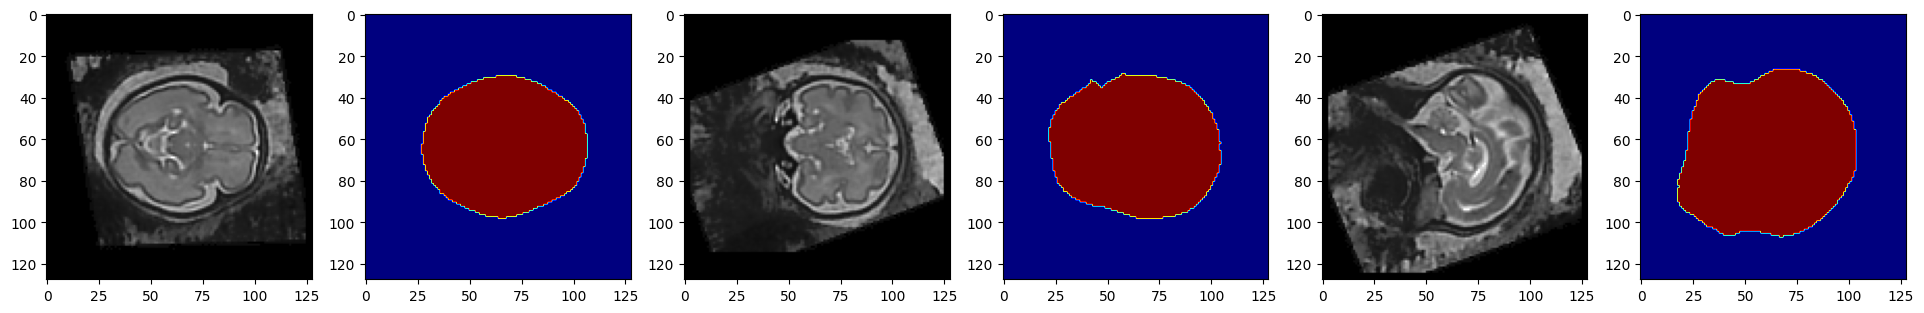

9 hist-275-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


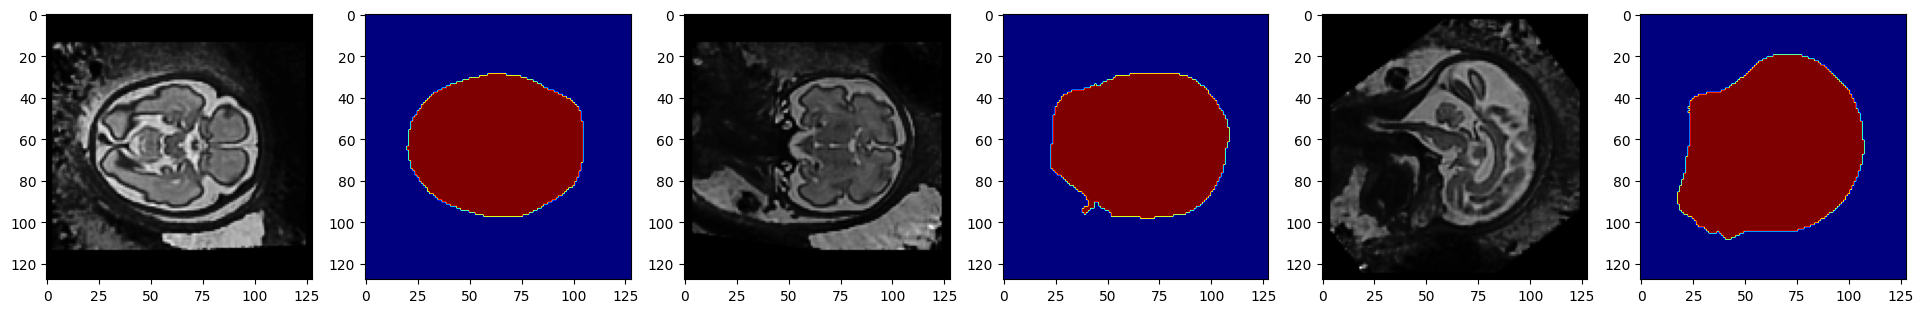

10 hist-292-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


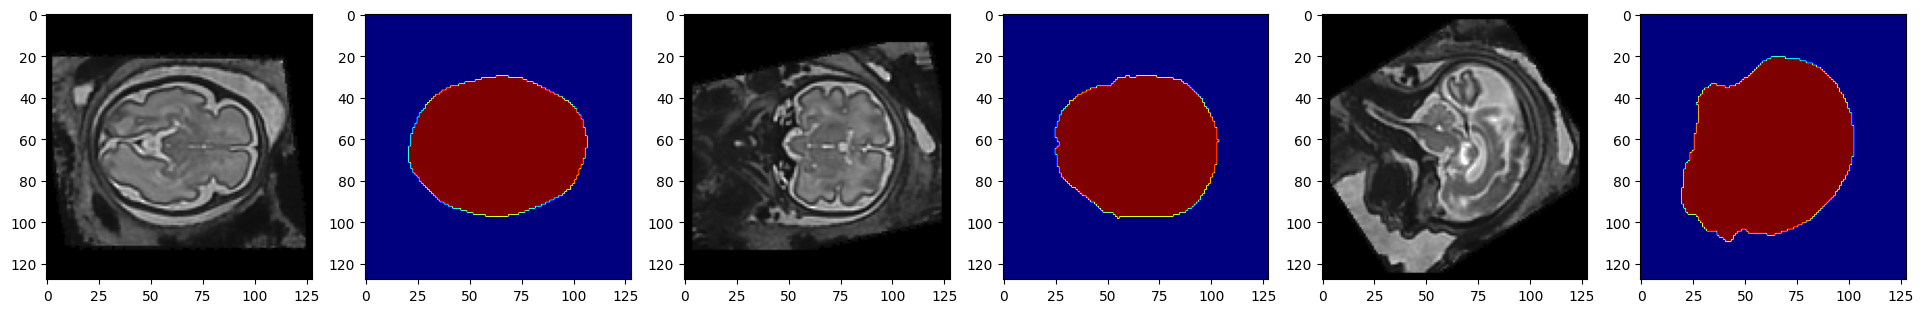

11 hist-355-img.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


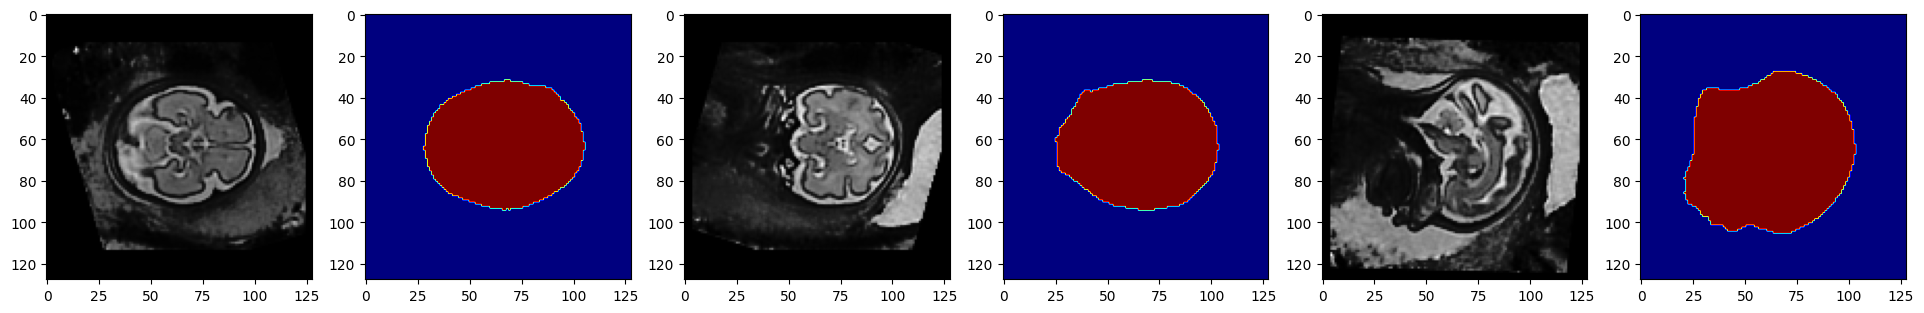

In [ ]:
print("Validation:")
print("\n")

s=round(img_dim/2)

for x in range(len(val_files)):

  case_num = x
  img_name = val_files[case_num]["label"]
  label_name = val_files[case_num]["label"]
  case_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  case_in=val_ds[case_num]
  img = case_in["image"]
  label = case_in["label"]
  img_shape = img.shape
  label_shape = label.shape

  print(x, case_name, img_shape, label_shape)
  plt.figure("image", (24, 4))
  plt.subplot(1, 6, 1)
  plt.imshow(img[0, :, :, s], cmap="gray")
  plt.subplot(1, 6, 2)
  plt.imshow(label[0, :, :, s], cmap="jet")
  plt.subplot(1, 6, 3)
  plt.imshow(img[0, :, s, :], cmap="gray")
  plt.subplot(1, 6, 4)
  plt.imshow(label[0, :, s, :], cmap="jet")
  plt.subplot(1, 6, 5)
  plt.imshow(img[0, s, :, :], cmap="gray")
  plt.subplot(1, 6, 6)
  plt.imshow(label[0, s, :, :], cmap="jet")
  plt.show()




In [ ]:
# define the network using MONAI

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = UNet(spatial_dims=3,
in_channels=1,
out_channels=class_num,
channels=(32, 64, 128, 256, 512),
strides=(2,2,2,2),
kernel_size=3,
up_kernel_size=3,
num_res_units=1,
act='PRELU',
norm='INSTANCE',
dropout=0.5).to(device)


loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)



In [ ]:
# #
import time

def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (img_dim, img_dim, img_dim), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best,epochs_without_improvement):
    model.train()
    epoch_loss = 0
    step = 0
    total_training_time = 0
    patience = 10
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    # Initialize variables for early stopping
    start_time = time.time()  # Record the start time
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        # Check if early stopping condition is met
        if epochs_without_improvement >= patience:
          print("Early stopping: Model has not improved for {} epochs.".format(patience))
          epoch_iterator.close()
          epoch_iterator_val.close()
          break

        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values_unetnoaug.append(epoch_loss)
            metric_values_unetnoaug.append(dice_val)

            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                epochs_without_improvement = 0 # Reset patience counter
                print("Patience Counter has Been Reset")
                torch.save(
                    model.state_dict(), os.path.join(root_dir, (roi_type+"unet_noaug_best_metric_model.pth"))
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
                print("Epochs Without Improvement:{}".format(epochs_without_improvement))

            else:
              epochs_without_improvement += 1
              torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"unet_noaug_latest_metric_model.pth")))
              print("Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val))
              print("+1 Added to Patience Counter")
              print("Epochs Without Improvement:{}".format(epochs_without_improvement))



        global_step += 1

    # Training loop has completed, calculate the total training time
    end_time = time.time()
    epoch_iterator.close()

    total_training_time += end_time - start_time
    total_training_time_minutes = total_training_time / 60
    print(f"\nTotal Training Time: {total_training_time_minutes:.2f} minutes")
    print(f"Global step: {global_step}, Eval num: {eval_num}, Max iterations: {max_iterations}")
    return global_step, dice_val_best, global_step_best, epochs_without_improvement





In [ ]:
max_iterations = 30000
eval_num = 200
post_label = AsDiscrete(to_onehot=class_num)
post_pred = AsDiscrete(argmax=True, to_onehot=class_num)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epochs_without_improvement = 0
epoch_loss_values_unetnoaug = []
metric_values_unetnoaug = []

In [ ]:
# run training

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best,epochs_without_improvement = train(
        global_step, train_loader, dice_val_best, global_step_best,epochs_without_improvement
    )

Training (81 / 30000 Steps) (loss=1.04079): 100%|██████████| 82/82 [00:34<00:00,  2.38it/s]



Total Training Time: 0.57 minutes
Global step: 82, Eval num: 200, Max iterations: 30000


Training (163 / 30000 Steps) (loss=0.82539): 100%|██████████| 82/82 [00:16<00:00,  5.11it/s]



Total Training Time: 0.27 minutes
Global step: 164, Eval num: 200, Max iterations: 30000


Validate (164 / 10 Steps) (dice=0.83237): 100%|██████████| 12/12 [00:01<00:00,  6.41it/s]


Patience Counter has Been Reset


Training (201 / 30000 Steps) (loss=0.63159):  46%|████▋     | 38/82 [00:10<00:34,  1.28it/s]

Model Was Saved ! Current Best Avg. Dice: 0.8047727545102438 Current Avg. Dice: 0.8047727545102438
Epochs Without Improvement:0


Training (245 / 30000 Steps) (loss=0.56456): 100%|██████████| 82/82 [00:18<00:00,  4.44it/s]



Total Training Time: 0.31 minutes
Global step: 246, Eval num: 200, Max iterations: 30000


Training (327 / 30000 Steps) (loss=0.79282): 100%|██████████| 82/82 [00:16<00:00,  5.01it/s]



Total Training Time: 0.27 minutes
Global step: 328, Eval num: 200, Max iterations: 30000


Training (400 / 30000 Steps) (loss=0.51532):  89%|████████▉ | 73/82 [00:17<00:07,  1.28it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.8648322025934855 Current Avg. Dice: 0.8648322025934855
Epochs Without Improvement:0


Training (409 / 30000 Steps) (loss=0.65434): 100%|██████████| 82/82 [00:18<00:00,  4.33it/s]



Total Training Time: 0.32 minutes
Global step: 410, Eval num: 200, Max iterations: 30000


Training (491 / 30000 Steps) (loss=0.51563): 100%|██████████| 82/82 [00:16<00:00,  4.85it/s]



Total Training Time: 0.28 minutes
Global step: 492, Eval num: 200, Max iterations: 30000


Training (573 / 30000 Steps) (loss=0.38991): 100%|██████████| 82/82 [00:16<00:00,  4.89it/s]



Total Training Time: 0.28 minutes
Global step: 574, Eval num: 200, Max iterations: 30000


Training (600 / 30000 Steps) (loss=0.40782):  33%|███▎      | 27/82 [00:07<00:42,  1.28it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.8682554513216019 Current Avg. Dice: 0.8682554513216019
Epochs Without Improvement:0


Training (655 / 30000 Steps) (loss=0.22591): 100%|██████████| 82/82 [00:18<00:00,  4.53it/s]



Total Training Time: 0.30 minutes
Global step: 656, Eval num: 200, Max iterations: 30000


Training (737 / 30000 Steps) (loss=0.44976): 100%|██████████| 82/82 [00:16<00:00,  4.82it/s]



Total Training Time: 0.28 minutes
Global step: 738, Eval num: 200, Max iterations: 30000


Training (800 / 30000 Steps) (loss=0.43903):  77%|███████▋  | 63/82 [00:14<00:15,  1.20it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9069470266501108 Current Avg. Dice: 0.9069470266501108
Epochs Without Improvement:0


Training (819 / 30000 Steps) (loss=0.21416): 100%|██████████| 82/82 [00:18<00:00,  4.52it/s]



Total Training Time: 0.30 minutes
Global step: 820, Eval num: 200, Max iterations: 30000


Training (901 / 30000 Steps) (loss=0.29255): 100%|██████████| 82/82 [00:16<00:00,  4.92it/s]



Total Training Time: 0.28 minutes
Global step: 902, Eval num: 200, Max iterations: 30000


Training (983 / 30000 Steps) (loss=0.26405): 100%|██████████| 82/82 [00:16<00:00,  4.87it/s]



Total Training Time: 0.28 minutes
Global step: 984, Eval num: 200, Max iterations: 30000


Training (1001 / 30000 Steps) (loss=0.26691):  22%|██▏       | 18/82 [00:07<00:48,  1.31it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9069470266501108 Current Avg. Dice: 0.8992433945337931
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (1065 / 30000 Steps) (loss=0.24139): 100%|██████████| 82/82 [00:19<00:00,  4.26it/s]



Total Training Time: 0.32 minutes
Global step: 1066, Eval num: 200, Max iterations: 30000


Training (1147 / 30000 Steps) (loss=0.21888): 100%|██████████| 82/82 [00:17<00:00,  4.75it/s]



Total Training Time: 0.29 minutes
Global step: 1148, Eval num: 200, Max iterations: 30000


Training (1200 / 30000 Steps) (loss=0.22351):  65%|██████▍   | 53/82 [00:13<00:23,  1.25it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9202117075522741 Current Avg. Dice: 0.9202117075522741
Epochs Without Improvement:0


Training (1229 / 30000 Steps) (loss=0.31606): 100%|██████████| 82/82 [00:18<00:00,  4.49it/s]



Total Training Time: 0.30 minutes
Global step: 1230, Eval num: 200, Max iterations: 30000


Training (1311 / 30000 Steps) (loss=0.29156): 100%|██████████| 82/82 [00:16<00:00,  4.96it/s]



Total Training Time: 0.28 minutes
Global step: 1312, Eval num: 200, Max iterations: 30000


Training (1393 / 30000 Steps) (loss=0.16123): 100%|██████████| 82/82 [00:16<00:00,  4.98it/s]



Total Training Time: 0.27 minutes
Global step: 1394, Eval num: 200, Max iterations: 30000


Training (1400 / 30000 Steps) (loss=0.20125):   9%|▊         | 7/82 [00:04<01:08,  1.10it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9232534269491831 Current Avg. Dice: 0.9232534269491831
Epochs Without Improvement:0


Training (1475 / 30000 Steps) (loss=0.18997): 100%|██████████| 82/82 [00:18<00:00,  4.39it/s]



Total Training Time: 0.31 minutes
Global step: 1476, Eval num: 200, Max iterations: 30000


Training (1557 / 30000 Steps) (loss=0.16805): 100%|██████████| 82/82 [00:16<00:00,  4.96it/s]



Total Training Time: 0.28 minutes
Global step: 1558, Eval num: 200, Max iterations: 30000


Training (1600 / 30000 Steps) (loss=0.16183):  52%|█████▏    | 43/82 [00:11<00:31,  1.22it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9270692964394888 Current Avg. Dice: 0.9270692964394888
Epochs Without Improvement:0


Training (1639 / 30000 Steps) (loss=0.16868): 100%|██████████| 82/82 [00:17<00:00,  4.57it/s]



Total Training Time: 0.30 minutes
Global step: 1640, Eval num: 200, Max iterations: 30000


Training (1721 / 30000 Steps) (loss=0.15706): 100%|██████████| 82/82 [00:16<00:00,  4.96it/s]



Total Training Time: 0.28 minutes
Global step: 1722, Eval num: 200, Max iterations: 30000


Training (1801 / 30000 Steps) (loss=0.15178):  98%|█████████▊| 80/82 [00:17<00:00,  2.00it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9270692964394888 Current Avg. Dice: 0.9265859524408976
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (1803 / 30000 Steps) (loss=0.16082): 100%|██████████| 82/82 [00:18<00:00,  4.55it/s]



Total Training Time: 0.30 minutes
Global step: 1804, Eval num: 200, Max iterations: 30000


Training (1885 / 30000 Steps) (loss=0.22416): 100%|██████████| 82/82 [00:16<00:00,  4.83it/s]



Total Training Time: 0.28 minutes
Global step: 1886, Eval num: 200, Max iterations: 30000


Training (1967 / 30000 Steps) (loss=0.20467): 100%|██████████| 82/82 [00:16<00:00,  5.02it/s]



Total Training Time: 0.27 minutes
Global step: 1968, Eval num: 200, Max iterations: 30000


Training (2000 / 30000 Steps) (loss=0.37271):  40%|████      | 33/82 [00:09<00:39,  1.23it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9370314578215281 Current Avg. Dice: 0.9370314578215281
Epochs Without Improvement:0


Training (2049 / 30000 Steps) (loss=0.10217): 100%|██████████| 82/82 [00:18<00:00,  4.45it/s]



Total Training Time: 0.31 minutes
Global step: 2050, Eval num: 200, Max iterations: 30000


Training (2131 / 30000 Steps) (loss=0.22890): 100%|██████████| 82/82 [00:16<00:00,  4.96it/s]



Total Training Time: 0.28 minutes
Global step: 2132, Eval num: 200, Max iterations: 30000


Training (2201 / 30000 Steps) (loss=0.22081):  85%|████████▌ | 70/82 [00:16<00:07,  1.69it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9370314578215281 Current Avg. Dice: 0.9337751120328903
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (2213 / 30000 Steps) (loss=0.09259): 100%|██████████| 82/82 [00:18<00:00,  4.52it/s]



Total Training Time: 0.30 minutes
Global step: 2214, Eval num: 200, Max iterations: 30000


Training (2295 / 30000 Steps) (loss=0.13551): 100%|██████████| 82/82 [00:17<00:00,  4.73it/s]



Total Training Time: 0.29 minutes
Global step: 2296, Eval num: 200, Max iterations: 30000


Training (2377 / 30000 Steps) (loss=0.12740): 100%|██████████| 82/82 [00:16<00:00,  4.94it/s]



Total Training Time: 0.28 minutes
Global step: 2378, Eval num: 200, Max iterations: 30000


Training (2400 / 30000 Steps) (loss=0.22388):  28%|██▊       | 23/82 [00:07<00:46,  1.26it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9403681109348933 Current Avg. Dice: 0.9403681109348933
Epochs Without Improvement:0


Training (2459 / 30000 Steps) (loss=0.10665): 100%|██████████| 82/82 [00:18<00:00,  4.54it/s]



Total Training Time: 0.30 minutes
Global step: 2460, Eval num: 200, Max iterations: 30000


Training (2541 / 30000 Steps) (loss=0.10886): 100%|██████████| 82/82 [00:16<00:00,  4.92it/s]



Total Training Time: 0.28 minutes
Global step: 2542, Eval num: 200, Max iterations: 30000


Training (2601 / 30000 Steps) (loss=0.12177):  73%|███████▎  | 60/82 [00:14<00:12,  1.72it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9403681109348933 Current Avg. Dice: 0.9230092217524847
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (2623 / 30000 Steps) (loss=0.10429): 100%|██████████| 82/82 [00:17<00:00,  4.59it/s]



Total Training Time: 0.30 minutes
Global step: 2624, Eval num: 200, Max iterations: 30000


Training (2705 / 30000 Steps) (loss=0.13468): 100%|██████████| 82/82 [00:16<00:00,  4.89it/s]



Total Training Time: 0.28 minutes
Global step: 2706, Eval num: 200, Max iterations: 30000


Training (2787 / 30000 Steps) (loss=0.10034): 100%|██████████| 82/82 [00:16<00:00,  4.96it/s]



Total Training Time: 0.28 minutes
Global step: 2788, Eval num: 200, Max iterations: 30000


Training (2801 / 30000 Steps) (loss=0.27424):  17%|█▋        | 14/82 [00:05<00:40,  1.69it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9403681109348933 Current Avg. Dice: 0.9311106155316035
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (2869 / 30000 Steps) (loss=0.26126): 100%|██████████| 82/82 [00:18<00:00,  4.55it/s]



Total Training Time: 0.30 minutes
Global step: 2870, Eval num: 200, Max iterations: 30000


Training (2951 / 30000 Steps) (loss=0.10003): 100%|██████████| 82/82 [00:16<00:00,  4.95it/s]



Total Training Time: 0.28 minutes
Global step: 2952, Eval num: 200, Max iterations: 30000


Training (3000 / 30000 Steps) (loss=0.11239):  60%|█████▉    | 49/82 [00:12<00:28,  1.18it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9457156757513682 Current Avg. Dice: 0.9457156757513682
Epochs Without Improvement:0


Training (3033 / 30000 Steps) (loss=0.07950): 100%|██████████| 82/82 [00:18<00:00,  4.36it/s]



Total Training Time: 0.31 minutes
Global step: 3034, Eval num: 200, Max iterations: 30000


Training (3115 / 30000 Steps) (loss=0.11631): 100%|██████████| 82/82 [00:16<00:00,  4.97it/s]



Total Training Time: 0.28 minutes
Global step: 3116, Eval num: 200, Max iterations: 30000


Training (3197 / 30000 Steps) (loss=0.13991): 100%|██████████| 82/82 [00:16<00:00,  4.95it/s]



Total Training Time: 0.28 minutes
Global step: 3198, Eval num: 200, Max iterations: 30000


Training (3201 / 30000 Steps) (loss=0.09446):   5%|▍         | 4/82 [00:03<01:04,  1.20it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9457156757513682 Current Avg. Dice: 0.9429527471462885
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (3279 / 30000 Steps) (loss=0.10964): 100%|██████████| 82/82 [00:17<00:00,  4.58it/s]



Total Training Time: 0.30 minutes
Global step: 3280, Eval num: 200, Max iterations: 30000


Training (3361 / 30000 Steps) (loss=0.10836): 100%|██████████| 82/82 [00:16<00:00,  4.93it/s]



Total Training Time: 0.28 minutes
Global step: 3362, Eval num: 200, Max iterations: 30000


Training (3400 / 30000 Steps) (loss=0.08542):  48%|████▊     | 39/82 [00:10<00:33,  1.30it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9551653116941452 Current Avg. Dice: 0.9551653116941452
Epochs Without Improvement:0


Training (3443 / 30000 Steps) (loss=0.09342): 100%|██████████| 82/82 [00:18<00:00,  4.51it/s]



Total Training Time: 0.30 minutes
Global step: 3444, Eval num: 200, Max iterations: 30000


Training (3525 / 30000 Steps) (loss=0.13681): 100%|██████████| 82/82 [00:16<00:00,  5.02it/s]



Total Training Time: 0.27 minutes
Global step: 3526, Eval num: 200, Max iterations: 30000


Training (3600 / 30000 Steps) (loss=0.08892):  91%|█████████▏| 75/82 [00:17<00:05,  1.36it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9596327741940817 Current Avg. Dice: 0.9596327741940817
Epochs Without Improvement:0


Training (3607 / 30000 Steps) (loss=0.11665): 100%|██████████| 82/82 [00:18<00:00,  4.50it/s]



Total Training Time: 0.30 minutes
Global step: 3608, Eval num: 200, Max iterations: 30000


Training (3689 / 30000 Steps) (loss=0.10068): 100%|██████████| 82/82 [00:16<00:00,  5.00it/s]



Total Training Time: 0.27 minutes
Global step: 3690, Eval num: 200, Max iterations: 30000


Training (3771 / 30000 Steps) (loss=0.07740): 100%|██████████| 82/82 [00:16<00:00,  4.93it/s]



Total Training Time: 0.28 minutes
Global step: 3772, Eval num: 200, Max iterations: 30000


Training (3800 / 30000 Steps) (loss=0.14747):  35%|███▌      | 29/82 [00:08<00:40,  1.30it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9599267741044363 Current Avg. Dice: 0.9599267741044363
Epochs Without Improvement:0


Training (3853 / 30000 Steps) (loss=0.06114): 100%|██████████| 82/82 [00:18<00:00,  4.54it/s]



Total Training Time: 0.30 minutes
Global step: 3854, Eval num: 200, Max iterations: 30000


Training (3935 / 30000 Steps) (loss=0.08785): 100%|██████████| 82/82 [00:16<00:00,  4.97it/s]



Total Training Time: 0.27 minutes
Global step: 3936, Eval num: 200, Max iterations: 30000


Training (4000 / 30000 Steps) (loss=0.12963):  79%|███████▉  | 65/82 [00:15<00:14,  1.20it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9647731433312098 Current Avg. Dice: 0.9647731433312098
Epochs Without Improvement:0


Training (4017 / 30000 Steps) (loss=0.07928): 100%|██████████| 82/82 [00:18<00:00,  4.52it/s]



Total Training Time: 0.30 minutes
Global step: 4018, Eval num: 200, Max iterations: 30000


Training (4099 / 30000 Steps) (loss=0.06912): 100%|██████████| 82/82 [00:16<00:00,  5.01it/s]



Total Training Time: 0.27 minutes
Global step: 4100, Eval num: 200, Max iterations: 30000


Training (4181 / 30000 Steps) (loss=0.07079): 100%|██████████| 82/82 [00:16<00:00,  4.99it/s]



Total Training Time: 0.27 minutes
Global step: 4182, Eval num: 200, Max iterations: 30000


Training (4201 / 30000 Steps) (loss=0.05423):  24%|██▍       | 20/82 [00:07<00:44,  1.41it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9647731433312098 Current Avg. Dice: 0.9604546030362447
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (4263 / 30000 Steps) (loss=0.04151): 100%|██████████| 82/82 [00:18<00:00,  4.41it/s]



Total Training Time: 0.31 minutes
Global step: 4264, Eval num: 200, Max iterations: 30000


Training (4345 / 30000 Steps) (loss=0.08932): 100%|██████████| 82/82 [00:16<00:00,  4.96it/s]



Total Training Time: 0.28 minutes
Global step: 4346, Eval num: 200, Max iterations: 30000


Training (4400 / 30000 Steps) (loss=0.08764):  67%|██████▋   | 55/82 [00:13<00:20,  1.31it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9653742710749308 Current Avg. Dice: 0.9653742710749308
Epochs Without Improvement:0


Training (4427 / 30000 Steps) (loss=0.05450): 100%|██████████| 82/82 [00:17<00:00,  4.56it/s]



Total Training Time: 0.30 minutes
Global step: 4428, Eval num: 200, Max iterations: 30000


Training (4509 / 30000 Steps) (loss=0.07577): 100%|██████████| 82/82 [00:16<00:00,  4.97it/s]



Total Training Time: 0.28 minutes
Global step: 4510, Eval num: 200, Max iterations: 30000


Training (4591 / 30000 Steps) (loss=0.08960): 100%|██████████| 82/82 [00:16<00:00,  4.88it/s]



Total Training Time: 0.28 minutes
Global step: 4592, Eval num: 200, Max iterations: 30000


Training (4601 / 30000 Steps) (loss=0.05316):  12%|█▏        | 10/82 [00:04<00:45,  1.58it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9653742710749308 Current Avg. Dice: 0.9633301099141439
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (4673 / 30000 Steps) (loss=0.06039): 100%|██████████| 82/82 [00:18<00:00,  4.53it/s]



Total Training Time: 0.30 minutes
Global step: 4674, Eval num: 200, Max iterations: 30000


Training (4755 / 30000 Steps) (loss=0.06574): 100%|██████████| 82/82 [00:16<00:00,  5.01it/s]



Total Training Time: 0.27 minutes
Global step: 4756, Eval num: 200, Max iterations: 30000


Training (4800 / 30000 Steps) (loss=0.14978):  55%|█████▍    | 45/82 [00:11<00:30,  1.22it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9664478103319804 Current Avg. Dice: 0.9664478103319804
Epochs Without Improvement:0


Training (4837 / 30000 Steps) (loss=0.03985): 100%|██████████| 82/82 [00:18<00:00,  4.54it/s]



Total Training Time: 0.30 minutes
Global step: 4838, Eval num: 200, Max iterations: 30000


Training (4919 / 30000 Steps) (loss=0.06079): 100%|██████████| 82/82 [00:16<00:00,  4.98it/s]



Total Training Time: 0.27 minutes
Global step: 4920, Eval num: 200, Max iterations: 30000


Training (5001 / 30000 Steps) (loss=0.09733): 100%|██████████| 82/82 [00:18<00:00,  2.09it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9664478103319804 Current Avg. Dice: 0.9663390964269638
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (5001 / 30000 Steps) (loss=0.09733): 100%|██████████| 82/82 [00:18<00:00,  4.42it/s]



Total Training Time: 0.31 minutes
Global step: 5002, Eval num: 200, Max iterations: 30000


Training (5083 / 30000 Steps) (loss=0.08241): 100%|██████████| 82/82 [00:16<00:00,  4.98it/s]



Total Training Time: 0.27 minutes
Global step: 5084, Eval num: 200, Max iterations: 30000


Training (5165 / 30000 Steps) (loss=0.07790): 100%|██████████| 82/82 [00:16<00:00,  5.08it/s]



Total Training Time: 0.27 minutes
Global step: 5166, Eval num: 200, Max iterations: 30000


Training (5201 / 30000 Steps) (loss=0.05779):  44%|████▍     | 36/82 [00:09<00:27,  1.67it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9664478103319804 Current Avg. Dice: 0.958215336004893
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (5247 / 30000 Steps) (loss=0.09642): 100%|██████████| 82/82 [00:18<00:00,  4.53it/s]



Total Training Time: 0.30 minutes
Global step: 5248, Eval num: 200, Max iterations: 30000


Training (5329 / 30000 Steps) (loss=0.08259): 100%|██████████| 82/82 [00:16<00:00,  5.02it/s]



Total Training Time: 0.27 minutes
Global step: 5330, Eval num: 200, Max iterations: 30000


Training (5401 / 30000 Steps) (loss=0.04731):  88%|████████▊ | 72/82 [00:17<00:05,  1.71it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9664478103319804 Current Avg. Dice: 0.9648774017890295
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (5411 / 30000 Steps) (loss=0.07106): 100%|██████████| 82/82 [00:18<00:00,  4.40it/s]



Total Training Time: 0.31 minutes
Global step: 5412, Eval num: 200, Max iterations: 30000


Training (5493 / 30000 Steps) (loss=0.06412): 100%|██████████| 82/82 [00:16<00:00,  4.98it/s]



Total Training Time: 0.27 minutes
Global step: 5494, Eval num: 200, Max iterations: 30000


Training (5575 / 30000 Steps) (loss=0.06638): 100%|██████████| 82/82 [00:16<00:00,  4.97it/s]



Total Training Time: 0.28 minutes
Global step: 5576, Eval num: 200, Max iterations: 30000


Training (5600 / 30000 Steps) (loss=0.10140):  30%|███       | 25/82 [00:07<00:45,  1.26it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9722014913956324 Current Avg. Dice: 0.9722014913956324
Epochs Without Improvement:0


Training (5657 / 30000 Steps) (loss=0.06649): 100%|██████████| 82/82 [00:18<00:00,  4.54it/s]



Total Training Time: 0.30 minutes
Global step: 5658, Eval num: 200, Max iterations: 30000


Training (5739 / 30000 Steps) (loss=0.06872): 100%|██████████| 82/82 [00:16<00:00,  4.91it/s]



Total Training Time: 0.28 minutes
Global step: 5740, Eval num: 200, Max iterations: 30000


Training (5801 / 30000 Steps) (loss=0.04135):  76%|███████▌  | 62/82 [00:14<00:11,  1.71it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9722014913956324 Current Avg. Dice: 0.9684561938047409
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (5821 / 30000 Steps) (loss=0.03813): 100%|██████████| 82/82 [00:17<00:00,  4.58it/s]



Total Training Time: 0.30 minutes
Global step: 5822, Eval num: 200, Max iterations: 30000


Training (5903 / 30000 Steps) (loss=0.06712): 100%|██████████| 82/82 [00:16<00:00,  4.95it/s]



Total Training Time: 0.28 minutes
Global step: 5904, Eval num: 200, Max iterations: 30000


Training (5985 / 30000 Steps) (loss=0.06353): 100%|██████████| 82/82 [00:16<00:00,  4.97it/s]



Total Training Time: 0.28 minutes
Global step: 5986, Eval num: 200, Max iterations: 30000


Training (6000 / 30000 Steps) (loss=0.10225):  18%|█▊        | 15/82 [00:05<00:51,  1.29it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9726513822873434 Current Avg. Dice: 0.9726513822873434
Epochs Without Improvement:0


Training (6067 / 30000 Steps) (loss=0.14776): 100%|██████████| 82/82 [00:17<00:00,  4.58it/s]



Total Training Time: 0.30 minutes
Global step: 6068, Eval num: 200, Max iterations: 30000


Training (6149 / 30000 Steps) (loss=0.07216): 100%|██████████| 82/82 [00:16<00:00,  4.88it/s]



Total Training Time: 0.28 minutes
Global step: 6150, Eval num: 200, Max iterations: 30000


Training (6200 / 30000 Steps) (loss=0.07467):  62%|██████▏   | 51/82 [00:12<00:24,  1.27it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9739922483762106 Current Avg. Dice: 0.9739922483762106
Epochs Without Improvement:0


Training (6231 / 30000 Steps) (loss=0.03714): 100%|██████████| 82/82 [00:18<00:00,  4.54it/s]



Total Training Time: 0.30 minutes
Global step: 6232, Eval num: 200, Max iterations: 30000


Training (6313 / 30000 Steps) (loss=0.07227): 100%|██████████| 82/82 [00:16<00:00,  5.02it/s]



Total Training Time: 0.27 minutes
Global step: 6314, Eval num: 200, Max iterations: 30000


Training (6395 / 30000 Steps) (loss=0.06723): 100%|██████████| 82/82 [00:16<00:00,  5.02it/s]



Total Training Time: 0.27 minutes
Global step: 6396, Eval num: 200, Max iterations: 30000


Training (6401 / 30000 Steps) (loss=0.04595):   7%|▋         | 6/82 [00:03<00:53,  1.41it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9739922483762106 Current Avg. Dice: 0.9739142258961996
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (6477 / 30000 Steps) (loss=0.04649): 100%|██████████| 82/82 [00:17<00:00,  4.59it/s]



Total Training Time: 0.30 minutes
Global step: 6478, Eval num: 200, Max iterations: 30000


Training (6559 / 30000 Steps) (loss=0.09624): 100%|██████████| 82/82 [00:17<00:00,  4.80it/s]



Total Training Time: 0.28 minutes
Global step: 6560, Eval num: 200, Max iterations: 30000


Training (6601 / 30000 Steps) (loss=0.03041):  51%|█████     | 42/82 [00:10<00:23,  1.72it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9739922483762106 Current Avg. Dice: 0.9716804325580597
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (6641 / 30000 Steps) (loss=0.08026): 100%|██████████| 82/82 [00:17<00:00,  4.60it/s]



Total Training Time: 0.30 minutes
Global step: 6642, Eval num: 200, Max iterations: 30000


Training (6723 / 30000 Steps) (loss=0.04971): 100%|██████████| 82/82 [00:16<00:00,  4.91it/s]



Total Training Time: 0.28 minutes
Global step: 6724, Eval num: 200, Max iterations: 30000


Training (6801 / 30000 Steps) (loss=0.08997):  95%|█████████▌| 78/82 [00:17<00:02,  1.88it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9739922483762106 Current Avg. Dice: 0.9737325310707092
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (6805 / 30000 Steps) (loss=0.04103): 100%|██████████| 82/82 [00:17<00:00,  4.62it/s]



Total Training Time: 0.30 minutes
Global step: 6806, Eval num: 200, Max iterations: 30000


Training (6887 / 30000 Steps) (loss=0.07573): 100%|██████████| 82/82 [00:17<00:00,  4.80it/s]



Total Training Time: 0.29 minutes
Global step: 6888, Eval num: 200, Max iterations: 30000


Training (6969 / 30000 Steps) (loss=0.03978): 100%|██████████| 82/82 [00:16<00:00,  4.95it/s]



Total Training Time: 0.28 minutes
Global step: 6970, Eval num: 200, Max iterations: 30000


Training (7000 / 30000 Steps) (loss=0.04667):  38%|███▊      | 31/82 [00:08<00:40,  1.26it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.974021335442861 Current Avg. Dice: 0.974021335442861
Epochs Without Improvement:0


Training (7051 / 30000 Steps) (loss=0.03224): 100%|██████████| 82/82 [00:17<00:00,  4.56it/s]



Total Training Time: 0.30 minutes
Global step: 7052, Eval num: 200, Max iterations: 30000


Training (7133 / 30000 Steps) (loss=0.05219): 100%|██████████| 82/82 [00:16<00:00,  4.87it/s]



Total Training Time: 0.28 minutes
Global step: 7134, Eval num: 200, Max iterations: 30000


Training (7200 / 30000 Steps) (loss=0.04020):  82%|████████▏ | 67/82 [00:15<00:12,  1.22it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9749523401260376 Current Avg. Dice: 0.9749523401260376
Epochs Without Improvement:0


Training (7215 / 30000 Steps) (loss=0.03811): 100%|██████████| 82/82 [00:18<00:00,  4.55it/s]



Total Training Time: 0.30 minutes
Global step: 7216, Eval num: 200, Max iterations: 30000


Training (7297 / 30000 Steps) (loss=0.05370): 100%|██████████| 82/82 [00:17<00:00,  4.78it/s]



Total Training Time: 0.29 minutes
Global step: 7298, Eval num: 200, Max iterations: 30000


Training (7379 / 30000 Steps) (loss=0.04197): 100%|██████████| 82/82 [00:16<00:00,  4.96it/s]



Total Training Time: 0.28 minutes
Global step: 7380, Eval num: 200, Max iterations: 30000


Training (7401 / 30000 Steps) (loss=0.07185):  27%|██▋       | 22/82 [00:07<00:35,  1.69it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9749523401260376 Current Avg. Dice: 0.9746799618005753
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (7461 / 30000 Steps) (loss=0.04064): 100%|██████████| 82/82 [00:18<00:00,  4.52it/s]



Total Training Time: 0.30 minutes
Global step: 7462, Eval num: 200, Max iterations: 30000


Training (7543 / 30000 Steps) (loss=0.04476): 100%|██████████| 82/82 [00:16<00:00,  5.00it/s]



Total Training Time: 0.27 minutes
Global step: 7544, Eval num: 200, Max iterations: 30000


Training (7601 / 30000 Steps) (loss=0.05098):  71%|███████   | 58/82 [00:13<00:14,  1.71it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9749523401260376 Current Avg. Dice: 0.9743734647830328
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (7625 / 30000 Steps) (loss=0.02518): 100%|██████████| 82/82 [00:18<00:00,  4.48it/s]



Total Training Time: 0.31 minutes
Global step: 7626, Eval num: 200, Max iterations: 30000


Training (7707 / 30000 Steps) (loss=0.09450): 100%|██████████| 82/82 [00:16<00:00,  4.94it/s]



Total Training Time: 0.28 minutes
Global step: 7708, Eval num: 200, Max iterations: 30000


Training (7789 / 30000 Steps) (loss=0.09032): 100%|██████████| 82/82 [00:16<00:00,  5.03it/s]



Total Training Time: 0.27 minutes
Global step: 7790, Eval num: 200, Max iterations: 30000


Training (7800 / 30000 Steps) (loss=0.09066):  13%|█▎        | 11/82 [00:04<00:55,  1.28it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9776889880498251 Current Avg. Dice: 0.9776889880498251
Epochs Without Improvement:0


Training (7871 / 30000 Steps) (loss=0.04153): 100%|██████████| 82/82 [00:17<00:00,  4.62it/s]



Total Training Time: 0.30 minutes
Global step: 7872, Eval num: 200, Max iterations: 30000


Training (7953 / 30000 Steps) (loss=0.07022): 100%|██████████| 82/82 [00:16<00:00,  4.99it/s]



Total Training Time: 0.27 minutes
Global step: 7954, Eval num: 200, Max iterations: 30000


Training (8001 / 30000 Steps) (loss=0.02423):  59%|█████▊    | 48/82 [00:11<00:20,  1.70it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9776889880498251 Current Avg. Dice: 0.9746436923742294
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (8035 / 30000 Steps) (loss=0.04341): 100%|██████████| 82/82 [00:18<00:00,  4.48it/s]



Total Training Time: 0.31 minutes
Global step: 8036, Eval num: 200, Max iterations: 30000


Training (8117 / 30000 Steps) (loss=0.04308): 100%|██████████| 82/82 [00:16<00:00,  4.97it/s]



Total Training Time: 0.27 minutes
Global step: 8118, Eval num: 200, Max iterations: 30000


Training (8199 / 30000 Steps) (loss=0.06677): 100%|██████████| 82/82 [00:16<00:00,  4.96it/s]



Total Training Time: 0.28 minutes
Global step: 8200, Eval num: 200, Max iterations: 30000


Training (8201 / 30000 Steps) (loss=0.05519):   2%|▏         | 2/82 [00:03<01:43,  1.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9776889880498251 Current Avg. Dice: 0.9771265983581543
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (8281 / 30000 Steps) (loss=0.04217): 100%|██████████| 82/82 [00:17<00:00,  4.60it/s]



Total Training Time: 0.30 minutes
Global step: 8282, Eval num: 200, Max iterations: 30000


Training (8363 / 30000 Steps) (loss=0.04790): 100%|██████████| 82/82 [00:16<00:00,  4.99it/s]



Total Training Time: 0.27 minutes
Global step: 8364, Eval num: 200, Max iterations: 30000


Training (8400 / 30000 Steps) (loss=0.03893):  45%|████▌     | 37/82 [00:09<00:35,  1.28it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9777007152636846 Current Avg. Dice: 0.9777007152636846
Epochs Without Improvement:0


Training (8445 / 30000 Steps) (loss=0.04632): 100%|██████████| 82/82 [00:18<00:00,  4.46it/s]



Total Training Time: 0.31 minutes
Global step: 8446, Eval num: 200, Max iterations: 30000


Training (8527 / 30000 Steps) (loss=0.04005): 100%|██████████| 82/82 [00:16<00:00,  4.98it/s]



Total Training Time: 0.27 minutes
Global step: 8528, Eval num: 200, Max iterations: 30000


Training (8601 / 30000 Steps) (loss=0.07454):  90%|█████████ | 74/82 [00:16<00:04,  1.75it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9777007152636846 Current Avg. Dice: 0.9769095331430435
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (8609 / 30000 Steps) (loss=0.03254): 100%|██████████| 82/82 [00:17<00:00,  4.60it/s]



Total Training Time: 0.30 minutes
Global step: 8610, Eval num: 200, Max iterations: 30000


Training (8691 / 30000 Steps) (loss=0.05337): 100%|██████████| 82/82 [00:16<00:00,  4.96it/s]



Total Training Time: 0.28 minutes
Global step: 8692, Eval num: 200, Max iterations: 30000


Training (8773 / 30000 Steps) (loss=0.03902): 100%|██████████| 82/82 [00:16<00:00,  4.95it/s]



Total Training Time: 0.28 minutes
Global step: 8774, Eval num: 200, Max iterations: 30000


Training (8801 / 30000 Steps) (loss=0.05688):  34%|███▍      | 28/82 [00:08<00:36,  1.47it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9777007152636846 Current Avg. Dice: 0.9769969582557678
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (8855 / 30000 Steps) (loss=0.03714): 100%|██████████| 82/82 [00:18<00:00,  4.49it/s]



Total Training Time: 0.30 minutes
Global step: 8856, Eval num: 200, Max iterations: 30000


Training (8937 / 30000 Steps) (loss=0.05596): 100%|██████████| 82/82 [00:16<00:00,  4.95it/s]



Total Training Time: 0.28 minutes
Global step: 8938, Eval num: 200, Max iterations: 30000


Training (9001 / 30000 Steps) (loss=0.05960):  78%|███████▊  | 64/82 [00:15<00:11,  1.59it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9777007152636846 Current Avg. Dice: 0.9758244703213373
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (9019 / 30000 Steps) (loss=0.03876): 100%|██████████| 82/82 [00:18<00:00,  4.54it/s]



Total Training Time: 0.30 minutes
Global step: 9020, Eval num: 200, Max iterations: 30000


Training (9101 / 30000 Steps) (loss=0.06451): 100%|██████████| 82/82 [00:16<00:00,  4.91it/s]



Total Training Time: 0.28 minutes
Global step: 9102, Eval num: 200, Max iterations: 30000


Training (9183 / 30000 Steps) (loss=0.06422): 100%|██████████| 82/82 [00:16<00:00,  4.97it/s]



Total Training Time: 0.28 minutes
Global step: 9184, Eval num: 200, Max iterations: 30000


Training (9201 / 30000 Steps) (loss=0.05603):  22%|██▏       | 18/82 [00:06<00:37,  1.70it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9777007152636846 Current Avg. Dice: 0.9759528289238611
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (9265 / 30000 Steps) (loss=0.02782): 100%|██████████| 82/82 [00:18<00:00,  4.45it/s]



Total Training Time: 0.31 minutes
Global step: 9266, Eval num: 200, Max iterations: 30000


Training (9347 / 30000 Steps) (loss=0.04348): 100%|██████████| 82/82 [00:16<00:00,  5.00it/s]



Total Training Time: 0.27 minutes
Global step: 9348, Eval num: 200, Max iterations: 30000


Training (9400 / 30000 Steps) (loss=0.07158):  65%|██████▍   | 53/82 [00:12<00:22,  1.29it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.979126031200091 Current Avg. Dice: 0.979126031200091
Epochs Without Improvement:0


Training (9429 / 30000 Steps) (loss=0.04736): 100%|██████████| 82/82 [00:18<00:00,  4.54it/s]



Total Training Time: 0.30 minutes
Global step: 9430, Eval num: 200, Max iterations: 30000


Training (9511 / 30000 Steps) (loss=0.05373): 100%|██████████| 82/82 [00:16<00:00,  5.00it/s]



Total Training Time: 0.27 minutes
Global step: 9512, Eval num: 200, Max iterations: 30000


Training (9593 / 30000 Steps) (loss=0.04622): 100%|██████████| 82/82 [00:16<00:00,  4.94it/s]



Total Training Time: 0.28 minutes
Global step: 9594, Eval num: 200, Max iterations: 30000


Training (9601 / 30000 Steps) (loss=0.02794):  10%|▉         | 8/82 [00:04<00:46,  1.58it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.979126031200091 Current Avg. Dice: 0.9780508279800415
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (9675 / 30000 Steps) (loss=0.02247): 100%|██████████| 82/82 [00:17<00:00,  4.59it/s]



Total Training Time: 0.30 minutes
Global step: 9676, Eval num: 200, Max iterations: 30000


Training (9757 / 30000 Steps) (loss=0.04360): 100%|██████████| 82/82 [00:16<00:00,  4.92it/s]



Total Training Time: 0.28 minutes
Global step: 9758, Eval num: 200, Max iterations: 30000


Training (9801 / 30000 Steps) (loss=0.03016):  54%|█████▎    | 44/82 [00:11<00:24,  1.58it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.979126031200091 Current Avg. Dice: 0.9779186497131983
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (9839 / 30000 Steps) (loss=0.02878): 100%|██████████| 82/82 [00:17<00:00,  4.56it/s]



Total Training Time: 0.30 minutes
Global step: 9840, Eval num: 200, Max iterations: 30000


Training (9921 / 30000 Steps) (loss=0.05367): 100%|██████████| 82/82 [00:16<00:00,  4.88it/s]



Total Training Time: 0.28 minutes
Global step: 9922, Eval num: 200, Max iterations: 30000


Training (10001 / 30000 Steps) (loss=0.03197):  98%|█████████▊| 80/82 [00:18<00:01,  1.75it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.979126031200091 Current Avg. Dice: 0.9753787169853846
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (10003 / 30000 Steps) (loss=0.04771): 100%|██████████| 82/82 [00:18<00:00,  4.43it/s]



Total Training Time: 0.31 minutes
Global step: 10004, Eval num: 200, Max iterations: 30000


Training (10085 / 30000 Steps) (loss=0.02990): 100%|██████████| 82/82 [00:16<00:00,  4.97it/s]



Total Training Time: 0.27 minutes
Global step: 10086, Eval num: 200, Max iterations: 30000


Training (10167 / 30000 Steps) (loss=0.04606): 100%|██████████| 82/82 [00:16<00:00,  4.95it/s]



Total Training Time: 0.28 minutes
Global step: 10168, Eval num: 200, Max iterations: 30000


Training (10200 / 30000 Steps) (loss=0.03598):  40%|████      | 33/82 [00:09<00:38,  1.26it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9802251656850179 Current Avg. Dice: 0.9802251656850179
Epochs Without Improvement:0


Training (10249 / 30000 Steps) (loss=0.02129): 100%|██████████| 82/82 [00:17<00:00,  4.56it/s]



Total Training Time: 0.30 minutes
Global step: 10250, Eval num: 200, Max iterations: 30000


Training (10331 / 30000 Steps) (loss=0.06571): 100%|██████████| 82/82 [00:16<00:00,  4.98it/s]



Total Training Time: 0.27 minutes
Global step: 10332, Eval num: 200, Max iterations: 30000


Training (10401 / 30000 Steps) (loss=0.02870):  85%|████████▌ | 70/82 [00:16<00:07,  1.53it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9802251656850179 Current Avg. Dice: 0.9784661084413528
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (10413 / 30000 Steps) (loss=0.02140): 100%|██████████| 82/82 [00:18<00:00,  4.49it/s]



Total Training Time: 0.30 minutes
Global step: 10414, Eval num: 200, Max iterations: 30000


Training (10495 / 30000 Steps) (loss=0.04289): 100%|██████████| 82/82 [00:16<00:00,  4.94it/s]



Total Training Time: 0.28 minutes
Global step: 10496, Eval num: 200, Max iterations: 30000


Training (10577 / 30000 Steps) (loss=0.03386): 100%|██████████| 82/82 [00:16<00:00,  5.01it/s]



Total Training Time: 0.27 minutes
Global step: 10578, Eval num: 200, Max iterations: 30000


Training (10601 / 30000 Steps) (loss=0.03261):  29%|██▉       | 24/82 [00:07<00:34,  1.68it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9802251656850179 Current Avg. Dice: 0.9798529495795568
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (10659 / 30000 Steps) (loss=0.03519): 100%|██████████| 82/82 [00:17<00:00,  4.61it/s]



Total Training Time: 0.30 minutes
Global step: 10660, Eval num: 200, Max iterations: 30000


Training (10741 / 30000 Steps) (loss=0.08643): 100%|██████████| 82/82 [00:16<00:00,  4.91it/s]



Total Training Time: 0.28 minutes
Global step: 10742, Eval num: 200, Max iterations: 30000


Training (10800 / 30000 Steps) (loss=0.02989):  72%|███████▏  | 59/82 [00:14<00:20,  1.15it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9819518029689789 Current Avg. Dice: 0.9819518029689789
Epochs Without Improvement:0


Training (10823 / 30000 Steps) (loss=0.02712): 100%|██████████| 82/82 [00:18<00:00,  4.51it/s]



Total Training Time: 0.30 minutes
Global step: 10824, Eval num: 200, Max iterations: 30000


Training (10905 / 30000 Steps) (loss=0.05506): 100%|██████████| 82/82 [00:16<00:00,  4.91it/s]



Total Training Time: 0.28 minutes
Global step: 10906, Eval num: 200, Max iterations: 30000


Training (10987 / 30000 Steps) (loss=0.04008): 100%|██████████| 82/82 [00:16<00:00,  4.87it/s]



Total Training Time: 0.28 minutes
Global step: 10988, Eval num: 200, Max iterations: 30000


Training (11001 / 30000 Steps) (loss=0.03889):  17%|█▋        | 14/82 [00:05<00:39,  1.73it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9819518029689789 Current Avg. Dice: 0.9802972475687662
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (11069 / 30000 Steps) (loss=0.03633): 100%|██████████| 82/82 [00:17<00:00,  4.58it/s]



Total Training Time: 0.30 minutes
Global step: 11070, Eval num: 200, Max iterations: 30000


Training (11151 / 30000 Steps) (loss=0.06087): 100%|██████████| 82/82 [00:16<00:00,  4.96it/s]



Total Training Time: 0.28 minutes
Global step: 11152, Eval num: 200, Max iterations: 30000


Training (11201 / 30000 Steps) (loss=0.03045):  61%|██████    | 50/82 [00:12<00:21,  1.46it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9819518029689789 Current Avg. Dice: 0.9806997726360956
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (11233 / 30000 Steps) (loss=0.02276): 100%|██████████| 82/82 [00:18<00:00,  4.41it/s]



Total Training Time: 0.31 minutes
Global step: 11234, Eval num: 200, Max iterations: 30000


Training (11315 / 30000 Steps) (loss=0.04547): 100%|██████████| 82/82 [00:16<00:00,  4.94it/s]



Total Training Time: 0.28 minutes
Global step: 11316, Eval num: 200, Max iterations: 30000


Training (11397 / 30000 Steps) (loss=0.04931): 100%|██████████| 82/82 [00:16<00:00,  5.05it/s]



Total Training Time: 0.27 minutes
Global step: 11398, Eval num: 200, Max iterations: 30000


Training (11400 / 30000 Steps) (loss=0.03716):   4%|▎         | 3/82 [00:03<01:43,  1.31s/it]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9825366089741389 Current Avg. Dice: 0.9825366089741389
Epochs Without Improvement:0


Training (11479 / 30000 Steps) (loss=0.02897): 100%|██████████| 82/82 [00:18<00:00,  4.54it/s]



Total Training Time: 0.30 minutes
Global step: 11480, Eval num: 200, Max iterations: 30000


Training (11561 / 30000 Steps) (loss=0.03631): 100%|██████████| 82/82 [00:16<00:00,  4.99it/s]



Total Training Time: 0.27 minutes
Global step: 11562, Eval num: 200, Max iterations: 30000


Training (11601 / 30000 Steps) (loss=0.03217):  49%|████▉     | 40/82 [00:10<00:25,  1.64it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9825366089741389 Current Avg. Dice: 0.9822156528631846
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (11643 / 30000 Steps) (loss=0.01444): 100%|██████████| 82/82 [00:18<00:00,  4.50it/s]



Total Training Time: 0.30 minutes
Global step: 11644, Eval num: 200, Max iterations: 30000


Training (11725 / 30000 Steps) (loss=0.04700): 100%|██████████| 82/82 [00:17<00:00,  4.81it/s]



Total Training Time: 0.28 minutes
Global step: 11726, Eval num: 200, Max iterations: 30000


Training (11801 / 30000 Steps) (loss=0.03323):  93%|█████████▎| 76/82 [00:17<00:03,  1.76it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9825366089741389 Current Avg. Dice: 0.9569651832183202
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (11807 / 30000 Steps) (loss=0.04065): 100%|██████████| 82/82 [00:18<00:00,  4.51it/s]



Total Training Time: 0.30 minutes
Global step: 11808, Eval num: 200, Max iterations: 30000


Training (11889 / 30000 Steps) (loss=0.05254): 100%|██████████| 82/82 [00:16<00:00,  4.97it/s]



Total Training Time: 0.28 minutes
Global step: 11890, Eval num: 200, Max iterations: 30000


Training (11971 / 30000 Steps) (loss=0.04987): 100%|██████████| 82/82 [00:16<00:00,  4.94it/s]



Total Training Time: 0.28 minutes
Global step: 11972, Eval num: 200, Max iterations: 30000


Training (12001 / 30000 Steps) (loss=0.04385):  37%|███▋      | 30/82 [00:09<00:32,  1.59it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9825366089741389 Current Avg. Dice: 0.9817368884881338
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (12053 / 30000 Steps) (loss=0.02743): 100%|██████████| 82/82 [00:19<00:00,  4.30it/s]



Total Training Time: 0.32 minutes
Global step: 12054, Eval num: 200, Max iterations: 30000


Training (12135 / 30000 Steps) (loss=0.03806): 100%|██████████| 82/82 [00:16<00:00,  4.97it/s]



Total Training Time: 0.28 minutes
Global step: 12136, Eval num: 200, Max iterations: 30000


Training (12201 / 30000 Steps) (loss=0.02736):  80%|████████  | 66/82 [00:15<00:09,  1.64it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9825366089741389 Current Avg. Dice: 0.9821360657612482
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (12217 / 30000 Steps) (loss=0.02600): 100%|██████████| 82/82 [00:18<00:00,  4.50it/s]



Total Training Time: 0.30 minutes
Global step: 12218, Eval num: 200, Max iterations: 30000


Training (12299 / 30000 Steps) (loss=0.02998): 100%|██████████| 82/82 [00:16<00:00,  4.95it/s]



Total Training Time: 0.28 minutes
Global step: 12300, Eval num: 200, Max iterations: 30000


Training (12381 / 30000 Steps) (loss=0.04232): 100%|██████████| 82/82 [00:16<00:00,  4.86it/s]



Total Training Time: 0.28 minutes
Global step: 12382, Eval num: 200, Max iterations: 30000


Training (12401 / 30000 Steps) (loss=0.03968):  24%|██▍       | 20/82 [00:06<00:36,  1.71it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9825366089741389 Current Avg. Dice: 0.9815789808829626
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (12463 / 30000 Steps) (loss=0.04162): 100%|██████████| 82/82 [00:18<00:00,  4.54it/s]



Total Training Time: 0.30 minutes
Global step: 12464, Eval num: 200, Max iterations: 30000


Training (12545 / 30000 Steps) (loss=0.04897): 100%|██████████| 82/82 [00:16<00:00,  4.99it/s]



Total Training Time: 0.27 minutes
Global step: 12546, Eval num: 200, Max iterations: 30000


Training (12600 / 30000 Steps) (loss=0.03230):  67%|██████▋   | 55/82 [00:13<00:21,  1.27it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9830311387777328 Current Avg. Dice: 0.9830311387777328
Epochs Without Improvement:0


Training (12627 / 30000 Steps) (loss=0.02318): 100%|██████████| 82/82 [00:18<00:00,  4.53it/s]



Total Training Time: 0.30 minutes
Global step: 12628, Eval num: 200, Max iterations: 30000


Training (12709 / 30000 Steps) (loss=0.05247): 100%|██████████| 82/82 [00:16<00:00,  4.92it/s]



Total Training Time: 0.28 minutes
Global step: 12710, Eval num: 200, Max iterations: 30000


Training (12791 / 30000 Steps) (loss=0.05773): 100%|██████████| 82/82 [00:17<00:00,  4.80it/s]



Total Training Time: 0.28 minutes
Global step: 12792, Eval num: 200, Max iterations: 30000


Training (12800 / 30000 Steps) (loss=0.04709):  11%|█         | 9/82 [00:04<01:00,  1.20it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.983081599076589 Current Avg. Dice: 0.983081599076589
Epochs Without Improvement:0


Training (12873 / 30000 Steps) (loss=0.02884): 100%|██████████| 82/82 [00:17<00:00,  4.57it/s]



Total Training Time: 0.30 minutes
Global step: 12874, Eval num: 200, Max iterations: 30000


Training (12955 / 30000 Steps) (loss=0.04243): 100%|██████████| 82/82 [00:16<00:00,  5.01it/s]



Total Training Time: 0.27 minutes
Global step: 12956, Eval num: 200, Max iterations: 30000


Training (13001 / 30000 Steps) (loss=0.03197):  56%|█████▌    | 46/82 [00:11<00:21,  1.68it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.983081599076589 Current Avg. Dice: 0.9582497527201971
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (13037 / 30000 Steps) (loss=0.03573): 100%|██████████| 82/82 [00:18<00:00,  4.55it/s]



Total Training Time: 0.30 minutes
Global step: 13038, Eval num: 200, Max iterations: 30000


Training (13119 / 30000 Steps) (loss=0.03861): 100%|██████████| 82/82 [00:16<00:00,  4.95it/s]



Total Training Time: 0.28 minutes
Global step: 13120, Eval num: 200, Max iterations: 30000


Training (13201 / 30000 Steps) (loss=0.02390): 100%|██████████| 82/82 [00:18<00:00,  2.04it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.983081599076589 Current Avg. Dice: 0.9819139738877615
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (13201 / 30000 Steps) (loss=0.02390): 100%|██████████| 82/82 [00:18<00:00,  4.39it/s]



Total Training Time: 0.31 minutes
Global step: 13202, Eval num: 200, Max iterations: 30000


Training (13283 / 30000 Steps) (loss=0.03352): 100%|██████████| 82/82 [00:16<00:00,  5.03it/s]



Total Training Time: 0.27 minutes
Global step: 13284, Eval num: 200, Max iterations: 30000


Training (13365 / 30000 Steps) (loss=0.03333): 100%|██████████| 82/82 [00:16<00:00,  5.00it/s]



Total Training Time: 0.27 minutes
Global step: 13366, Eval num: 200, Max iterations: 30000


Training (13401 / 30000 Steps) (loss=0.01955):  44%|████▍     | 36/82 [00:09<00:26,  1.73it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.983081599076589 Current Avg. Dice: 0.9809140513340632
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (13447 / 30000 Steps) (loss=0.02570): 100%|██████████| 82/82 [00:17<00:00,  4.56it/s]



Total Training Time: 0.30 minutes
Global step: 13448, Eval num: 200, Max iterations: 30000


Training (13529 / 30000 Steps) (loss=0.03030): 100%|██████████| 82/82 [00:16<00:00,  5.04it/s]



Total Training Time: 0.27 minutes
Global step: 13530, Eval num: 200, Max iterations: 30000


Training (13601 / 30000 Steps) (loss=0.03176):  88%|████████▊ | 72/82 [00:17<00:07,  1.37it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.983081599076589 Current Avg. Dice: 0.9824023942152659
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (13611 / 30000 Steps) (loss=0.02499): 100%|██████████| 82/82 [00:18<00:00,  4.37it/s]



Total Training Time: 0.31 minutes
Global step: 13612, Eval num: 200, Max iterations: 30000


Training (13693 / 30000 Steps) (loss=0.04075): 100%|██████████| 82/82 [00:16<00:00,  4.90it/s]



Total Training Time: 0.28 minutes
Global step: 13694, Eval num: 200, Max iterations: 30000


Training (13775 / 30000 Steps) (loss=0.03738): 100%|██████████| 82/82 [00:16<00:00,  4.98it/s]



Total Training Time: 0.27 minutes
Global step: 13776, Eval num: 200, Max iterations: 30000


Training (13800 / 30000 Steps) (loss=0.02538):  30%|███       | 25/82 [00:07<00:46,  1.22it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9832901308933893 Current Avg. Dice: 0.9832901308933893
Epochs Without Improvement:0


Training (13857 / 30000 Steps) (loss=0.03880): 100%|██████████| 82/82 [00:18<00:00,  4.52it/s]



Total Training Time: 0.30 minutes
Global step: 13858, Eval num: 200, Max iterations: 30000


Training (13939 / 30000 Steps) (loss=0.04550): 100%|██████████| 82/82 [00:16<00:00,  5.01it/s]



Total Training Time: 0.27 minutes
Global step: 13940, Eval num: 200, Max iterations: 30000


Training (14000 / 30000 Steps) (loss=0.03098):  74%|███████▍  | 61/82 [00:15<00:16,  1.28it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9839242299397787 Current Avg. Dice: 0.9839242299397787
Epochs Without Improvement:0


Training (14021 / 30000 Steps) (loss=0.04271): 100%|██████████| 82/82 [00:18<00:00,  4.42it/s]



Total Training Time: 0.31 minutes
Global step: 14022, Eval num: 200, Max iterations: 30000


Training (14103 / 30000 Steps) (loss=0.04322): 100%|██████████| 82/82 [00:16<00:00,  4.94it/s]



Total Training Time: 0.28 minutes
Global step: 14104, Eval num: 200, Max iterations: 30000


Training (14185 / 30000 Steps) (loss=0.05165): 100%|██████████| 82/82 [00:16<00:00,  5.00it/s]



Total Training Time: 0.27 minutes
Global step: 14186, Eval num: 200, Max iterations: 30000


Training (14201 / 30000 Steps) (loss=0.03067):  20%|█▉        | 16/82 [00:05<00:37,  1.76it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9839242299397787 Current Avg. Dice: 0.9832256386677424
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (14267 / 30000 Steps) (loss=0.01865): 100%|██████████| 82/82 [00:17<00:00,  4.62it/s]



Total Training Time: 0.30 minutes
Global step: 14268, Eval num: 200, Max iterations: 30000


Training (14349 / 30000 Steps) (loss=0.03998): 100%|██████████| 82/82 [00:16<00:00,  4.99it/s]



Total Training Time: 0.27 minutes
Global step: 14350, Eval num: 200, Max iterations: 30000


Training (14401 / 30000 Steps) (loss=0.02939):  63%|██████▎   | 52/82 [00:13<00:19,  1.57it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9839242299397787 Current Avg. Dice: 0.982430433233579
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (14431 / 30000 Steps) (loss=0.02178): 100%|██████████| 82/82 [00:18<00:00,  4.41it/s]



Total Training Time: 0.31 minutes
Global step: 14432, Eval num: 200, Max iterations: 30000


Training (14513 / 30000 Steps) (loss=0.04938): 100%|██████████| 82/82 [00:16<00:00,  5.03it/s]



Total Training Time: 0.27 minutes
Global step: 14514, Eval num: 200, Max iterations: 30000


Training (14595 / 30000 Steps) (loss=0.04464): 100%|██████████| 82/82 [00:16<00:00,  5.00it/s]



Total Training Time: 0.27 minutes
Global step: 14596, Eval num: 200, Max iterations: 30000


Training (14601 / 30000 Steps) (loss=0.04677):   7%|▋         | 6/82 [00:04<00:51,  1.46it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9839242299397787 Current Avg. Dice: 0.9821133663256963
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (14677 / 30000 Steps) (loss=0.03874): 100%|██████████| 82/82 [00:18<00:00,  4.54it/s]



Total Training Time: 0.30 minutes
Global step: 14678, Eval num: 200, Max iterations: 30000


Training (14759 / 30000 Steps) (loss=0.04636): 100%|██████████| 82/82 [00:16<00:00,  5.06it/s]



Total Training Time: 0.27 minutes
Global step: 14760, Eval num: 200, Max iterations: 30000


Training (14801 / 30000 Steps) (loss=0.04826):  51%|█████     | 42/82 [00:11<00:25,  1.58it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9839242299397787 Current Avg. Dice: 0.9811575710773468
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (14841 / 30000 Steps) (loss=0.02895): 100%|██████████| 82/82 [00:18<00:00,  4.42it/s]



Total Training Time: 0.31 minutes
Global step: 14842, Eval num: 200, Max iterations: 30000


Training (14923 / 30000 Steps) (loss=0.05014): 100%|██████████| 82/82 [00:16<00:00,  4.99it/s]



Total Training Time: 0.27 minutes
Global step: 14924, Eval num: 200, Max iterations: 30000


Training (15001 / 30000 Steps) (loss=0.02239):  95%|█████████▌| 78/82 [00:17<00:02,  1.85it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9839242299397787 Current Avg. Dice: 0.9830096960067749
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (15005 / 30000 Steps) (loss=0.01593): 100%|██████████| 82/82 [00:18<00:00,  4.53it/s]



Total Training Time: 0.30 minutes
Global step: 15006, Eval num: 200, Max iterations: 30000


Training (15087 / 30000 Steps) (loss=0.04992): 100%|██████████| 82/82 [00:16<00:00,  4.96it/s]



Total Training Time: 0.28 minutes
Global step: 15088, Eval num: 200, Max iterations: 30000


Training (15169 / 30000 Steps) (loss=0.03048): 100%|██████████| 82/82 [00:16<00:00,  4.95it/s]



Total Training Time: 0.28 minutes
Global step: 15170, Eval num: 200, Max iterations: 30000


Training (15201 / 30000 Steps) (loss=0.01951):  39%|███▉      | 32/82 [00:09<00:30,  1.65it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9839242299397787 Current Avg. Dice: 0.9837777664264044
+1 Added to Patience Counter
Epochs Without Improvement:6


Training (15251 / 30000 Steps) (loss=0.02244): 100%|██████████| 82/82 [00:18<00:00,  4.42it/s]



Total Training Time: 0.31 minutes
Global step: 15252, Eval num: 200, Max iterations: 30000


Training (15333 / 30000 Steps) (loss=0.03981): 100%|██████████| 82/82 [00:16<00:00,  5.01it/s]



Total Training Time: 0.27 minutes
Global step: 15334, Eval num: 200, Max iterations: 30000


Training (15401 / 30000 Steps) (loss=0.02156):  83%|████████▎ | 68/82 [00:15<00:08,  1.70it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9839242299397787 Current Avg. Dice: 0.9829257229963938
+1 Added to Patience Counter
Epochs Without Improvement:7


Training (15415 / 30000 Steps) (loss=0.02816): 100%|██████████| 82/82 [00:17<00:00,  4.58it/s]



Total Training Time: 0.30 minutes
Global step: 15416, Eval num: 200, Max iterations: 30000


Training (15497 / 30000 Steps) (loss=0.06092): 100%|██████████| 82/82 [00:16<00:00,  4.99it/s]



Total Training Time: 0.27 minutes
Global step: 15498, Eval num: 200, Max iterations: 30000


Training (15579 / 30000 Steps) (loss=0.03360): 100%|██████████| 82/82 [00:16<00:00,  4.99it/s]



Total Training Time: 0.27 minutes
Global step: 15580, Eval num: 200, Max iterations: 30000


Training (15601 / 30000 Steps) (loss=0.03176):  27%|██▋       | 22/82 [00:07<00:34,  1.74it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9839242299397787 Current Avg. Dice: 0.9802933037281036
+1 Added to Patience Counter
Epochs Without Improvement:8


Training (15661 / 30000 Steps) (loss=0.02082): 100%|██████████| 82/82 [00:18<00:00,  4.44it/s]



Total Training Time: 0.31 minutes
Global step: 15662, Eval num: 200, Max iterations: 30000


Training (15743 / 30000 Steps) (loss=0.05206): 100%|██████████| 82/82 [00:16<00:00,  4.98it/s]



Total Training Time: 0.27 minutes
Global step: 15744, Eval num: 200, Max iterations: 30000


Training (15801 / 30000 Steps) (loss=0.02617):  71%|███████   | 58/82 [00:13<00:13,  1.75it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9839242299397787 Current Avg. Dice: 0.9810550560553869
+1 Added to Patience Counter
Epochs Without Improvement:9


Training (15825 / 30000 Steps) (loss=0.02575): 100%|██████████| 82/82 [00:17<00:00,  4.60it/s]



Total Training Time: 0.30 minutes
Global step: 15826, Eval num: 200, Max iterations: 30000


Training (15907 / 30000 Steps) (loss=0.05466): 100%|██████████| 82/82 [00:16<00:00,  4.95it/s]



Total Training Time: 0.28 minutes
Global step: 15908, Eval num: 200, Max iterations: 30000


Training (15989 / 30000 Steps) (loss=0.04898): 100%|██████████| 82/82 [00:16<00:00,  5.00it/s]



Total Training Time: 0.27 minutes
Global step: 15990, Eval num: 200, Max iterations: 30000


Training (16000 / 30000 Steps) (loss=0.06134):  13%|█▎        | 11/82 [00:05<00:59,  1.20it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9841740628083547 Current Avg. Dice: 0.9841740628083547
Epochs Without Improvement:0


Training (16071 / 30000 Steps) (loss=0.02898): 100%|██████████| 82/82 [00:18<00:00,  4.42it/s]



Total Training Time: 0.31 minutes
Global step: 16072, Eval num: 200, Max iterations: 30000


Training (16153 / 30000 Steps) (loss=0.03652): 100%|██████████| 82/82 [00:16<00:00,  4.98it/s]



Total Training Time: 0.27 minutes
Global step: 16154, Eval num: 200, Max iterations: 30000


Training (16200 / 30000 Steps) (loss=0.03347):  57%|█████▋    | 47/82 [00:11<00:27,  1.27it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.984567458430926 Current Avg. Dice: 0.984567458430926
Epochs Without Improvement:0


Training (16235 / 30000 Steps) (loss=0.01898): 100%|██████████| 82/82 [00:17<00:00,  4.62it/s]



Total Training Time: 0.30 minutes
Global step: 16236, Eval num: 200, Max iterations: 30000


Training (16317 / 30000 Steps) (loss=0.03432): 100%|██████████| 82/82 [00:16<00:00,  4.96it/s]



Total Training Time: 0.28 minutes
Global step: 16318, Eval num: 200, Max iterations: 30000


Training (16399 / 30000 Steps) (loss=0.04101): 100%|██████████| 82/82 [00:16<00:00,  5.05it/s]



Total Training Time: 0.27 minutes
Global step: 16400, Eval num: 200, Max iterations: 30000


Training (16401 / 30000 Steps) (loss=0.02503):   2%|▏         | 2/82 [00:03<01:47,  1.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.984567458430926 Current Avg. Dice: 0.9841572940349579
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (16481 / 30000 Steps) (loss=0.01973): 100%|██████████| 82/82 [00:18<00:00,  4.50it/s]



Total Training Time: 0.30 minutes
Global step: 16482, Eval num: 200, Max iterations: 30000


Training (16563 / 30000 Steps) (loss=0.04074): 100%|██████████| 82/82 [00:16<00:00,  5.04it/s]



Total Training Time: 0.27 minutes
Global step: 16564, Eval num: 200, Max iterations: 30000


Training (16601 / 30000 Steps) (loss=0.02690):  46%|████▋     | 38/82 [00:10<00:26,  1.65it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.984567458430926 Current Avg. Dice: 0.9838747531175613
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (16645 / 30000 Steps) (loss=0.01511): 100%|██████████| 82/82 [00:18<00:00,  4.53it/s]



Total Training Time: 0.30 minutes
Global step: 16646, Eval num: 200, Max iterations: 30000


Training (16727 / 30000 Steps) (loss=0.02428): 100%|██████████| 82/82 [00:16<00:00,  4.98it/s]



Total Training Time: 0.27 minutes
Global step: 16728, Eval num: 200, Max iterations: 30000


Training (16801 / 30000 Steps) (loss=0.02450):  90%|█████████ | 74/82 [00:17<00:05,  1.53it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.984567458430926 Current Avg. Dice: 0.9839062392711639
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (16809 / 30000 Steps) (loss=0.03830): 100%|██████████| 82/82 [00:18<00:00,  4.50it/s]



Total Training Time: 0.30 minutes
Global step: 16810, Eval num: 200, Max iterations: 30000


Training (16891 / 30000 Steps) (loss=0.04612): 100%|██████████| 82/82 [00:16<00:00,  4.89it/s]



Total Training Time: 0.28 minutes
Global step: 16892, Eval num: 200, Max iterations: 30000


Training (16973 / 30000 Steps) (loss=0.03593): 100%|██████████| 82/82 [00:16<00:00,  5.02it/s]



Total Training Time: 0.27 minutes
Global step: 16974, Eval num: 200, Max iterations: 30000


Training (17001 / 30000 Steps) (loss=0.02898):  34%|███▍      | 28/82 [00:08<00:32,  1.68it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.984567458430926 Current Avg. Dice: 0.9845286905765533
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (17055 / 30000 Steps) (loss=0.02505): 100%|██████████| 82/82 [00:17<00:00,  4.59it/s]



Total Training Time: 0.30 minutes
Global step: 17056, Eval num: 200, Max iterations: 30000


Training (17137 / 30000 Steps) (loss=0.08680): 100%|██████████| 82/82 [00:16<00:00,  5.01it/s]



Total Training Time: 0.27 minutes
Global step: 17138, Eval num: 200, Max iterations: 30000


Training (17201 / 30000 Steps) (loss=0.03941):  78%|███████▊  | 64/82 [00:15<00:11,  1.51it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.984567458430926 Current Avg. Dice: 0.9838122874498367
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (17219 / 30000 Steps) (loss=0.03624): 100%|██████████| 82/82 [00:18<00:00,  4.47it/s]



Total Training Time: 0.31 minutes
Global step: 17220, Eval num: 200, Max iterations: 30000


Training (17301 / 30000 Steps) (loss=0.03773): 100%|██████████| 82/82 [00:16<00:00,  4.98it/s]



Total Training Time: 0.27 minutes
Global step: 17302, Eval num: 200, Max iterations: 30000


Training (17383 / 30000 Steps) (loss=0.02938): 100%|██████████| 82/82 [00:16<00:00,  4.96it/s]



Total Training Time: 0.28 minutes
Global step: 17384, Eval num: 200, Max iterations: 30000


Training (17401 / 30000 Steps) (loss=0.02563):  22%|██▏       | 18/82 [00:06<00:37,  1.70it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.984567458430926 Current Avg. Dice: 0.9823781152566274
+1 Added to Patience Counter
Epochs Without Improvement:6


Training (17465 / 30000 Steps) (loss=0.01410): 100%|██████████| 82/82 [00:17<00:00,  4.58it/s]



Total Training Time: 0.30 minutes
Global step: 17466, Eval num: 200, Max iterations: 30000


Training (17547 / 30000 Steps) (loss=0.03916): 100%|██████████| 82/82 [00:16<00:00,  4.95it/s]



Total Training Time: 0.28 minutes
Global step: 17548, Eval num: 200, Max iterations: 30000


Training (17600 / 30000 Steps) (loss=0.03676):  65%|██████▍   | 53/82 [00:13<00:26,  1.09it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9848687797784805 Current Avg. Dice: 0.9848687797784805
Epochs Without Improvement:0


Training (17629 / 30000 Steps) (loss=0.02234): 100%|██████████| 82/82 [00:18<00:00,  4.41it/s]



Total Training Time: 0.31 minutes
Global step: 17630, Eval num: 200, Max iterations: 30000


Training (17711 / 30000 Steps) (loss=0.06478): 100%|██████████| 82/82 [00:16<00:00,  5.01it/s]



Total Training Time: 0.27 minutes
Global step: 17712, Eval num: 200, Max iterations: 30000


Training (17793 / 30000 Steps) (loss=0.02620): 100%|██████████| 82/82 [00:16<00:00,  4.95it/s]



Total Training Time: 0.28 minutes
Global step: 17794, Eval num: 200, Max iterations: 30000


Training (17800 / 30000 Steps) (loss=0.04024):   9%|▊         | 7/82 [00:04<01:06,  1.13it/s]

Patience Counter has Been Reset
Model Was Saved ! Current Best Avg. Dice: 0.9851278762022654 Current Avg. Dice: 0.9851278762022654
Epochs Without Improvement:0


Training (17875 / 30000 Steps) (loss=0.02297): 100%|██████████| 82/82 [00:18<00:00,  4.49it/s]



Total Training Time: 0.30 minutes
Global step: 17876, Eval num: 200, Max iterations: 30000


Training (17957 / 30000 Steps) (loss=0.02826): 100%|██████████| 82/82 [00:16<00:00,  4.97it/s]



Total Training Time: 0.28 minutes
Global step: 17958, Eval num: 200, Max iterations: 30000


Training (18001 / 30000 Steps) (loss=0.03291):  54%|█████▎    | 44/82 [00:11<00:25,  1.47it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9851278762022654 Current Avg. Dice: 0.9835561513900757
+1 Added to Patience Counter
Epochs Without Improvement:1


Training (18039 / 30000 Steps) (loss=0.03705): 100%|██████████| 82/82 [00:18<00:00,  4.43it/s]



Total Training Time: 0.31 minutes
Global step: 18040, Eval num: 200, Max iterations: 30000


Training (18121 / 30000 Steps) (loss=0.04636): 100%|██████████| 82/82 [00:16<00:00,  4.88it/s]



Total Training Time: 0.28 minutes
Global step: 18122, Eval num: 200, Max iterations: 30000


Training (18201 / 30000 Steps) (loss=0.02243):  98%|█████████▊| 80/82 [00:17<00:01,  1.99it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9851278762022654 Current Avg. Dice: 0.9804579963286718
+1 Added to Patience Counter
Epochs Without Improvement:2


Training (18203 / 30000 Steps) (loss=0.03963): 100%|██████████| 82/82 [00:18<00:00,  4.53it/s]



Total Training Time: 0.30 minutes
Global step: 18204, Eval num: 200, Max iterations: 30000


Training (18285 / 30000 Steps) (loss=0.03878): 100%|██████████| 82/82 [00:16<00:00,  4.94it/s]



Total Training Time: 0.28 minutes
Global step: 18286, Eval num: 200, Max iterations: 30000


Training (18367 / 30000 Steps) (loss=0.03000): 100%|██████████| 82/82 [00:16<00:00,  4.97it/s]



Total Training Time: 0.27 minutes
Global step: 18368, Eval num: 200, Max iterations: 30000


Training (18401 / 30000 Steps) (loss=0.04261):  41%|████▏     | 34/82 [00:09<00:28,  1.67it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9851278762022654 Current Avg. Dice: 0.9836952537298203
+1 Added to Patience Counter
Epochs Without Improvement:3


Training (18449 / 30000 Steps) (loss=0.02540): 100%|██████████| 82/82 [00:18<00:00,  4.45it/s]



Total Training Time: 0.31 minutes
Global step: 18450, Eval num: 200, Max iterations: 30000


Training (18531 / 30000 Steps) (loss=0.04152): 100%|██████████| 82/82 [00:16<00:00,  4.95it/s]



Total Training Time: 0.28 minutes
Global step: 18532, Eval num: 200, Max iterations: 30000


Training (18601 / 30000 Steps) (loss=0.03028):  85%|████████▌ | 70/82 [00:16<00:07,  1.62it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9851278762022654 Current Avg. Dice: 0.9817215998967489
+1 Added to Patience Counter
Epochs Without Improvement:4


Training (18613 / 30000 Steps) (loss=0.02563): 100%|██████████| 82/82 [00:18<00:00,  4.48it/s]



Total Training Time: 0.30 minutes
Global step: 18614, Eval num: 200, Max iterations: 30000


Training (18695 / 30000 Steps) (loss=0.04749): 100%|██████████| 82/82 [00:16<00:00,  4.93it/s]



Total Training Time: 0.28 minutes
Global step: 18696, Eval num: 200, Max iterations: 30000


Training (18777 / 30000 Steps) (loss=0.03666): 100%|██████████| 82/82 [00:16<00:00,  4.92it/s]



Total Training Time: 0.28 minutes
Global step: 18778, Eval num: 200, Max iterations: 30000


Training (18801 / 30000 Steps) (loss=0.02361):  29%|██▉       | 24/82 [00:07<00:33,  1.71it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9851278762022654 Current Avg. Dice: 0.9850819061199824
+1 Added to Patience Counter
Epochs Without Improvement:5


Training (18859 / 30000 Steps) (loss=0.02155): 100%|██████████| 82/82 [00:18<00:00,  4.37it/s]



Total Training Time: 0.31 minutes
Global step: 18860, Eval num: 200, Max iterations: 30000


Training (18941 / 30000 Steps) (loss=0.03815): 100%|██████████| 82/82 [00:16<00:00,  4.99it/s]



Total Training Time: 0.27 minutes
Global step: 18942, Eval num: 200, Max iterations: 30000


Training (19001 / 30000 Steps) (loss=0.03140):  73%|███████▎  | 60/82 [00:14<00:12,  1.72it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9851278762022654 Current Avg. Dice: 0.9848698029915491
+1 Added to Patience Counter
Epochs Without Improvement:6


Training (19023 / 30000 Steps) (loss=0.04049): 100%|██████████| 82/82 [00:17<00:00,  4.58it/s]



Total Training Time: 0.30 minutes
Global step: 19024, Eval num: 200, Max iterations: 30000


Training (19105 / 30000 Steps) (loss=0.02617): 100%|██████████| 82/82 [00:16<00:00,  4.96it/s]



Total Training Time: 0.28 minutes
Global step: 19106, Eval num: 200, Max iterations: 30000


Training (19187 / 30000 Steps) (loss=0.03396): 100%|██████████| 82/82 [00:16<00:00,  5.02it/s]



Total Training Time: 0.27 minutes
Global step: 19188, Eval num: 200, Max iterations: 30000


Training (19201 / 30000 Steps) (loss=0.03387):  17%|█▋        | 14/82 [00:05<00:38,  1.76it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9851278762022654 Current Avg. Dice: 0.9847420305013657
+1 Added to Patience Counter
Epochs Without Improvement:7


Training (19269 / 30000 Steps) (loss=0.02544): 100%|██████████| 82/82 [00:18<00:00,  4.50it/s]



Total Training Time: 0.30 minutes
Global step: 19270, Eval num: 200, Max iterations: 30000


Training (19351 / 30000 Steps) (loss=0.03377): 100%|██████████| 82/82 [00:16<00:00,  4.91it/s]



Total Training Time: 0.28 minutes
Global step: 19352, Eval num: 200, Max iterations: 30000


Training (19401 / 30000 Steps) (loss=0.02128):  61%|██████    | 50/82 [00:12<00:19,  1.63it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9851278762022654 Current Avg. Dice: 0.9844735662142435
+1 Added to Patience Counter
Epochs Without Improvement:8


Training (19433 / 30000 Steps) (loss=0.02695): 100%|██████████| 82/82 [00:17<00:00,  4.57it/s]



Total Training Time: 0.30 minutes
Global step: 19434, Eval num: 200, Max iterations: 30000


Training (19515 / 30000 Steps) (loss=0.05220): 100%|██████████| 82/82 [00:16<00:00,  4.98it/s]



Total Training Time: 0.27 minutes
Global step: 19516, Eval num: 200, Max iterations: 30000


Training (19597 / 30000 Steps) (loss=0.02978): 100%|██████████| 82/82 [00:16<00:00,  4.83it/s]



Total Training Time: 0.28 minutes
Global step: 19598, Eval num: 200, Max iterations: 30000


Training (19601 / 30000 Steps) (loss=0.03534):   5%|▍         | 4/82 [00:03<01:03,  1.23it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9851278762022654 Current Avg. Dice: 0.9846162050962448
+1 Added to Patience Counter
Epochs Without Improvement:9


Training (19679 / 30000 Steps) (loss=0.06639): 100%|██████████| 82/82 [00:18<00:00,  4.52it/s]



Total Training Time: 0.30 minutes
Global step: 19680, Eval num: 200, Max iterations: 30000


Training (19761 / 30000 Steps) (loss=0.05135): 100%|██████████| 82/82 [00:16<00:00,  4.83it/s]



Total Training Time: 0.28 minutes
Global step: 19762, Eval num: 200, Max iterations: 30000


Training (19801 / 30000 Steps) (loss=0.02816):  48%|████▊     | 39/82 [00:10<00:11,  3.73it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9851278762022654 Current Avg. Dice: 0.9845586915810903
+1 Added to Patience Counter
Epochs Without Improvement:10
Early stopping: Model has not improved for 10 epochs.



Total Training Time: 0.18 minutes
Global step: 19801, Eval num: 200, Max iterations: 30000


Training (19801 / 30000 Steps) (loss=0.03272):   0%|          | 0/82 [00:01<?, ?it/s]


Early stopping: Model has not improved for 10 epochs.


UnboundLocalError: ignored

In [ ]:
print(dice_val_best)

0.9851278762022654


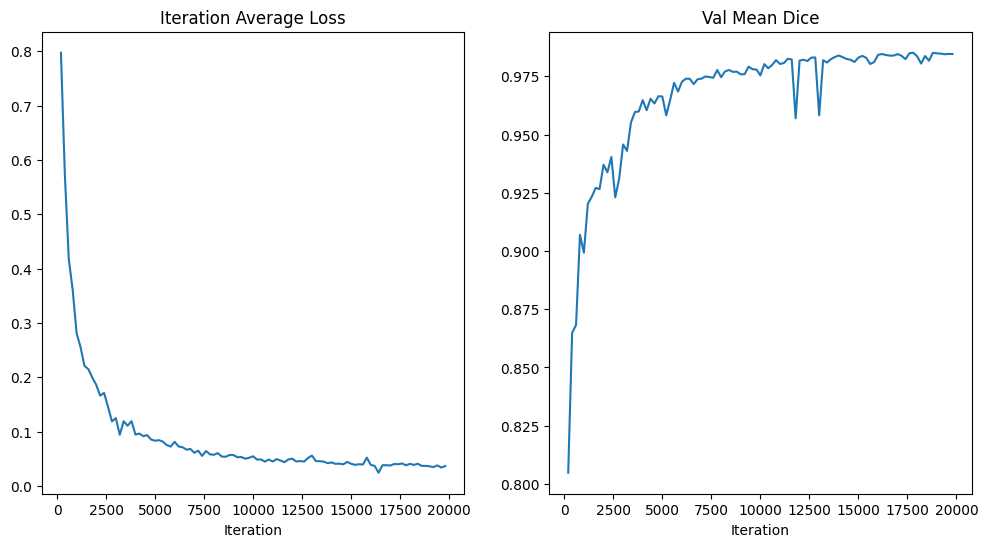

In [ ]:
# plot loss

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values_unetnoaug))]
y = epoch_loss_values_unetnoaug
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values_unetnoaug))]
y = metric_values_unetnoaug
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

# Save the metric values and epoch loss values to separate files
np.save(os.path.join(root_dir, (roi_type + "metric_values_unetnoaug.npy")), np.array(metric_values_unetnoaug))
np.save(os.path.join(root_dir, (roi_type + "epoch_loss_values_unetnoaug.npy")), np.array(epoch_loss_values_unetnoaug))

In [ ]:
torch.save(model.state_dict(), os.path.join(root_dir, (roi_type+"unet_noaug_best_metric_model.pth")))
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"unet_noaug_best_metric_model.pth"))))

<All keys matched successfully>

In [ ]:
split_JSON_run = "face-training-1-lab-v1.json"


datasets_run = data_dir + split_JSON_run
val_files_run = load_decathlon_datalist(datasets_run, True, "validation")
val_ds_run = CacheDataset(
    data=val_files_run, transform=val_transforms, cache_num=300, cache_rate=1.0, num_workers=4
)
val_loader_run = DataLoader(
    val_ds_run, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset: 100%|██████████| 12/12 [00:00<00:00, 31.30it/s]


In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"unet_noaug_best_metric_model.pth"))), strict=False)
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.5, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
                (D): Dropout(p=0.5, inplace=False)
                (A): PReLU(num_pa

0 261-img.nii.gz
size of predicted and ground truth:
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


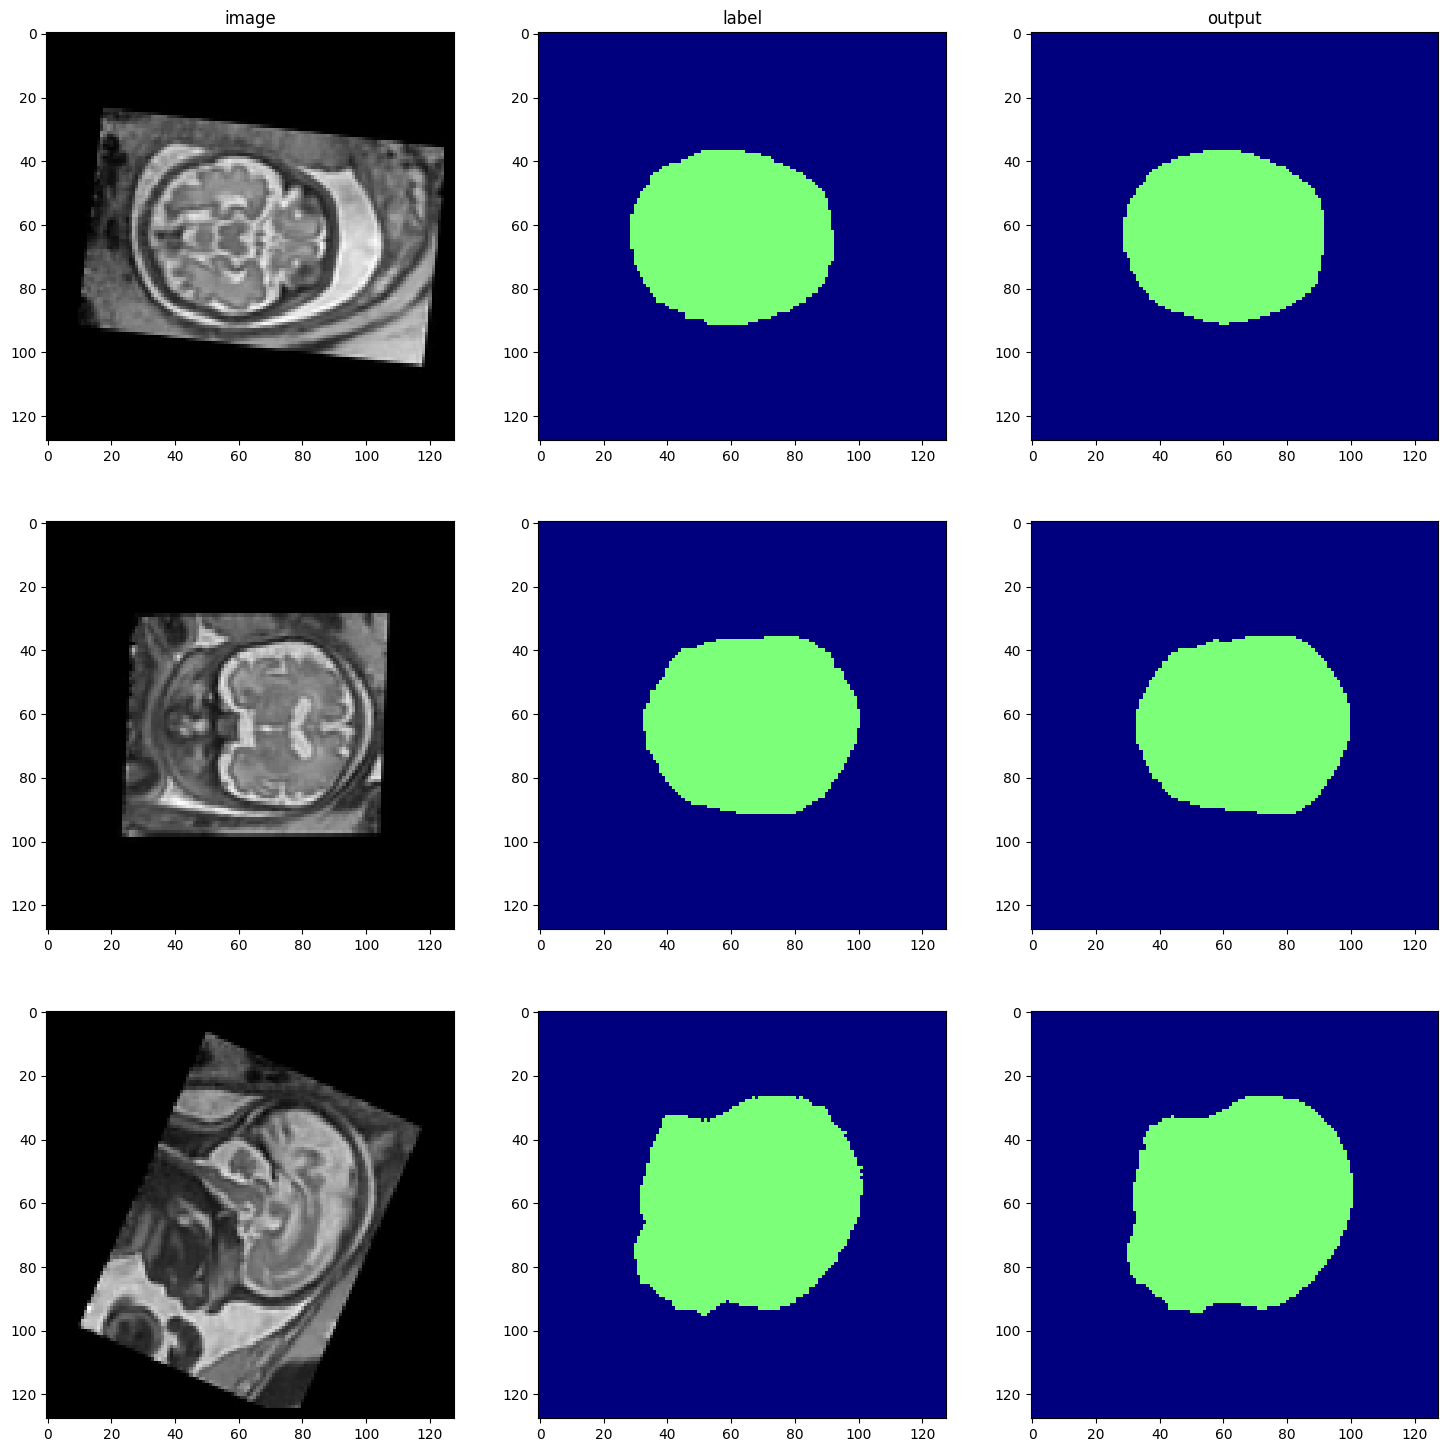

1 335-img.nii.gz
size of predicted and ground truth:
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


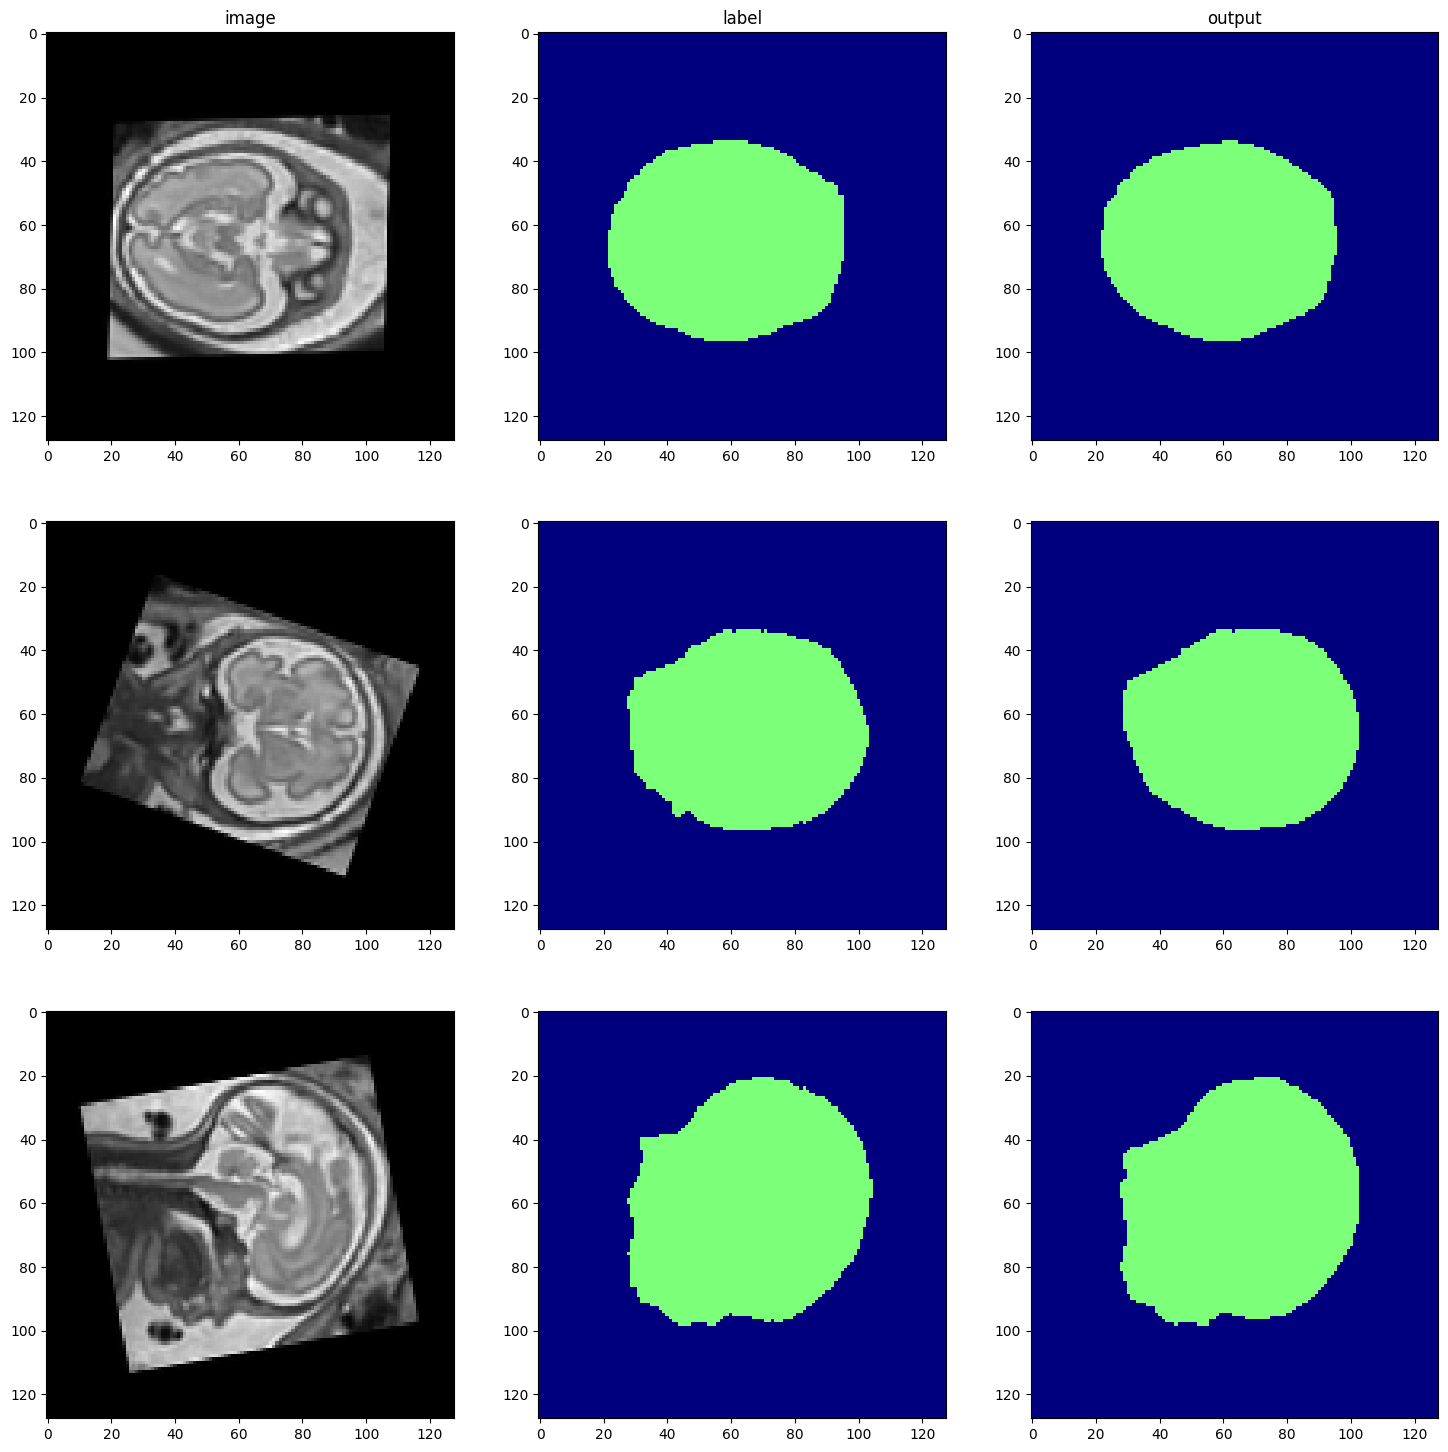

2 426-img.nii.gz
size of predicted and ground truth:
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


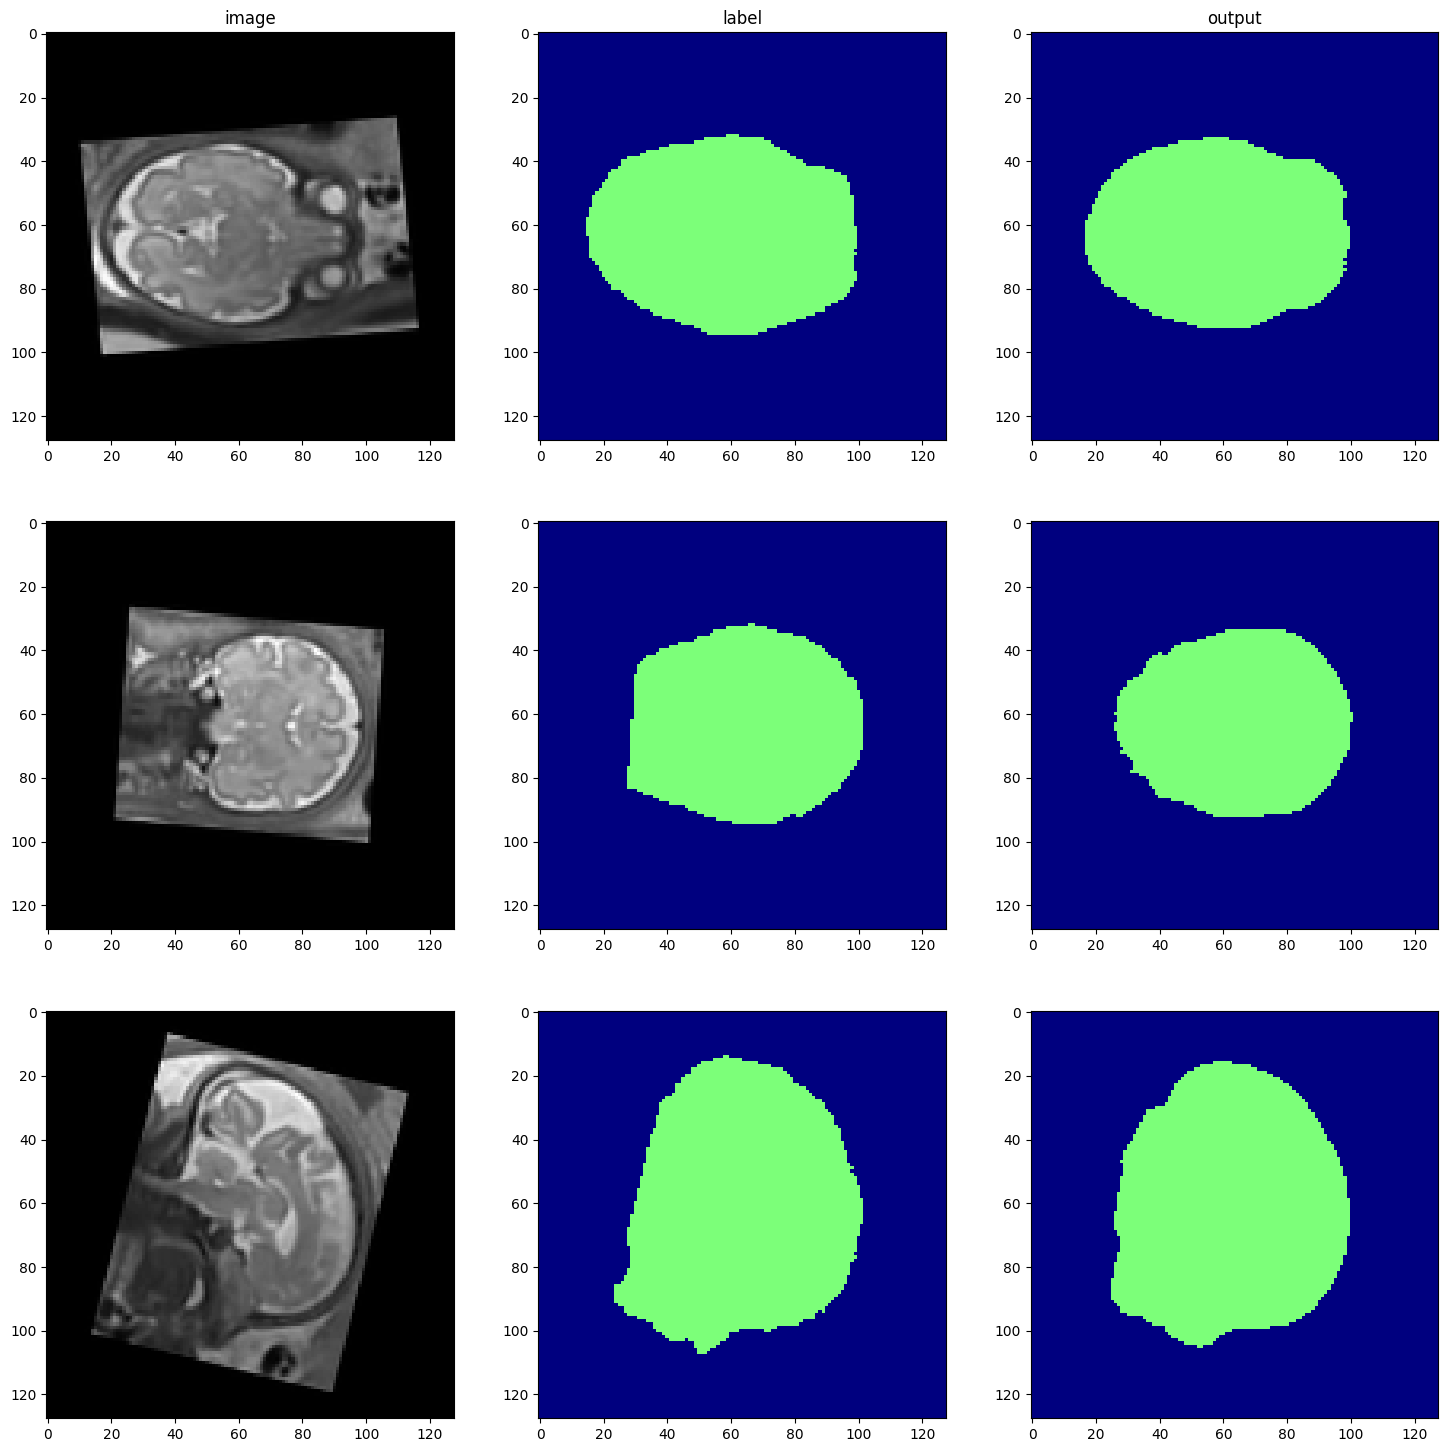

3 342-img.nii.gz
size of predicted and ground truth:
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


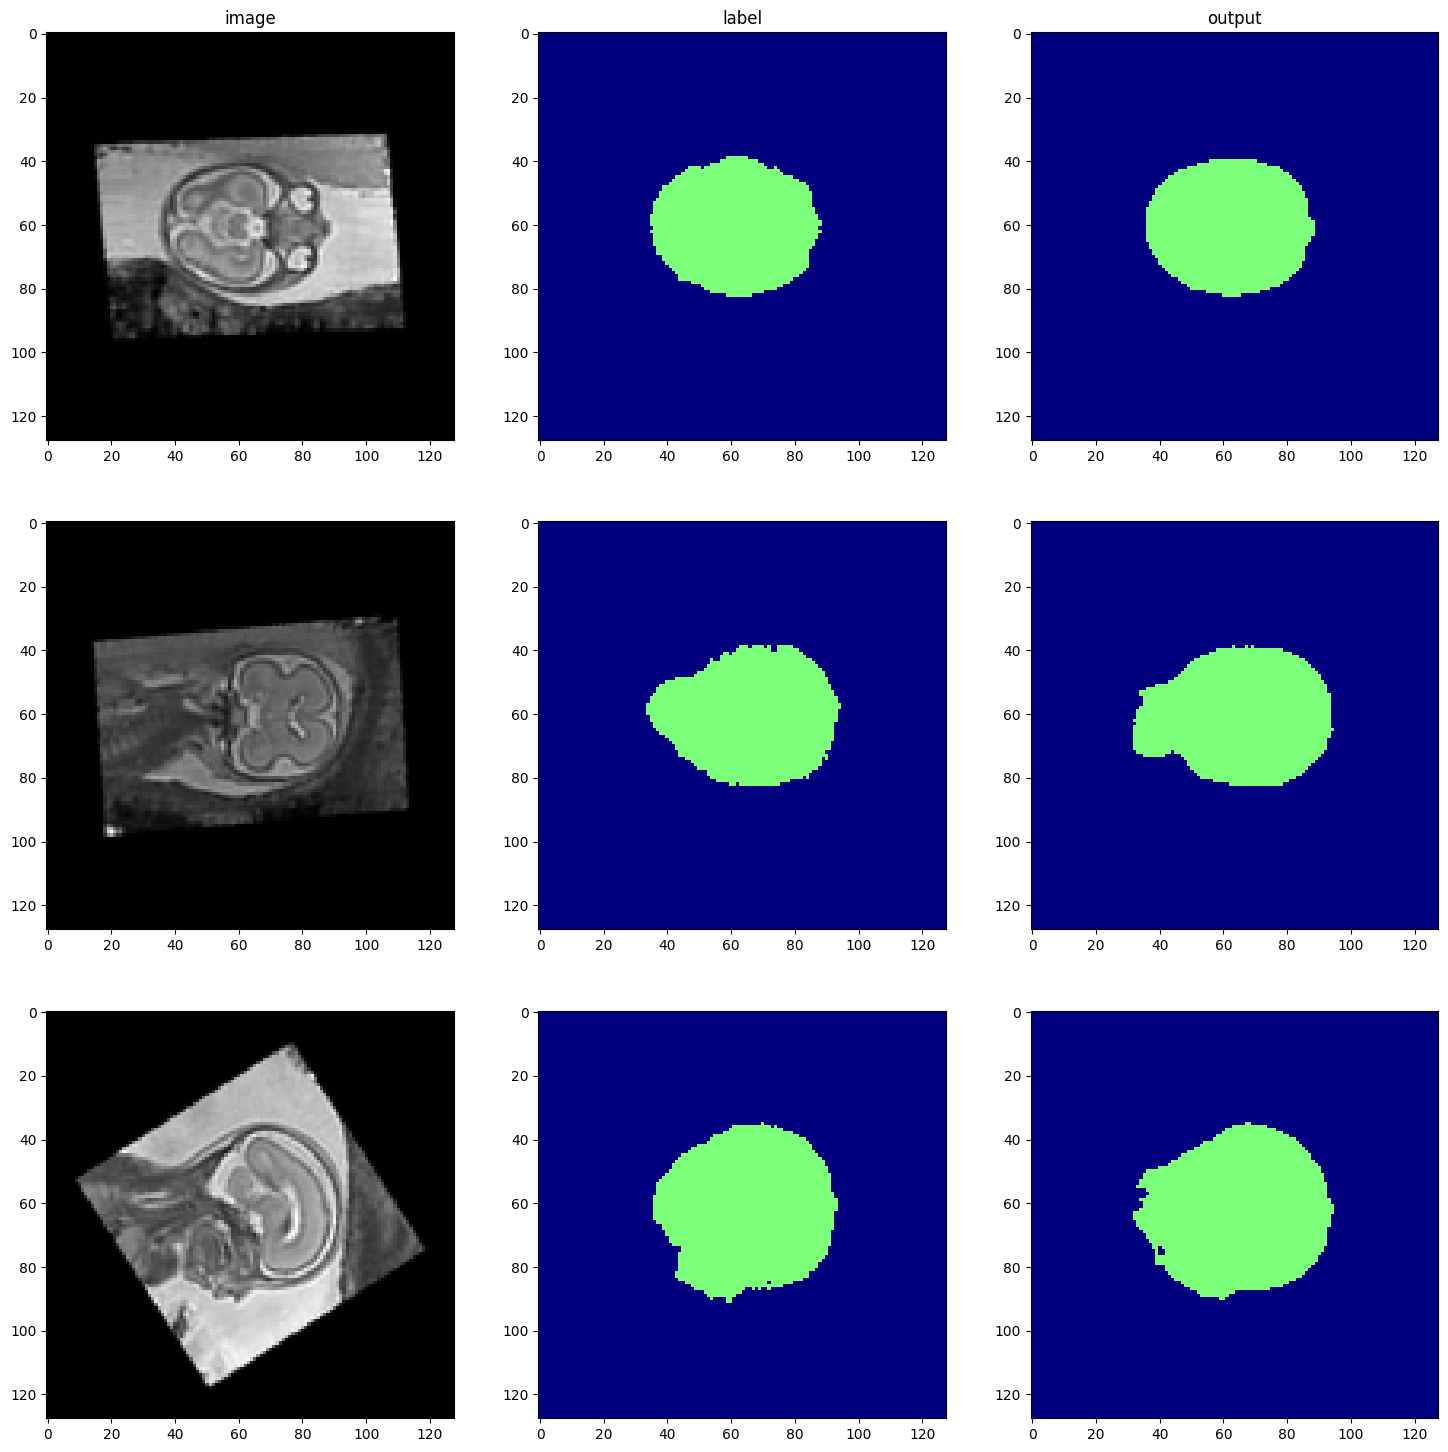

4 435-img.nii.gz
size of predicted and ground truth:
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


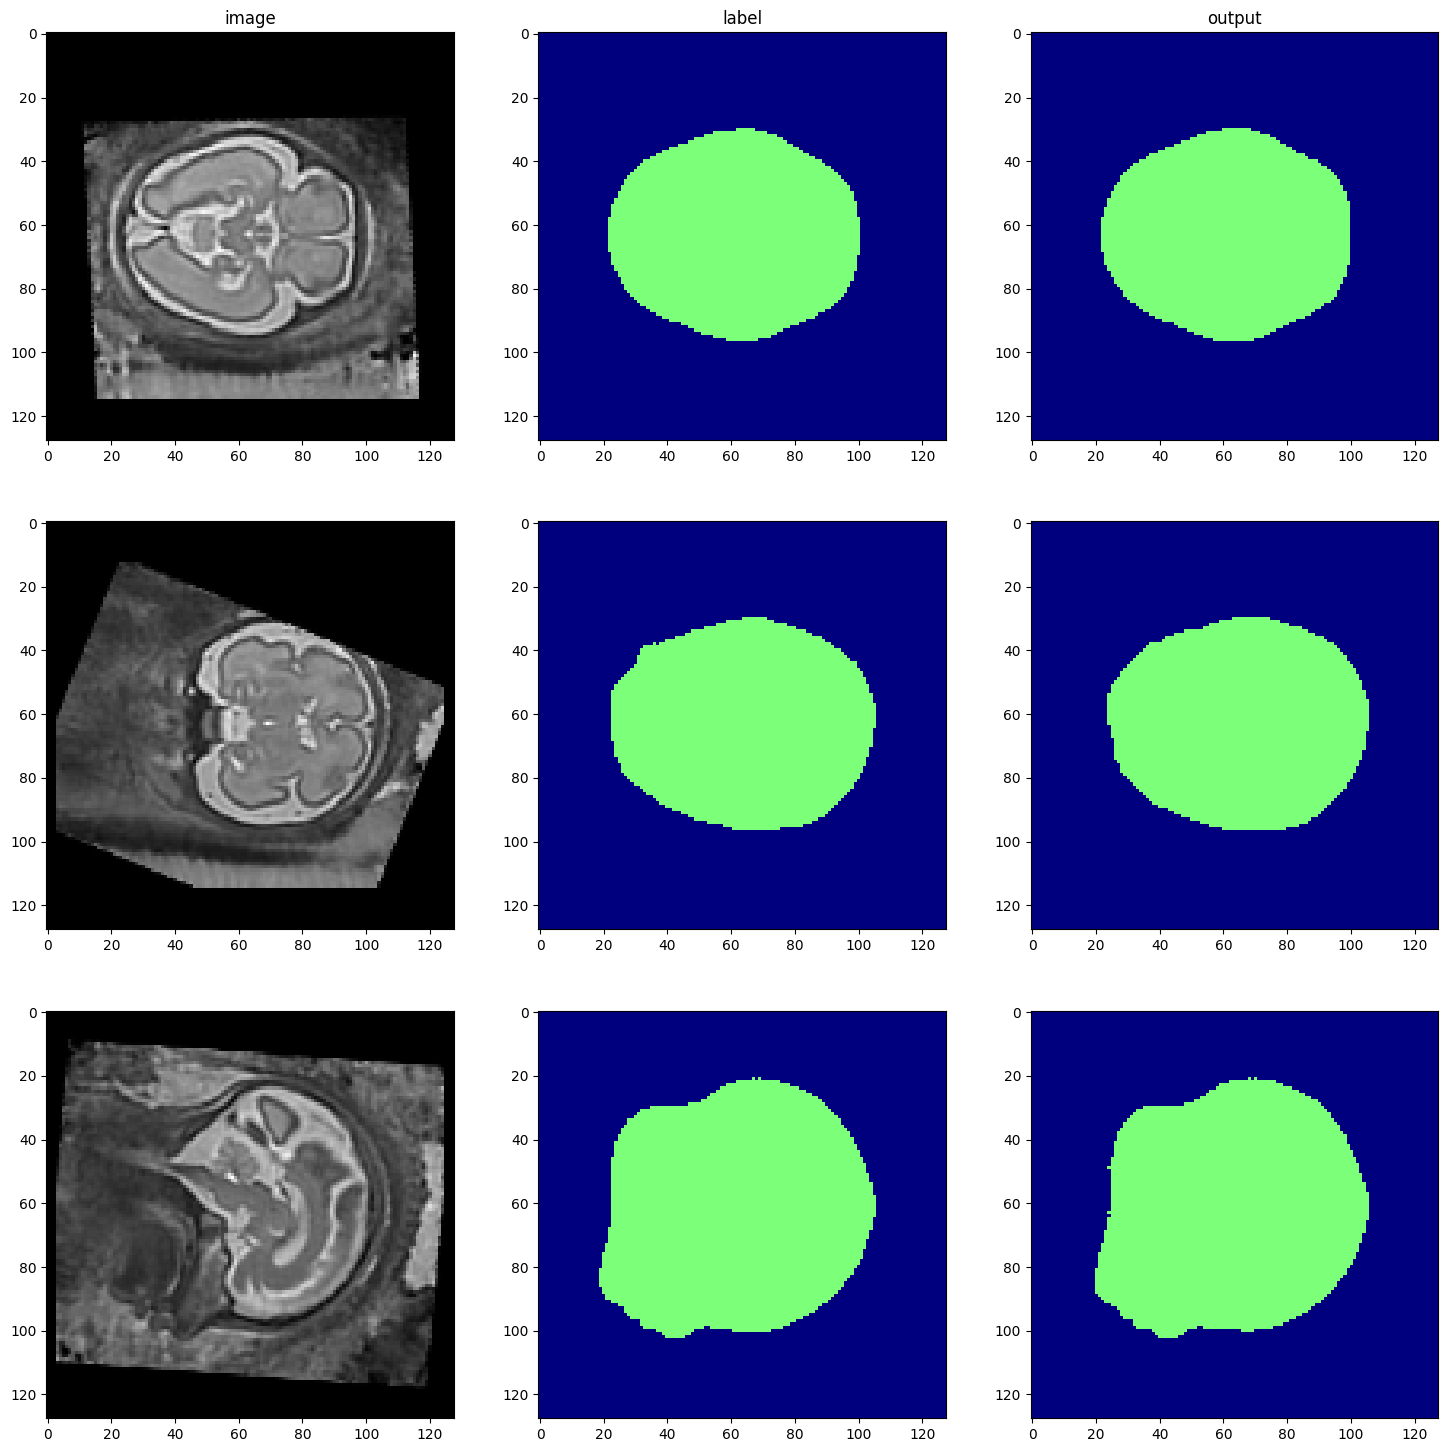

5 hist-136-img.nii.gz
size of predicted and ground truth:
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


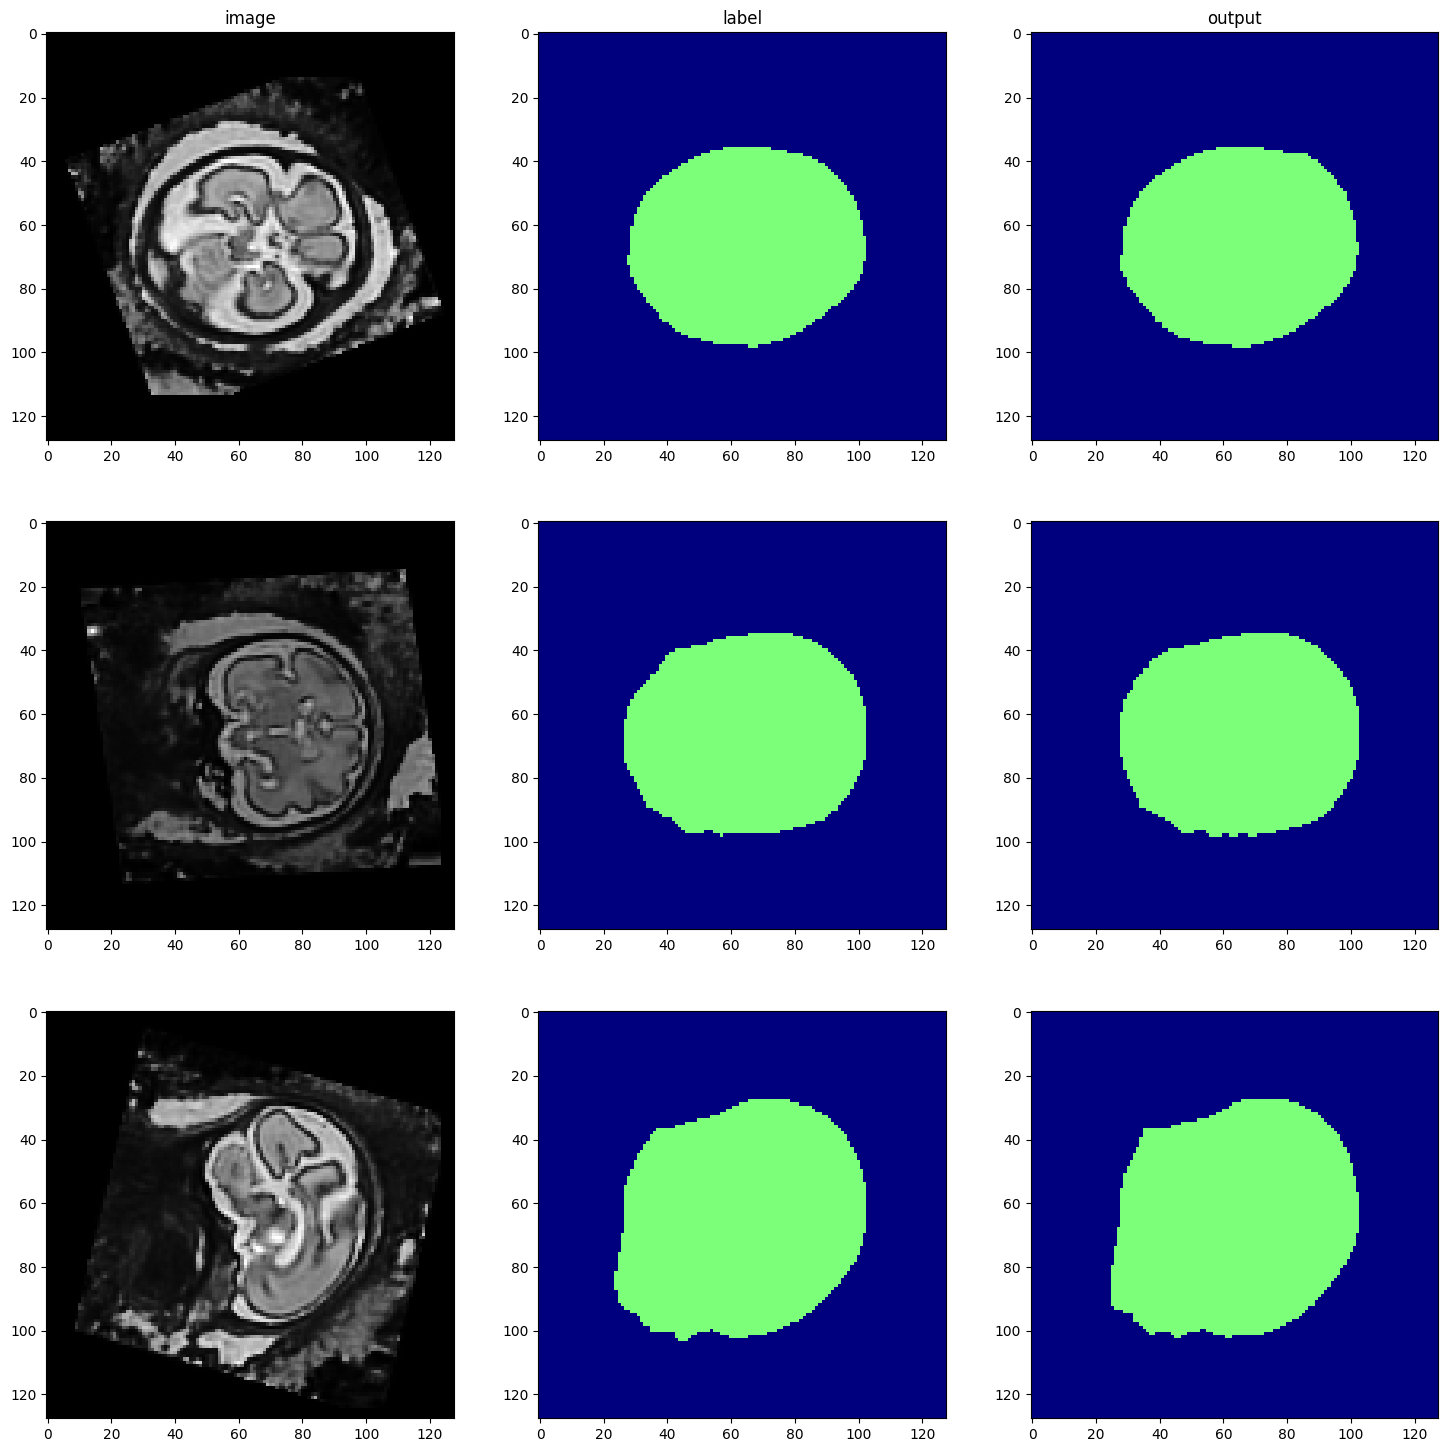

6 hist-214-img.nii.gz
size of predicted and ground truth:
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


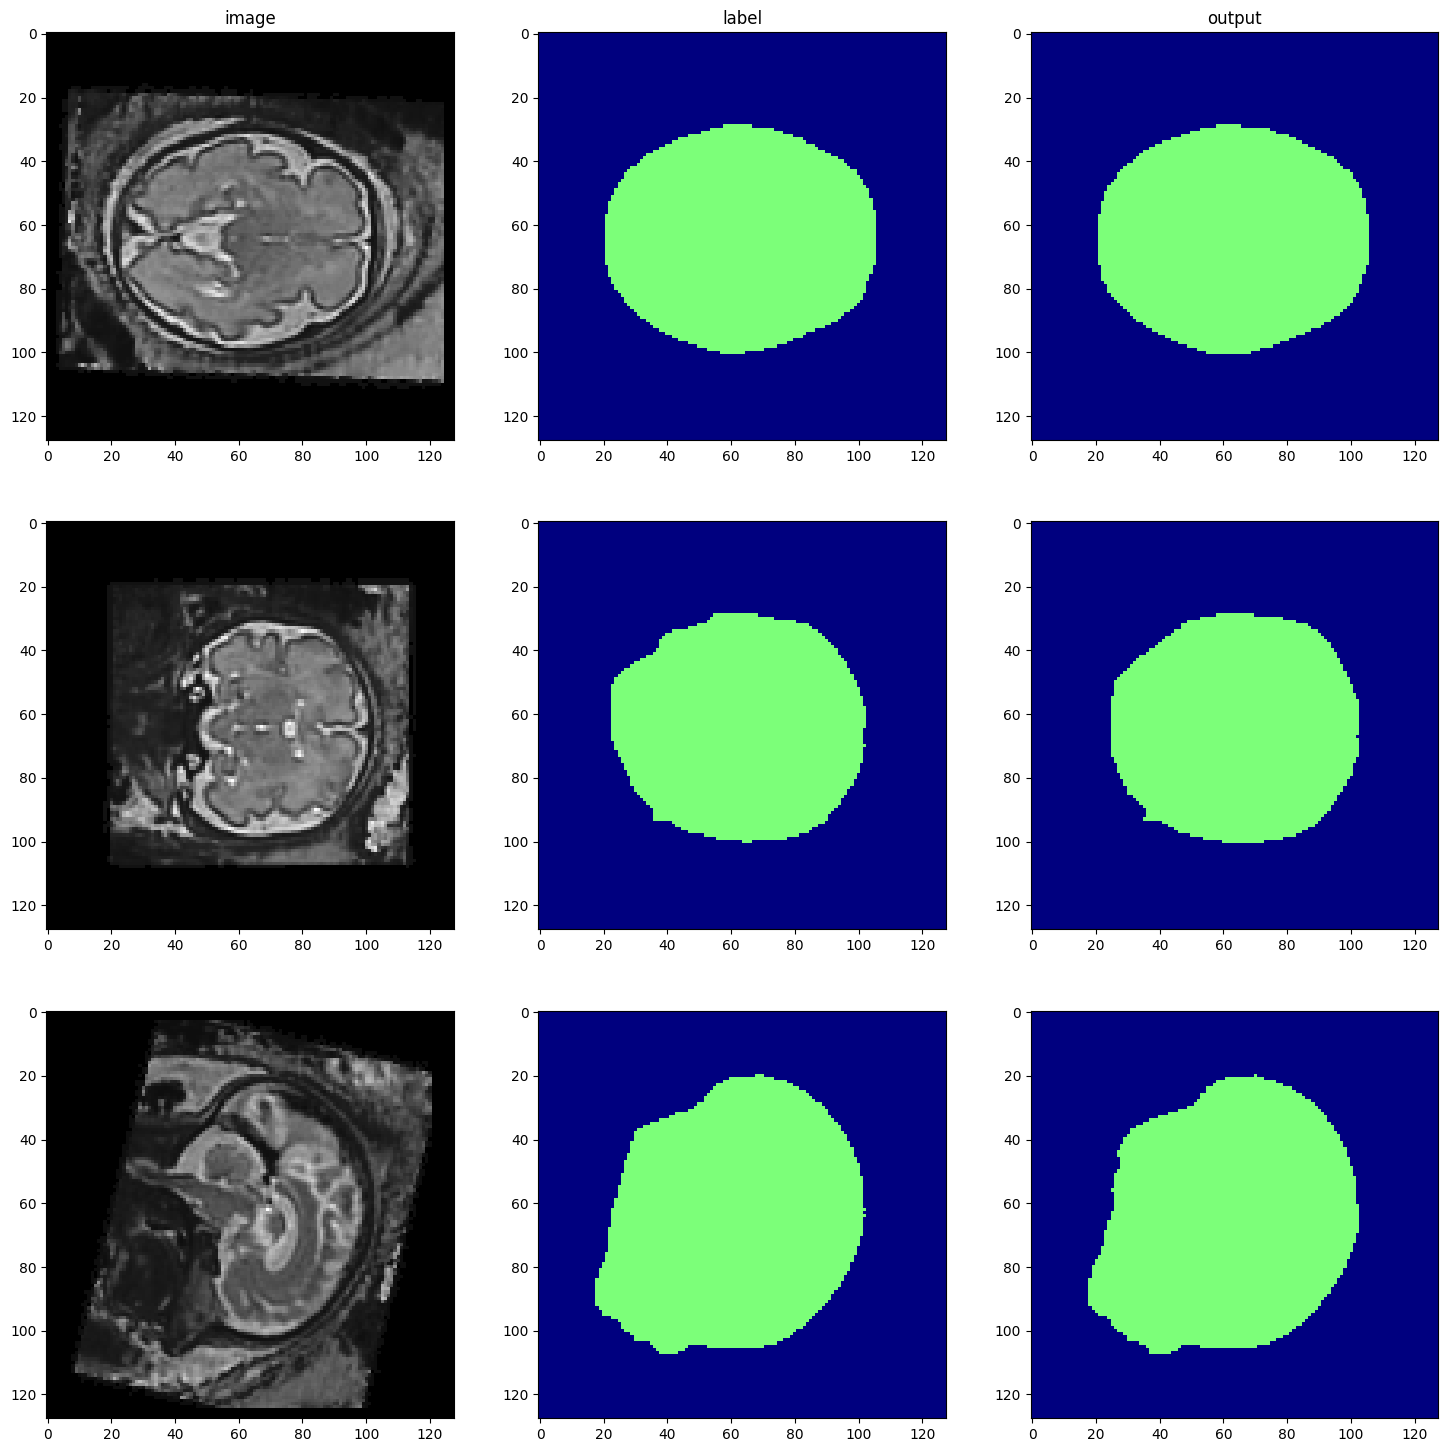

7 hist-236-img.nii.gz
size of predicted and ground truth:
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


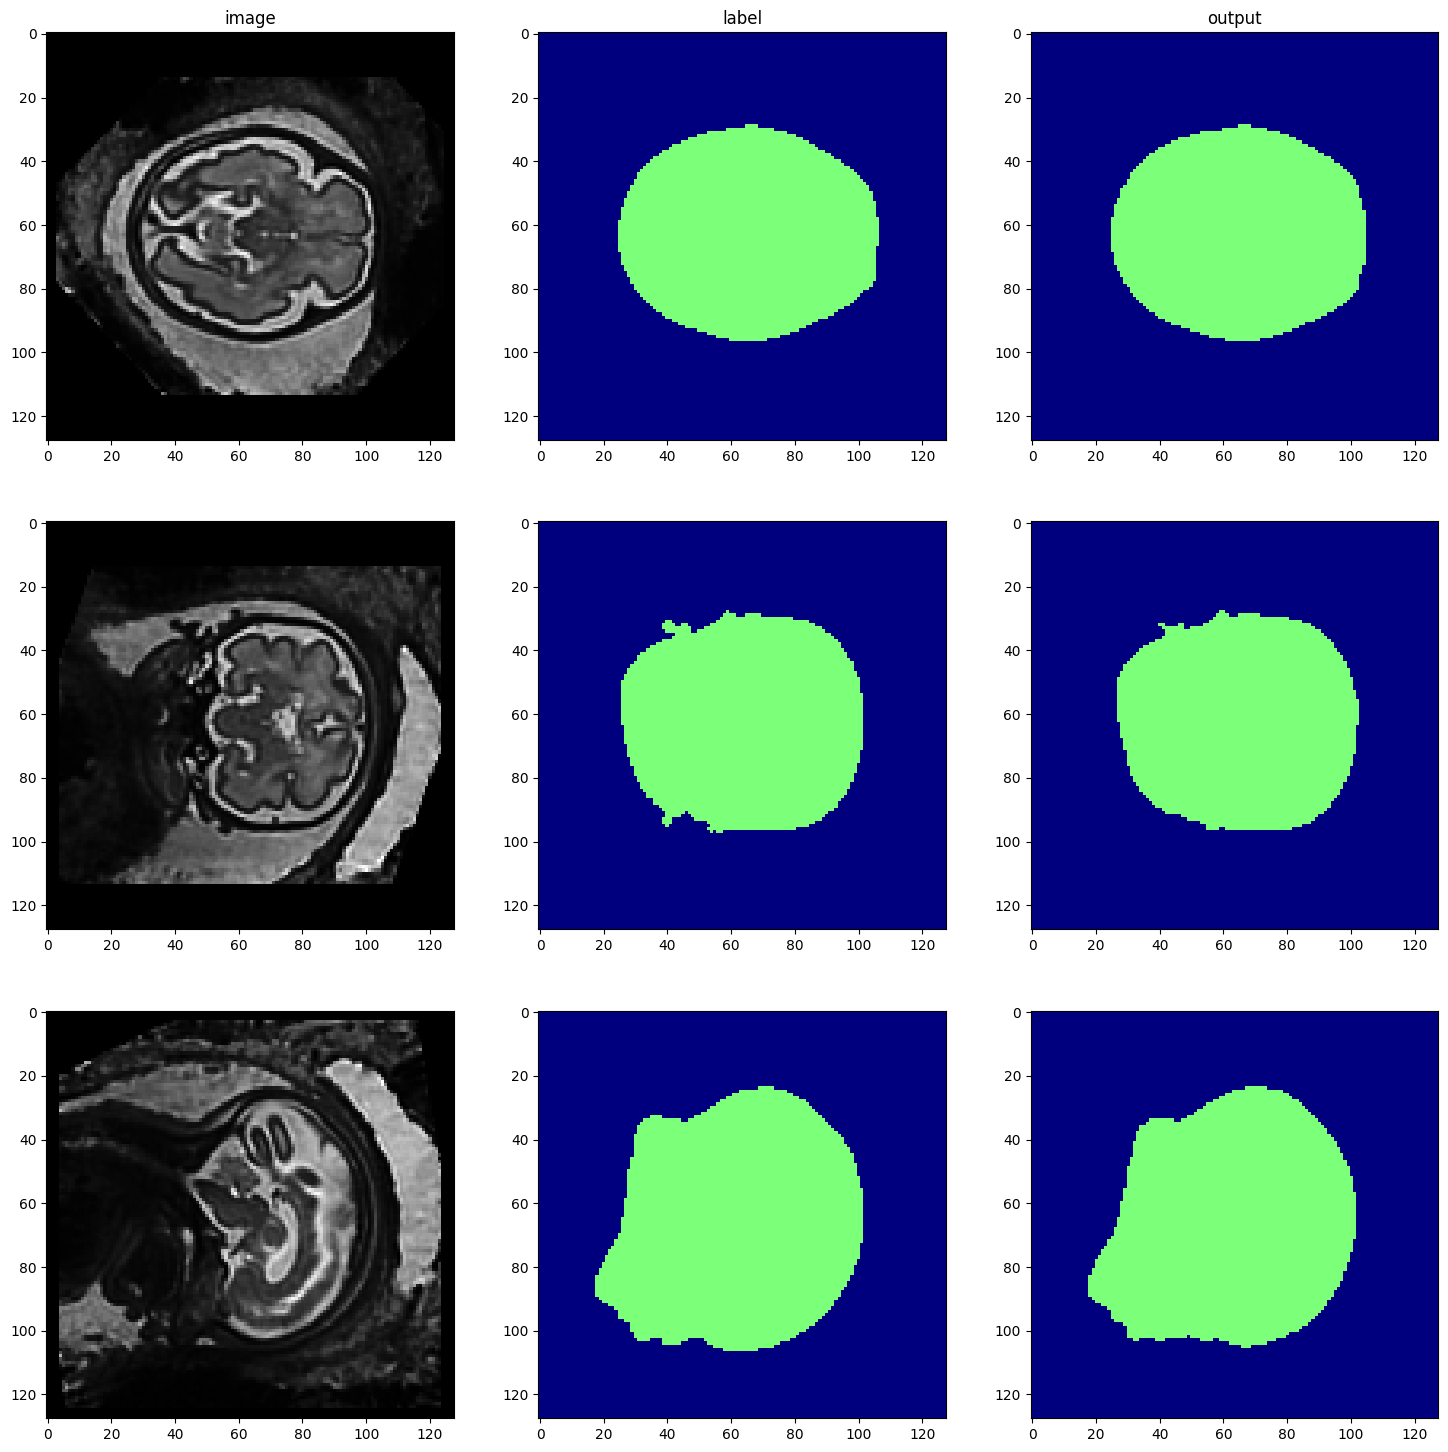

8 hist-253-img.nii.gz
size of predicted and ground truth:
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


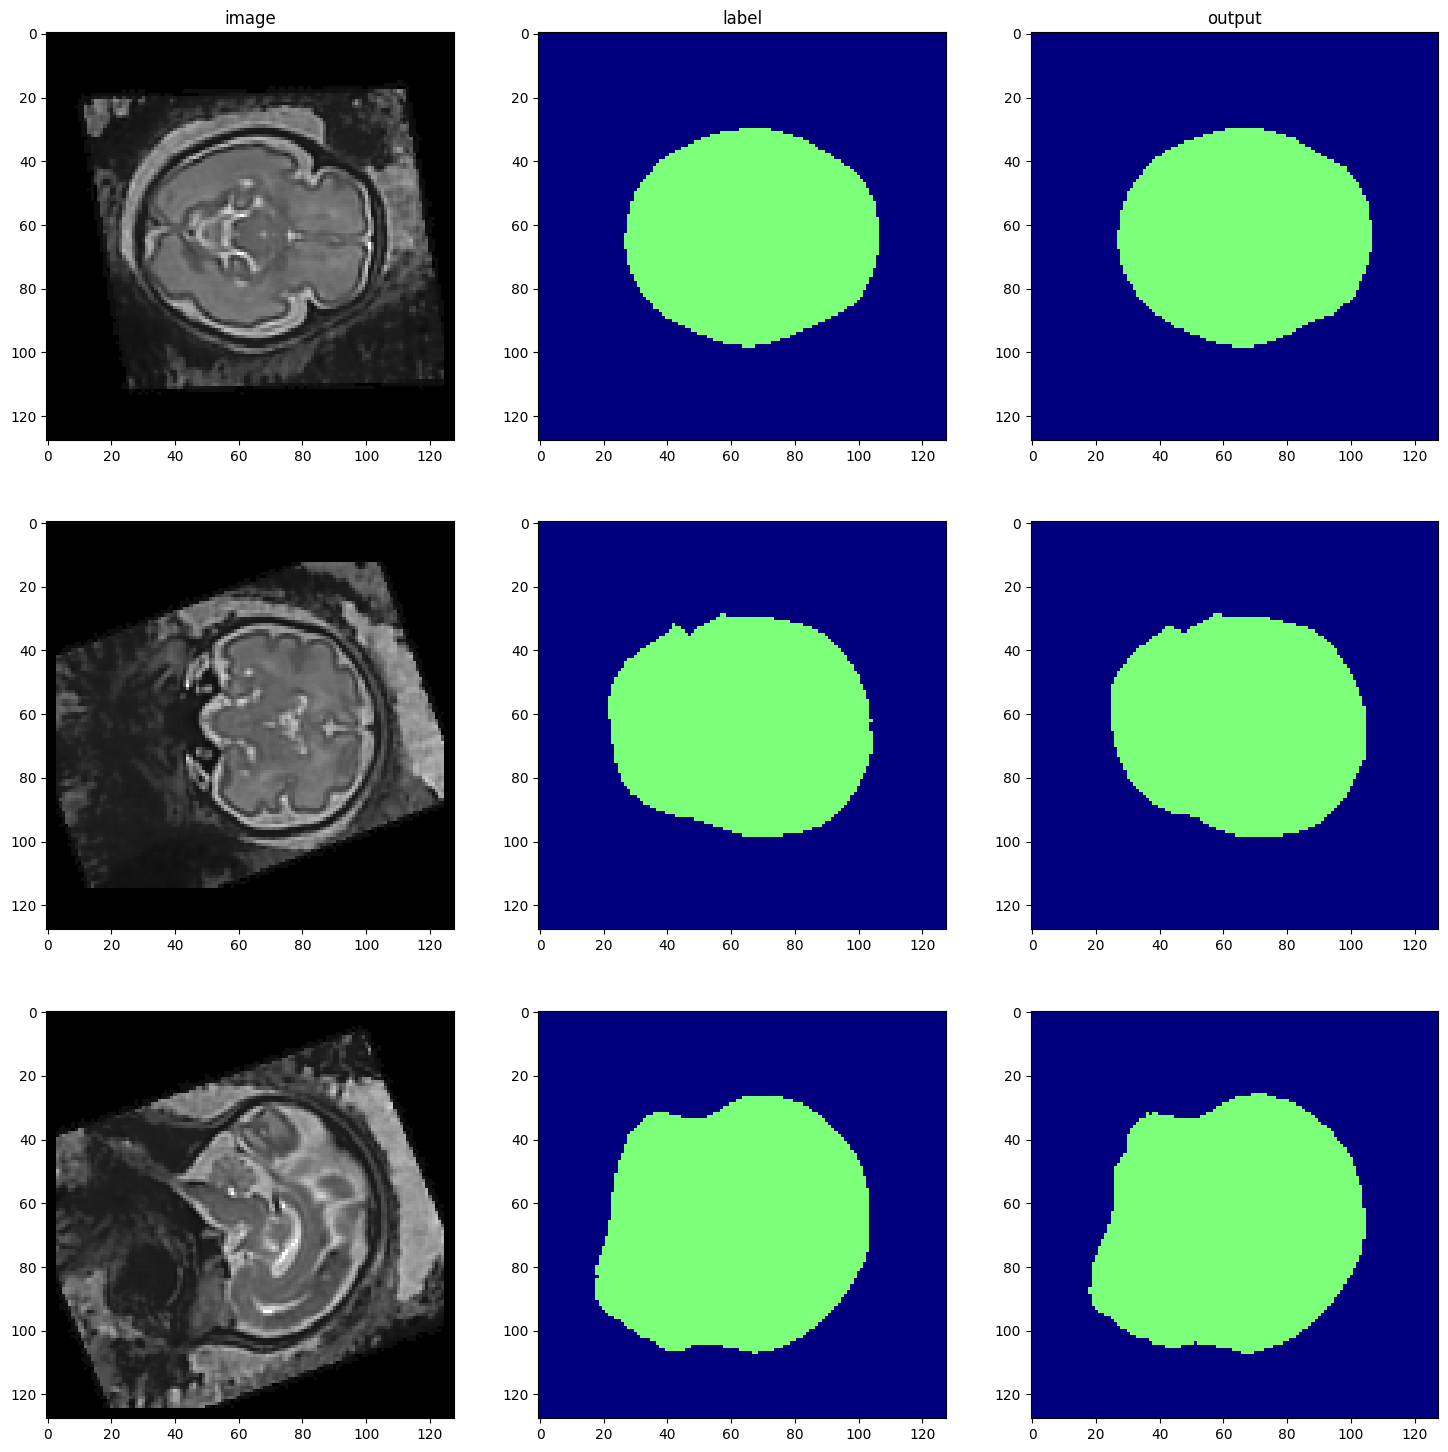

9 hist-275-img.nii.gz
size of predicted and ground truth:
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


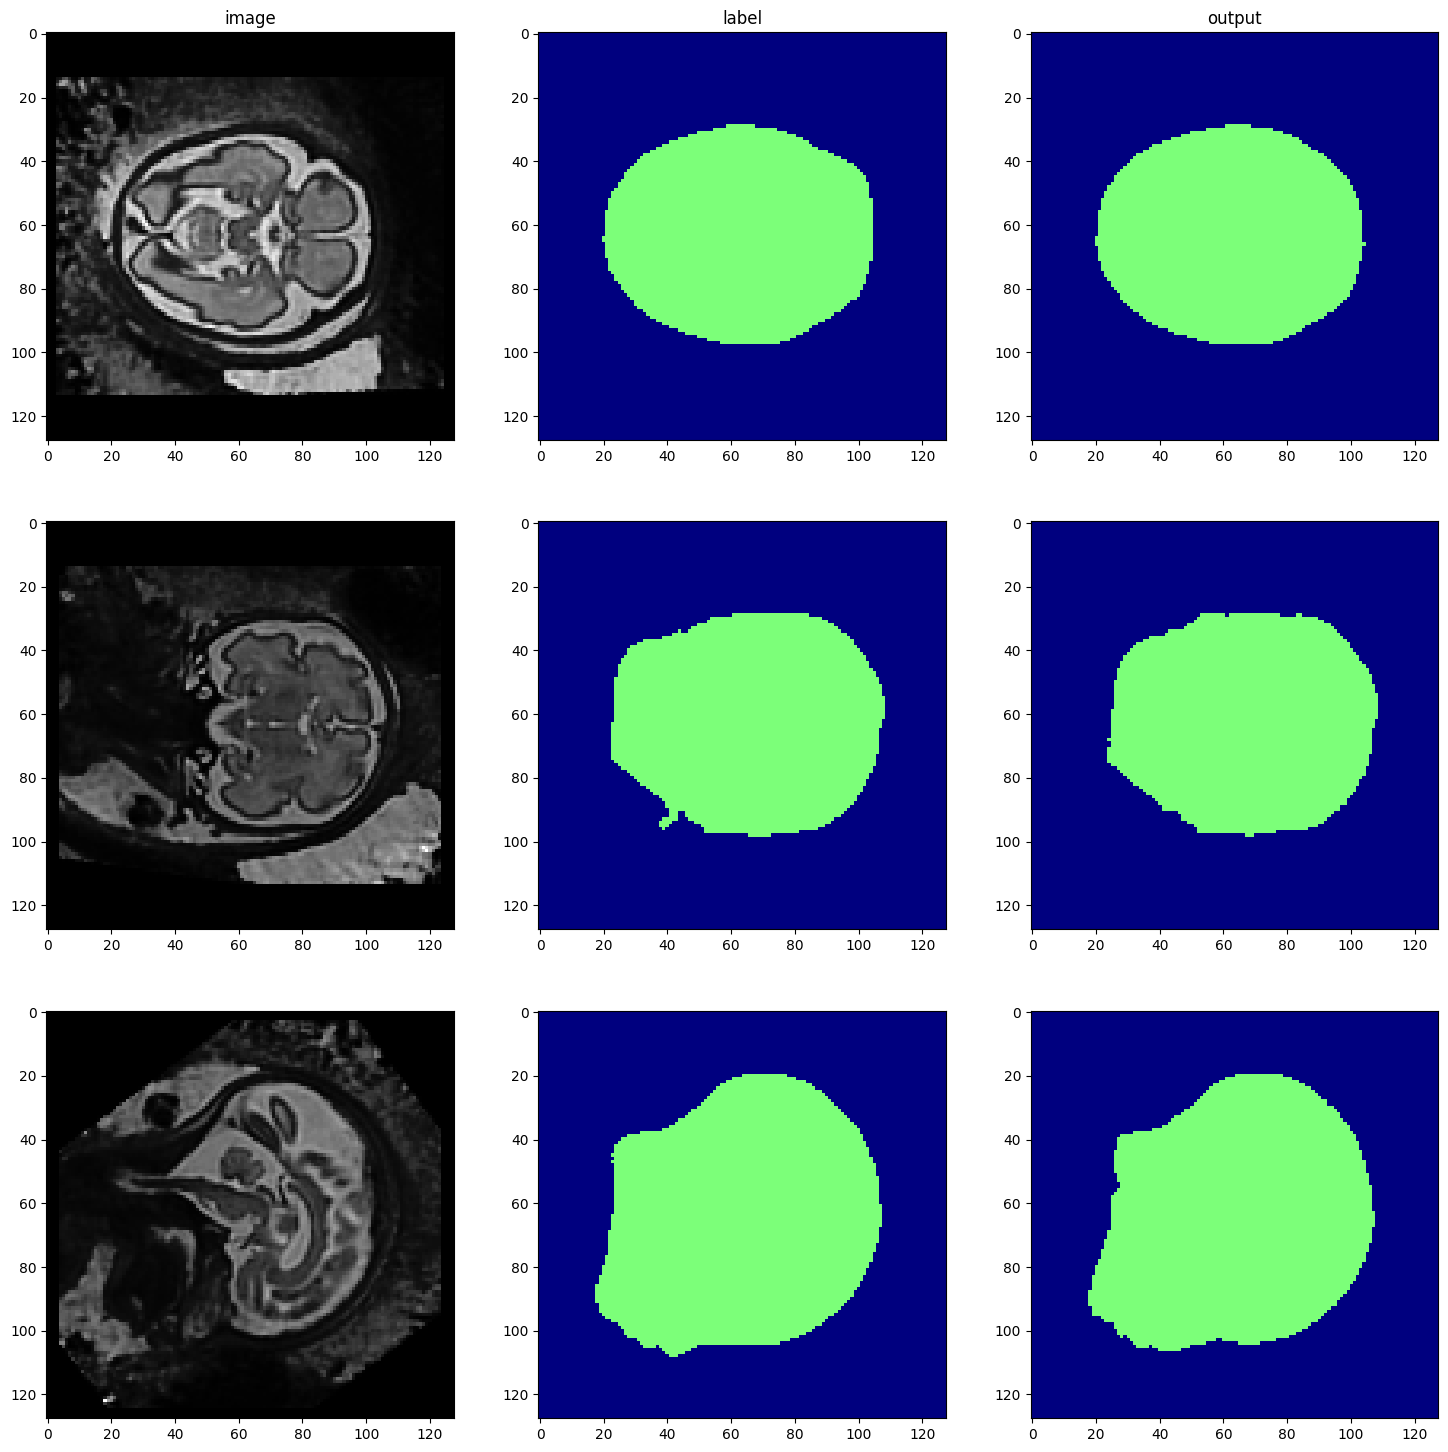

10 hist-292-img.nii.gz
size of predicted and ground truth:
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


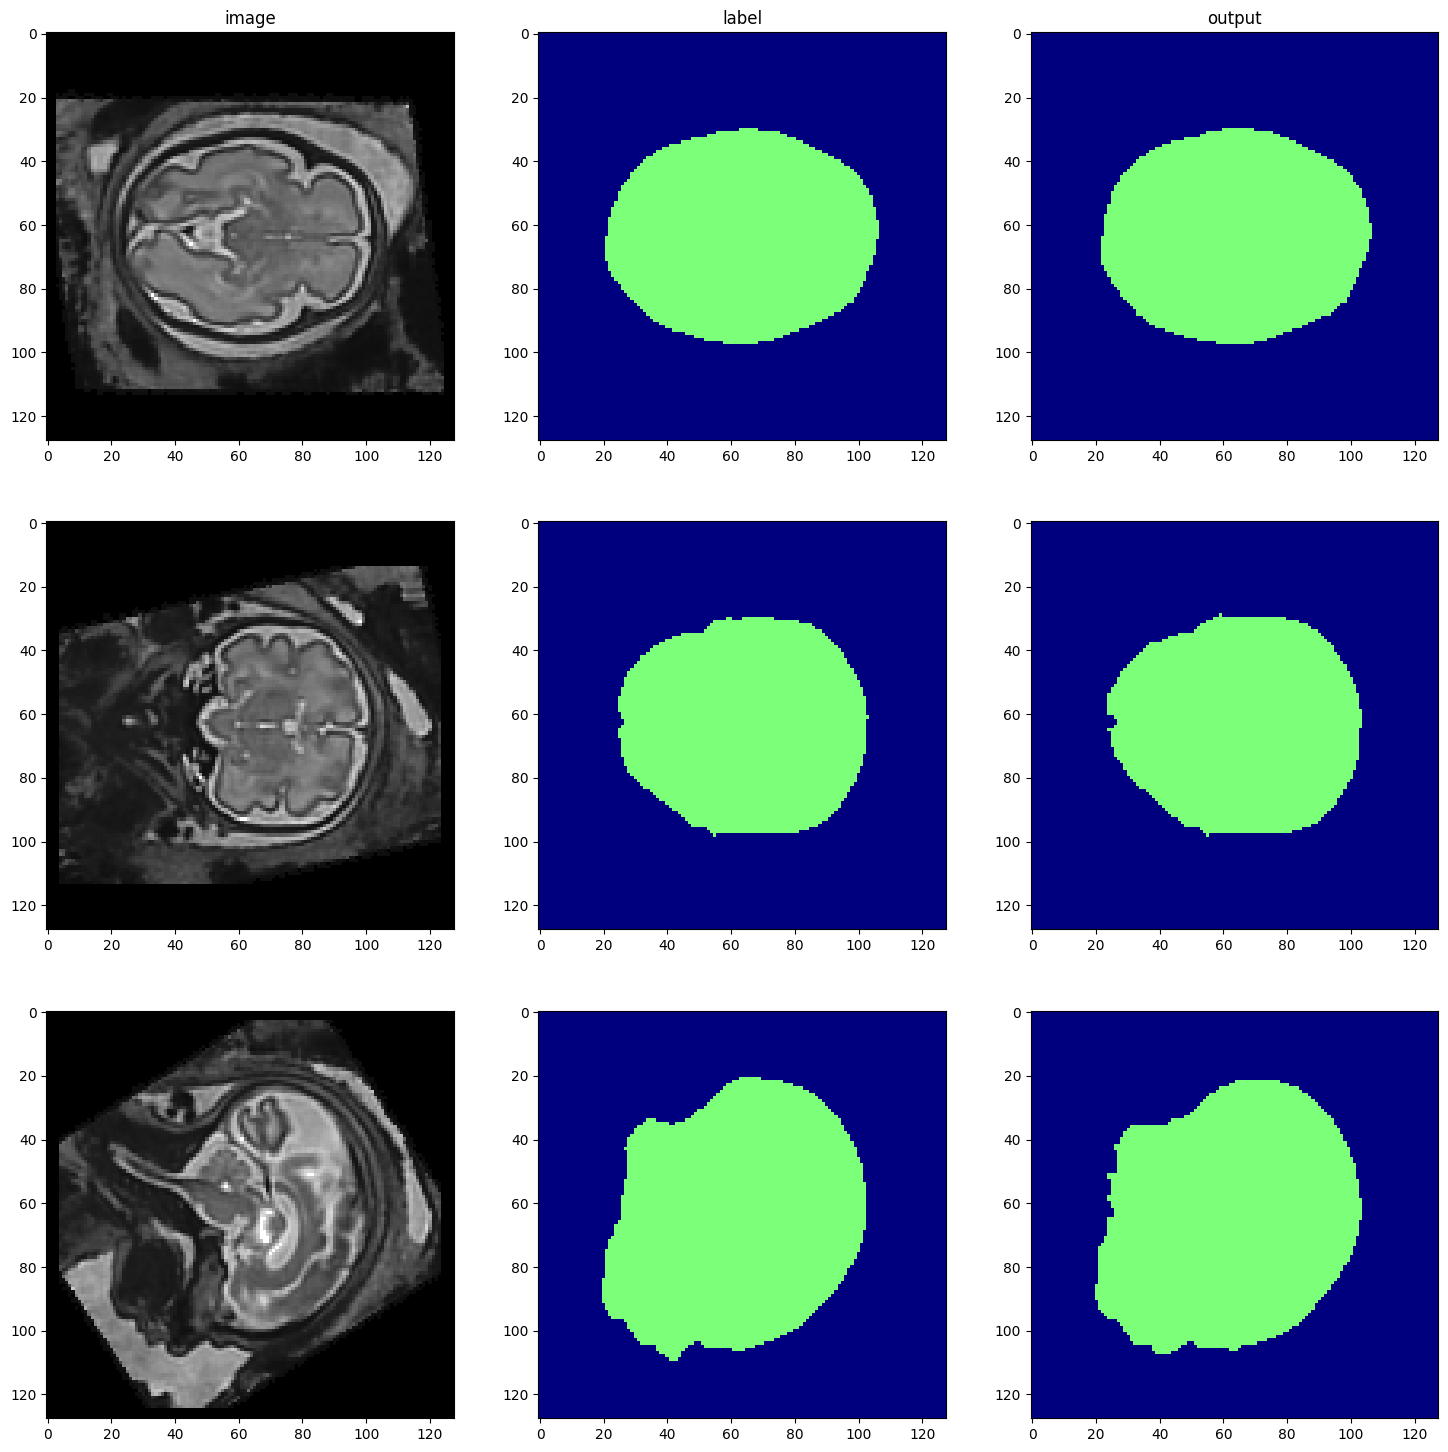

11 hist-355-img.nii.gz
size of predicted and ground truth:
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


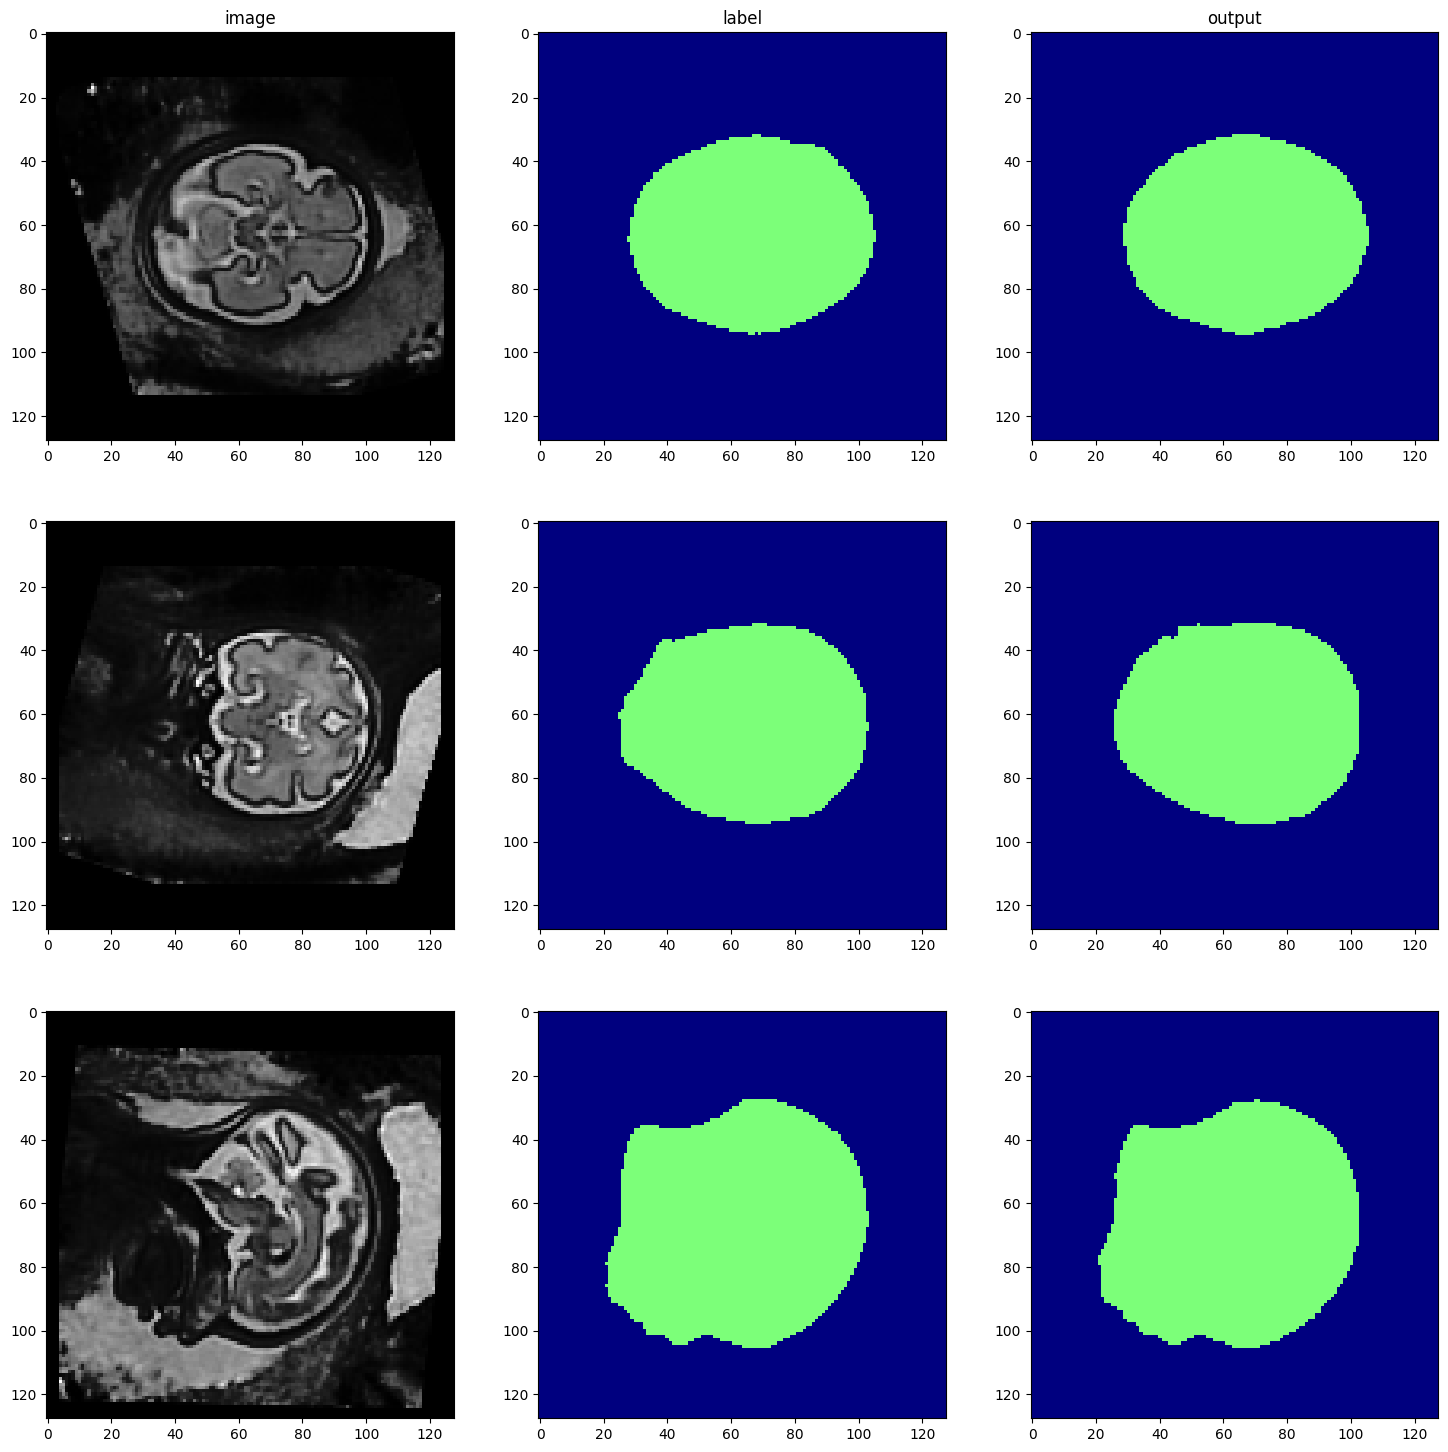

In [ ]:

class_n = class_num
qq=round(img_dim/2)

for x in range(len(val_files_run)):

  case_num = x
  with torch.no_grad():
      img_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      cur_case = val_ds_run[case_num]
      img = cur_case["image"]
      label = cur_case["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      print(x,img_name)
      print("size of predicted and ground truth:")
      print(val_outputs.shape)
      print(val_labels.shape)

      plt.figure("check", (18, 18))
      plt.subplot(3, 3, 1)
      plt.title("image")
      plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
      plt.subplot(3, 3, 2)
      plt.title("label")
      plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 3)
      plt.title("output")
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], vmin=0, vmax=class_n, cmap="jet")

      plt.subplot(3, 3, 4)
      plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
      plt.subplot(3, 3, 5)
      plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 6)
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], vmin=0, vmax=class_n, cmap="jet")


      plt.subplot(3, 3, 7)
      plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
      plt.subplot(3, 3, 8)
      plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], vmin=0, vmax=class_n, cmap="jet")
      plt.subplot(3, 3, 9)
      plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], vmin=0, vmax=class_n, cmap="jet")

      plt.show()



In [ ]:
# save cnn segmentation results for all validation images


res_dir = root_dir + "/" + roi_type + "3D_UNet_noaug_valid_results"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)


for x in range(len(val_files_run)):

  case_num = x
  img_name = val_files_run[case_num]["label"]
  label_name = val_files_run[case_num]["label"]
  case_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  out_name = res_dir + "/cnn-lab-" + case_name
  print(case_num, out_name)

  img_tmp_info = nib.load(img_name)

  with torch.no_grad():
      img_name = os.path.split(val_ds_run[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      img = val_ds_run[case_num]["image"]
      label = val_ds_run[case_num]["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      out_label = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :]
      out_lab_nii = nib.Nifti1Image(out_label, img_tmp_info.affine, img_tmp_info.header)
      nib.save(out_lab_nii, out_name)


0 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_3D_UNet_noaug_valid_results/cnn-lab-261-img.nii.gz
1 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_3D_UNet_noaug_valid_results/cnn-lab-335-img.nii.gz
2 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_3D_UNet_noaug_valid_results/cnn-lab-426-img.nii.gz
3 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_3D_UNet_noaug_valid_results/cnn-lab-342-img.nii.gz
4 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_3D_UNet_noaug_valid_results/cnn-lab-435-img.nii.gz
5 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_3D_UNet_noaug_valid_results/cnn-lab-hist-136-img.nii.gz
6 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_3D_UNet_noaug_valid_results/cnn-lab-hist-214-img.nii.gz
7 /content/drive/MyDrive/face-seg-project-2023/new-training-062023//face_3D_UNet_noaug_valid_results/cnn-lab-hist-236-img.

In [ ]:
# model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"best_metric_model.pth"))), strict=False)
# model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.5, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
                (D): Dropout(p=0.5, inplace=False)
                (A): PReLU(num_pa